# Install required packages

In [1]:
#!pip install brian2
#!pip install brian2tools
#!pip install scikit-learn
#!pip install nb_black

In [2]:
#%load_ext lab_black

# Determine where the files are

In [2]:
try:
    # Try to connect to google drive for loading data if running on colab
    from google.colab import drive
    drive.mount('/content/drive')
    running_on_colab = True
except:
    running_on_colab = False

# Load libraries and functions

In [3]:
# -*- coding: utf-8 -*-

# Load libraries

# Compatibility between Python 2 and Python 3
from __future__ import division, print_function, unicode_literals, absolute_import

%matplotlib inline
import os
from pathlib import Path
import math
import numpy as np
from scipy import interpolate
from brian2 import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

#from Python_Libs.utility_functions import *

SAVE_PLOT = False
figs_path = 'Data/Plots_v4/'
figs_extension = '.svg'

if SAVE_PLOT:
    Path(figs_path).mkdir(parents=True, exist_ok=True)

plot_style = {
    "font.family": "Arial",     # specify font family here
    "font.size"  : 10,
    "axes.spines.top"    : True, 
    "axes.spines.right"  : True, 
    "xtick.direction"     : "out",
    "ytick.direction"     : "out",
    "xtick.color"         : "black",
    "ytick.color"         : "black"
}

plt.rcParams.update(plot_style) # Update the style

figsize = (3.8, 2.6)

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')

if SAVE_PLOT:
    plt.rcParams.update({'font.size': 10}) # Change the font size


In [4]:
# Copy of utility_functions.py

# Decoding the population activity into a population vector

def get_orientation(idx_list, N):
    """
        idx_list : list indeces of neurons
        N        : Number of neurons
        returns  : list of theta angle preferences of neurons in the list of indeces
        
        The circle 360 is broken into N intervals and the angle corresponding in 
        the middle of the interval is calculated. 
    """
    interval = 360. / N 
    interval_middle  = 360. / N / 2

    return  (interval_middle + interval * np.array(idx_list)).tolist()


def get_spike_count(spike_monitor, spike_index_list, t_min, t_max):
    """
        Returns : A list of spike counts
    """
    nr_neurons = len(spike_index_list)
    spike_count_list = np.zeros(nr_neurons)
    if isinstance(spike_monitor, SpikeMonitor):
        spike_trains = spike_monitor.spike_trains()
    elif isinstance(spike_monitor, dict): # If it is a dict() assume it is the result of spike_trains()
        spike_trains = spike_monitor
    
    spike_count_list = []
    
    for idx in spike_index_list:
        num_of_spikes = np.sum(np.logical_and(spike_trains[idx] >= t_min, spike_trains[idx] < t_max))
        spike_count_list.append(num_of_spikes)
    
    return spike_count_list


def get_spike_rates(spike_monitor, spike_index_list, t_snapshots, t_window_width):
    """ 
        Returns : An array of spike rates one per recorded neuron in the spike_monitor
    """
    spike_counts_list = []
    for t_snap in t_snapshots:
        t_min = t_snap - t_window_width/2
        t_max = t_snap + t_window_width/2
        spike_counts = get_spike_count(spike_monitor, spike_index_list, t_min, t_max)
        spike_counts_list.append(spike_counts)
    
    # Turn it into a matrix with first index indexing neuron number
    spike_rates_array = np.array(spike_counts_list).T / t_window_width

    return spike_rates_array


def get_full_width_at_half_maximum(values_array, circular=False, value_range=None):
    """
        Gets an 1D array of values.
        Returns a scalar value of the Full Width at Half Maximum of the array values.
        Returns FWHM = inf in case that there is no peak.
        If circular==False it returns  FWHM = inf if the peak is on the one end of the array.
        If circular==True and there are only two 0 crossings it attempts to return 
        a valid width even if the peak crosses the edges of the array.
        If circular==True and there is only one 0 crossing it assumes distribution symmetry 
        and just doubles the width. This must be very innacurate. 
        
        Returns width as number of elements between 0 crossings as a real number. If the option  
        value_range is given then the FWHM is scaled to that range, eg 360deg.
        
        Needs more testing and improvements. Testing values:
        values_array = np.array([[0,0,0,0.7,1,0.7,0,0,0],[0,0.7,1,0,0,0,0,0,0],[1,0,0,0,0,0,0,0,0.5],[1,0.3,0,0,0,0,0,0,0.3]])[2]
        phase = 2*np.pi/8 # +4 # 0 # 1 # np.pi/2-3
        values_array = np.sin(np.linspace(-np.pi, np.pi, 8)+phase)+1
        circular = True
        It seems to be working for real simulation data.
    """
    peak_idx = np.argmax(values_array) # get the index of the first max value
    max_v = np.max(values_array)       # max value in the array
    min_v = np.min(values_array)       # min value in the array
    peak_v = values_array[peak_idx]    # signal value at the peak
    half_v = (max_v - min_v) / 2       # half of the peak to peak value of the signal
    
    # We want to find the x axis width
    # Shift signal values so that at half maximum the values are 0
    values_array_shifted = values_array - half_v
    # Fit a function to the data damples in order to precisely find 0 crossing points along the x axis
    fitted_curve = interpolate.UnivariateSpline(range(len(values_array)), values_array_shifted, s=0)
    roots = fitted_curve.roots() # get the x axis points where the function crosses y=0
    # Get the nearest y=0 crossing points at the left and right of the peak
    diffs = roots - peak_idx
    
    # If the array represents elements on a circle
    if circular:
        # If only two 0 crossings and both on the same side of the peak try to correct for wrap
        if  len(diffs) == 2 and diffs[0] * diffs[1] > 0:
            max_i = np.argmax(np.abs(diffs)) # Which of the two differences is furthest away from the peak
            if max_i == 0: # In this case both 0 crossings are on the left of the peak
                diffs[max_i] =   len(values_array)-1 - peak_idx + roots[0] # Wrap the leftmost 0 crossing
            if max_i == 1: # In this case both 0 crossings are on the right of the peak
                diffs[max_i] = -(len(values_array)-1 + peak_idx - roots[1]) # Wrap the rightmost 0 crossing
        # This is an unrealistic situation where the peak is on the one end of the array only
        if len(diffs) == 1:
            diffs = np.append(diffs, -diffs[0]) # Assume symmetry

    nearest_crossing_on_left = np.max(diffs[diffs<=0], initial=-inf)
    nearest_crossing_on_right = np.min(diffs[diffs>=0], initial=inf)
    # The distances of nearest crossing around the peak give us the FWHM
    FWHM = nearest_crossing_on_right - nearest_crossing_on_left
    
    # Convert to a number scaled to the range of values
    if value_range is not None:
        FWHM = FWHM / len(values_array) * value_range
    
    return FWHM


def get_full_width_at_half_maximum_ts(values_array_of_arrays, circular=False, value_range=None):
    FWHM_list = []
    for i, values_array in enumerate(values_array_of_arrays):
        FWHM = get_full_width_at_half_maximum(values_array, circular, value_range)
        FWHM_list.append(FWHM)
    
    return np.array(FWHM_list)

def get_peak_ts(values_array_of_arrays):
    peak_list = []
    for i, values_array in enumerate(values_array_of_arrays):
        peak = np.max(values_array)
        peak_list.append(peak)
    
    return np.array(peak_list)

def get_low_ts(values_array_of_arrays):
    peak_list = []
    for i, values_array in enumerate(values_array_of_arrays):
        peak = np.min(values_array)
        peak_list.append(peak)
    
    return np.array(peak_list)


def add_vectors(vectors_list, polar_or_cartesian='polar', angles_in='rads'):
    """
        Adds a list of vectors and returns the total vector. Receives a list of 
        vector tupples or lists in polar or cartesian coordinates and returns 
        the vector addition of all of them. 
        
        vectors_list : a list of vector tupples or lists in polar (r, th) or cartesian (x, y) coordinates.
        polar_or_cartesian : 'polar' or 'cartesian' specifies the coordinate system used.
        angles_in          : 'rads' or 'degrees' specifies how the angular values should be interpreted.
        Returns : A tupple (x_total, y_total, r_total, theta_total)
    """
    cartesian_vector_list = []
    if polar_or_cartesian=='polar':
        for v in vectors_list:
            r, th = v
            if angles_in == 'degrees':
                th = np.radians(th)
            if th > (2*np.pi):
                th = th % (2*np.pi)
            x = r * np.cos(th)
            y = r * np.sin(th)
            cartesian_vector_list.append([x, y])
        
    if polar_or_cartesian=='cartesian':
        cartesian_vector_list = vectors_list
    
    # Calculate total of vector addition
    x_total = 0.
    y_total = 0.
    for v in cartesian_vector_list:
        x, y = v
        x_total += x
        y_total += y

    # Convert to polar coordinates
    r_total     = np.sqrt(x_total**2 + y_total**2)
    #theta_total = np.arctan(y_total / x_total)
    theta_total = np.arctan2(y_total, x_total)
    
    # arctan2 returns a mapping of 0 to 180 to the range 0 to 180 and 181 to 360 to the range -179 to -1
    if theta_total < 0.:
        theta_total = (2*np.pi) + theta_total
    
    if theta_total > (2*np.pi):
        theta_total = theta_total % (2*np.pi)

    if angles_in == 'degrees':
        theta_total = np.degrees(theta_total)
    
    return (x_total, y_total, r_total, theta_total)


def get_theta_time_series_vec_add(spike_monitor, idx_monitored_neurons, total_num_of_neurons, t_snapshots, t_window_width):
    """ 
        This implementation is more accurate. It uses the add_vectors() function to 
        add the constituent vectors in order to derive the population coded vector. 
    """
    theta_angles = get_orientation(range(0, total_num_of_neurons), total_num_of_neurons)
    theta_angles = np.array(theta_angles)
    theta_time_series = []
    r_time_series = []
    for t_snap in t_snapshots:
        t_min = t_snap - t_window_width/2
        t_max = t_snap + t_window_width/2
        spike_counts = get_spike_count(spike_monitor, idx_monitored_neurons, t_min, t_max)
        spike_counts_ndarray = np.array(spike_counts)
        
        polar_vectors_list = list(zip(spike_counts_ndarray, theta_angles))
        x_total, y_total, r_total, theta_total = add_vectors(polar_vectors_list, 
                                                             polar_or_cartesian='polar', 
                                                             angles_in='degrees')
        
        theta_time_series.append(theta_total)
        r_time_series.append(r_total)

    return (r_time_series, theta_time_series)

def get_theta_time_series_vec_add_from_array(np_array, idx_monitored_neurons, total_num_of_neurons):
    """ 
        This implementation is more accurate. It uses the add_vectors() function to 
        add the constituent vectors in order to derive the population coded vector. 
    """
    theta_angles = get_orientation(range(0, total_num_of_neurons), total_num_of_neurons)
    theta_angles = np.array(theta_angles)
    theta_time_series = []
    r_time_series = []
    for spike_rates_ndarray in np_array.T:
        polar_vectors_list = list(zip(spike_rates_ndarray[idx_monitored_neurons], theta_angles))
        x_total, y_total, r_total, theta_total = add_vectors(polar_vectors_list, 
                                                             polar_or_cartesian='polar', 
                                                             angles_in='degrees')
        
        theta_time_series.append(theta_total)
        r_time_series.append(r_total)

    return (np.array(r_time_series), np.array(theta_time_series))



def get_theta_time_series(spike_monitor, idx_monitored_neurons, total_num_of_neurons, t_snapshots, t_window_width):
    """
        This implementation is the typical population activity weighted vector. It is 
        inaccurate near 0deg as well as when there is noise in the population activity. 
    """
    theta_angles = get_orientation(range(0, total_num_of_neurons), total_num_of_neurons)
    theta_angles = np.array(theta_angles)
    theta_time_series = []
    for t_snap in t_snapshots:
        t_min = t_snap - t_window_width/2
        t_max = t_snap + t_window_width/2
        spike_counts = get_spike_count(spike_monitor, idx_monitored_neurons, t_min, t_max)
        spike_counts_ndarray = np.array(spike_counts)
        
        theta_time_series.append(np.sum(spike_counts_ndarray * theta_angles) / np.sum(spike_counts_ndarray))

    return theta_time_series



# Functions for selecting records matching conditions from list. 

def check_value(record, key, expected_value):
    """
        Returns True if the dictionary record contains a key 
        named 'key' with value equal to expected_value.
    """
    #print('COMPARE: {} == {}'.format(record[key], expected_value))
    #print('TYPEOF: {} == {}'.format(type(record[key]), type(expected_value)))

    if key in record and np.all(record[key] == expected_value):
        return True
    # This is to support the new format of data files that store the stimuli in 
    # a dict of dicts to allow for multiple stimuli. So the initialisation stimulus 
    # details would be stored in a dict in record['stim_setups_dict']['selectedColumnsBool']
    # with key 'stim_neuron_list' holding the array of stimulated neurons. 
    elif key == 'stim_neuron_list' and 'stim_setups_dict' in record and 'selectedColumnsBool' in record['stim_setups_dict'] and  np.all(record['stim_setups_dict']['selectedColumnsBool'].get('stim_neuron_list') == expected_value):
        return True
    # This is to support the new format of data files that store the stimuli in 
    # a dict of dicts to allow for multiple stimuli. So the initialisation stimulus 
    # details would be stored in a dict in record['stim_setups_dict']['vonMisesFixedBool']
    # with key 'stim_neuron_list' holding the array of stimulated neurons. 
    elif key == 'stim_neuron_list' and 'stim_setups_dict' in record and 'vonMisesFixedBool' in record['stim_setups_dict'] and  np.all(record['stim_setups_dict']['vonMisesFixedBool'].get('stim_neuron_list') == expected_value):
        return True
    elif '.' in key:
        # If the key is actually representing dict key hierarchy, with keys separated by . do this
        keys_list = key.split('.')
        if len(keys_list) == 3:
            key_level_0 = keys_list[0]
            key_level_1 = keys_list[1]
            key_level_2 = keys_list[2]
            if key_level_0 in record and key_level_1 in record[key_level_0] and key_level_2 in record[key_level_0][key_level_1] and np.all(record[key_level_0][key_level_1][key_level_2] == expected_value):
                return True
    
    return False

def select_records_from_list(dicts_list, selectors, operator):
    """
        Gets a list of dicts and a dict of selector field-value pairs 
        and a logical operator 'or' or 'and'. Returns a list of only 
        the dict entries that satisfy the conditions in selectors based
        on the operator.
    """
    selected_data_items = []
    track_selected_items_indxs = []   # Keeps track of which items in the list have already been selected to avoid double entries
    
    # Iterate over all records in the loaded data file and select those 
    # matching *at least one* of the specified expected values. That is, 
    # a selection using an OR operator across the specified values. 
    for i, item in enumerate(dicts_list):
        # Iterate over function arguments
        for arg_key, arg_value in list(selectors.items()):
            if arg_value is not None:
                if check_value(item, key=arg_key, expected_value=arg_value):
                    if not i in track_selected_items_indxs:
                        selected_data_items.append(item)
                        track_selected_items_indxs.append(i)

    # Now remove the records that do not satisfy all specified values. 
    # That is, an AND operation.
    items_to_remove_list = []
    if operator == 'and':
        for i, item in enumerate(selected_data_items):
            # Iterate over function arguments
            for arg_key, arg_value in list(selectors.items()):
                if arg_value is not None:
                    if not check_value(item, key=arg_key, expected_value=arg_value):
                        items_to_remove_list.append(i) # indices of items to remove
    # remove the records
    selected_data_items_and_op = [selected_data_items[i] for i, elem in enumerate(selected_data_items) if i not in items_to_remove_list]
    selected_data_items = selected_data_items_and_op
    
    return selected_data_items

def pick_records_from_file(collected_data_file, selectors, operator):
    # Try to load existing data if any otherwise create an empty collection
    try:
        collected_trials_data = np.load(collected_data_file, allow_pickle=True, encoding='bytes')
    except: 
        collected_trials_data = np.array([]) # Collected trials data records list

    selected_data_items = select_records_from_list(collected_trials_data, selectors, operator)
    
    return selected_data_items


# Example usage:
#selected_data_items = pick_data_samples('Data/collected_drift_trials_v2_angles.npy', 
#                      stimulus_center_deg   = 180,
#                      stimulus_width_deg    = None,
#                      sim_time_duration     = None,
#                      N_excitatory          = 1024,
#                      synaptic_noise_amount = None, 
#                      operator              = 'or'  # Records with at least one matching value are returned
#                     )
def pick_data_samples(collected_data_file, 
                      stimulus_center_deg   = None,
                      stimulus_width_deg    = None,
                      sim_time_duration     = None,
                      N_excitatory          = None,
                      synaptic_noise_amount = None, 
                      tau_excit             = None, 
                      tau_inhib             = None, 
                      operator              = 'or'  # Records with at least one matching value are returned
                     ):
    
    """
        From a collection of records stored in a list or np.array it selects 
        only those satisfying the specified conditions. The conditions are 
        values that keys in each record must have. Only keys with not None 
        value are considered. The conditions are checked in an OR fashion if 
        operator is 'or' but in and AND fashion if operator is 'and'. 
        It returns a list containing only the matching records. 
        
        collected_data_file     : The data file to read records list from.
        operator (default 'or') : If 'or' records with at least one matching value are returned.
                                  If 'and' only records matching all values are returned.
        All other arguments are the conditions to check. The name of each argument variable is 
        used as the key and its value as the constraint. 
    """
    
    args = locals() # Get function arguments as dict()
    args['collected_data_file'] = None # Set to None so that it is ignored in the iterator later
    args['operator']            = None # Set to None so that it is ignored in the iterator later
    
    selected_data_items = pick_records_from_file(collected_data_file, args, operator)
    
    return selected_data_items



def mean_absolute_deviation(expected_value, time_series_list):
    """
        Returns the mean absolute deviation (MAD) of time series produced 
        by multiple trials at each point in time. That is a measure of 
        dispersion over time. 
        $MAD = \frac{1}{N} \sum_{i=0}^{N} \abs{x_{i} - mean(X)}$ 
        MAD is a better measure than standard deviation (SD). 
        
        expected_value   : The expected value for MAD normally is the mean of 
                           the sample. That is the mean value of all time series 
                           at that point in time. However you can provide 
                           any expected value here.
        time_series_list : A list or np.array containing np.arrays of several 
                           time series. All time series must have the same 
                           number of items. 
        Returns          : A time series with elements the MAD at each point in 
                           time. It has the same number of items as the contained 
                           time series. 
    """
    
    # The absolute value of the differences of the time series samples from the expected value
    
    abs_diff_list = []
    # Get the absolute deviation of each item of the series from the expected value
    for ts in time_series_list:
        abs_diff = np.abs(np.ones(len(ts)) * expected_value - ts)
        abs_diff_list.append(abs_diff)
    
    # Get the mean absolute deviation across all time series at each point in time
    abs_diff_mean = np.mean(abs_diff_list, axis=0)
    
    return abs_diff_mean

def median_absolute_deviation(expected_value, time_series_list):
    """
        Returns the median absolute deviation (MAD) of time series produced
        by multiple trials at each point in time. That is a measure of
        dispersion over time.
        $MAD = \frac{1}{N} \sum_{i=0}^{N} \abs{x_{i} - median(X)}$
        MAD is a better measure than standard deviation (SD).
        
        expected_value   : The expected value for MAD normally is the median of
                           the sample. That is the median value of all time series
                           at that point in time. However you can provide
                           any expected value here.
        time_series_list : A list or np.array containing np.arrays of several
                           time series. All time series must have the same
                           number of items.
        Returns          : A time series with elements the MAD at each point in
                           time. It has the same number of items as the contained
                           time series.
    """

    # The absolute value of the differences of the time series samples from the expected value

    abs_diff_list = []
    # Get the absolute deviation of each item of the series from the expected value
    for ts in time_series_list:
        abs_diff = np.abs(np.ones(len(ts)) * expected_value - ts)
        abs_diff_list.append(abs_diff)

    # Get the median absolute deviation across all time series at each point in time
    abs_diff_median = np.median(abs_diff_list, axis=0)

    return abs_diff_median


# Experimental and untested

def add_gaussian_white_noise_by_variance(data, variance):
    """
        Adds Additive Gaussian White Noise to the given data.
        data : an numpy array with the data to noisify.
        variance : the gaussian noise variance. 
        Since the average power of a random variable $X$ is $E[X^2] = \mu^2 + \sigma^2$ 
        and we set $\mu = 0$, it follows that $E[X^2] = \sigma^2$ thus the power of the 
        variable is determined by its variance. 
        Returns : the data with added noise.
    """
    sigma_sd = np.sqrt(variance)
    noise = np.random.normal(loc=0., scale=sigma_sd, size=np.array(data).shape)
    noisy_data = np.array(data) + noise
    if isinstance(data, list):
        noisy_data = noisy_data.tolist()
    return noisy_data

def add_gaussian_white_noise_by_magnitude(data, noise_portion):
    """
        Details on the computation at 
            https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python
            https://uk.mathworks.com/matlabcentral/answers/40772-snr-in-awgn
            https://dsp.stackexchange.com/questions/33849/adding-awgn-noise-with-a-correct-noise-power-to-the-signal
            
            https://www.tcd.ie/Physics/research/groups/magnetism/files/lectures/py5021/MagneticSensors3.pdf
            http://www.commsp.ee.ic.ac.uk/~cling/Com/Problems.pdf
            http://web.mit.edu/6.02/www/f2010/handouts/lectures/L4-notes.pdf
            https://web.stanford.edu/group/cioffi/doc/book/chap1.pdf
            https://dsp.stackexchange.com/questions/30822/additive-gaussian-white-noise-bandwidth
            https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/
        
        Adds Additive Gaussian White Noise to the given data. Assumes that the data in the 
        array 'data' are representative of the possible values in the population for 
        calculating the power of the signal. 
        data            : an numpy array with the data to noisify.
        noise_magnitude : the amount of noise to add. Let that be a portion of noise in (0,1)
        Returns         : the data with added noise.
    """
    signal_amplitude = np.max(np.max(data)) # - np.min(np.min(data))
    signal_power = signal_amplitude ** 2
    signal_power_dB = 10. * np.log10(signal_power)
    
    signal_av_power = np.mean(signal_power)
    signal_av_power_dB = 10. * np.log10(signal_av_power)
    target_noise_av_power = noise_portion * signal_av_power
    target_noise_av_power_dB = 10. * np.log10(target_noise_av_power) # This results to -inf for target_noise_av_power=0. Dont worry about the warning that there was division by 0 in log10.
    #target_noise_av_power_dB = 10. * np.log10(np.max([target_noise_av_power, 10**-100])) # To avoid division by 0 (not really needed)
    #target_SNR = signal_av_power / target_noise_av_power # Danger of division by 0
    #target_SNR_dB = 10. * np.log10(target_SNR)
    target_SNR_dB = signal_av_power_dB - target_noise_av_power_dB
    
    noise_av_dB = signal_av_power_dB - target_SNR_dB
    noise_av_power = 10. ** (noise_av_dB / 10.)
    
    variance = noise_av_power
    
    noisy_data = add_gaussian_white_noise_by_variance(data, variance)
    return noisy_data



# Not perfect but works well enough
def unwrap_modulo_time_series(data_time_series, modulo = 360):
    """
        Gets a time series with values wrapped around a modulo value, 
        such as heading angles wrapped around a 360 degree circle, and 
        returns an unwrapped time series. It assumes that heading angle 
        values move around the circle continuously so jumps from near 0 
        to near 360 degrees and vice versa are intrepreted as incremental 
        angle changes. 
        Tested with additive gaussian white noise and can tolerate up 
        to 1/SNR = 2*10^-7
    """
    modulo_range = [0, modulo]
    dp_mod = data_time_series

    dp_step_diffs  = np.array([])
    dp_reconstruct = np.array([])

    for i,d in enumerate(dp_mod):
        if i == 0:
            init_value = dp_mod[i]
            dp_step_diffs = np.append(dp_step_diffs, 0)
        else:
            step_diff = dp_mod[i] - dp_mod[i-1]
            dp_step_diffs = np.append(dp_step_diffs, step_diff)

    for i,d in enumerate(dp_mod):
        if i == 0:
            dp_reconstruct = np.append(dp_reconstruct, init_value)
        elif np.abs(dp_step_diffs[i]) < modulo_range[1] / 2:
            dp_reconstruct = np.append(dp_reconstruct, dp_reconstruct[-1] + dp_step_diffs[i])
        else:
            if dp_step_diffs[i] < 0: # The curve was going increasing value
                dp_reconstruct = np.append(dp_reconstruct, dp_reconstruct[-1] + dp_step_diffs[i] + modulo_range[1])
            else:                    # The curve was going decreasing value
                dp_reconstruct = np.append(dp_reconstruct, dp_reconstruct[-1] + dp_step_diffs[i] - modulo_range[1])
    
    # Return recorstructed time series
    return dp_reconstruct


import inspect
class CX_Neuron_Data:
    
    def first_half_P_ENs(self):
        # Plot first half P-ENs
        neurons_from_id = int(0)
        neurons_to_id   = int(self.n_P_EN / 2)
        return (neurons_from_id, neurons_to_id)

    def all_P_ENs(self):
        # Plot all P-ENs
        neurons_from_id = int(0)
        neurons_to_id   = int(self.n_P_EN)
        return (neurons_from_id, neurons_to_id)

    def first_half_P_EGs(self):
        # Plot first half P-EGs
        neurons_from_id = int(self.n_P_EN)
        neurons_to_id   = int(self.n_P_EN + self.n_P_EG / 2)
        return (neurons_from_id, neurons_to_id)

    def all_P_EGs(self):
        # Plot all P-EGs
        neurons_from_id = int(self.n_P_EN)
        neurons_to_id   = int(self.n_P_EN + self.n_P_EG)
        return (neurons_from_id, neurons_to_id)

    def first_half_E_PGs(self):
        # Plot first half E-PGs
        neurons_from_id = int(self.n_P_EN + self.n_P_EG)
        neurons_to_id   = int(self.n_P_EN + self.n_P_EG + self.n_E_PG / 2)
        return (neurons_from_id, neurons_to_id)

    def all_E_PGs(self):
        # Plot all E-PGs
        neurons_from_id = int(self.n_P_EN + self.n_P_EG)
        neurons_to_id   = int(self.n_P_EN + self.n_P_EG + self.n_E_PG)
        return (neurons_from_id, neurons_to_id)

    def all_Pintrs(self):
        # Plot all Pintrs
        neurons_from_id = int(self.n_P_EN + self.n_P_EG + self.n_E_PG)
        neurons_to_id   = int(self.n_P_EN + self.n_P_EG + self.n_E_PG + self.n_Pintr)
        return (neurons_from_id, neurons_to_id)


    def get_available_neuron_subsets(self):
        methods_of_object = inspect.getmembers(self, predicate=inspect.ismethod)
        methods_of_object,_ = zip(*methods_of_object)
        methods_of_object = set(methods_of_object)
        methods_of_object.remove('get_available_neuron_subsets')
        methods_of_object.remove('get_neuron_subset_IDs')
        methods_of_object.remove('first_half_P_ENs')
        methods_of_object.remove('__init__')
        return methods_of_object

    def get_neuron_subset_IDs(self, plot_group_name):
        #(neurons_from_id, neurons_to_id) = self.options.get(plot_group_name)()
        (neurons_from_id, neurons_to_id) = getattr(self, plot_group_name)()
        return (neurons_from_id, neurons_to_id)

    def __init__(self, value_dic):
        self.n_P_EN  = value_dic['n_P_EN']
        self.n_P_EG  = value_dic['n_P_EG']
        self.n_E_PG  = value_dic['n_E_PG']
        self.n_Pintr = value_dic['n_Pintr']


In [5]:
def scale_circ_to_line(theta_ts_list, scale=[(0, 360), (0, 100)]):
    """ Gets 
            theta_ts_list   : a list of an numpy array of arrays
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
        Returns
            the time series with the samples scaled according to scale, from range scale[0] to range scale[1]
    """
    if isinstance(theta_ts_list, list):
        theta_ts_list = np.array(theta_ts_list)
    if scale is not None: 
        normalised_theta_ts_list = theta_ts_list / scale[0][1] # [0, 1]
        distance_represented = normalised_theta_ts_list * scale[1][1]
    else:
        distance_represented = theta_ts_list
    return distance_represented

def preprocess_time_series(time_series, t_snapshots, scale=None, plot_from_t=None, normalise_start=None):
    """ Gets 
            time_series     : a list or an numpy array of arrays
            t_snapshots     : an array with the time stamps of the samples in time_series (with units)
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
            plot_from_t     : return samples from that time stamp onwards
            normalise_start : normalise all time series to this starting value
        Returns
            a touple with the t_snapshots (shortned if plot_from_t != None) and the processed time_series
    """
    # Scale theta degrees to meters
    if scale is not None:
        distance_represented = scale_circ_to_line(time_series, scale)
    else:
        if isinstance(time_series, list):
            time_series = np.array(time_series)
        distance_represented = time_series
    
    if plot_from_t is not None:
        plot_from_t_index = np.argmin(np.abs(t_snapshots - plot_from_t))
    else:
        plot_from_t_index = 0
    
    if normalise_start is not None: 
        # Shift values so that the curve begins at normalise_start
        distance_represented = distance_represented - (distance_represented[plot_from_t_index] - normalise_start)
    
    #return ((t_snapshots/second)[plot_from_t_index:], distance_represented[plot_from_t_index:])
    return (distance_represented[plot_from_t_index:], t_snapshots[plot_from_t_index:])


def MAD2variance(MAD):
    """ Assumes data come from Gaussian distribution """
    variance = MAD**2 / (2 / np.pi)
    return variance

def variance2MAD(variance):
    """ Assumes data come from Gaussian distribution """
    MAD = np.sqrt(variance * (2 / np.pi))
    return MAD

from sklearn.linear_model import LinearRegression

def calc_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, start_time=0, end_time=1, percentage=False, exponent=1, scale=None): 
    """ Gets 
            percentile : False for the maximum and minimum sample value or 
                         a number for calculating the median of the first <number>% samples 
                         and the last <number>% samples.
            scale      : eg scaling mapping to apply before calculating rate scale=[(0, 360), (0, 100)]
            exponent   : eg exponent=1 or exponent=2 power to raise after scalling and before calculating rate. 
                         In reality it is not just a power, if exponent=2 then MAD is converted to variance
                         assuming normally distributed data. 
    """
    if isinstance(start_time, Quantity):
        start_time = start_time / second
    if isinstance(end_time, Quantity):
        end_time = end_time / second
    
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            
            # Added scaling before calculating rate
            if scale is not None: 
                theta_ts_abs_diff_mean = scale_circ_to_line(theta_ts_abs_diff_mean, scale)
            
            # Since the MAD is proportional to the sqrt of the variance, optionally straighten the curve by raising to the power of 2
            if exponent == 2:
                #theta_ts_abs_diff_mean = theta_ts_abs_diff_mean**exponent # That was a first approximation
                theta_ts_abs_diff_mean = MAD2variance(theta_ts_abs_diff_mean) # convert MAD to variance var=MAD^2/sqrt(2/pi) assuming Gaussian distribution
            t_snapshots = plot_item['t_snapshots']

            if isinstance(t_snapshots, Quantity):
                t_snapshots = t_snapshots / second

            index_start_time = np.argmax(t_snapshots >= start_time)
            index_end_time = np.argmin(t_snapshots <= end_time)
            
            theta_ts_abs_diff_mean_segment = theta_ts_abs_diff_mean[index_start_time:index_end_time]
            
            if not percentage:
                delta_theta_ts_abs_diff_mean_segment = np.max(theta_ts_abs_diff_mean_segment) - np.min(theta_ts_abs_diff_mean_segment)
            else:
                a = theta_ts_abs_diff_mean_segment
                first_portion_median = np.median(a[0:int(len(a)*percentage/100)])
                last_portion_median = np.median(a[len(a)-int(len(a)*percentage/100):len(a)])
                delta_theta_ts_abs_diff_mean_segment = last_portion_median - first_portion_median
            delta_time = end_time - start_time
            
            # If we raised MAD to the power of 2 above take the square root of the result (1/exponent) to get it in meters units
            if exponent == 1:
                theta_mean_absolute_deviation_rate = delta_theta_ts_abs_diff_mean_segment / delta_time
            elif exponent == 2:
                #theta_mean_absolute_deviation_rate = (delta_theta_ts_abs_diff_mean_segment**(1/exponent)) / delta_time # That was a first approximation
                theta_mean_absolute_deviation_rate = variance2MAD(delta_theta_ts_abs_diff_mean_segment) / delta_time # convert MAD to variance var=MAD^2/sqrt(2/pi) assuming Gaussian distribution
            
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = theta_mean_absolute_deviation_rate

            # Ignore the previous calculation and use instead line regression
            # This would return MAD^2/second
            y = theta_ts_abs_diff_mean_segment
            x = t_snapshots[index_start_time:index_end_time]
            #x = x[:,np.newaxis]
            #a, _, _, _ = np.linalg.lstsq(x, y)
            #plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = a[0]
            
            lr = LinearRegression(fit_intercept=False)
            lr_fitted = lr.fit(x.reshape(-1,1), y.T)
            slope = lr_fitted.coef_[0]
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = slope
            
    return plot_items_dict

def print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(°/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, theta_mean_absolute_deviation_rate))


def print_theta_mean_absolute_deviation_rate_scaled(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units, scale=[(0, 360), (0, 100)]):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(units/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            distance_represented_mean_absolute_deviation_rate = scale_circ_to_line(theta_mean_absolute_deviation_rate, scale)
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, distance_represented_mean_absolute_deviation_rate))


In [6]:
# Functions for regression (fitting) of functions to data
def func_lin_1(x, a, b):
    """ Line function """
    y = a * x + b
    return y

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_exp_2(x, a, b, c, d):
    """ Exponential function """
    y = d - a * np.exp(-b*x) + c
    return y

def regress(data_x, data_y, func, params0, func_str = None, bounds = (-inf, inf), x_range_min=None, x_range_max=None):
    """
        data_x  : The x data point sample values to fit the function to
        data_y  : The y data point sample values to fit the function to
        func    : Function used for regression
        params0 : Initial guess of function parameter values to optimize
    """
    
    params, conv  = curve_fit(func, data_x, data_y, params0, bounds = bounds) # fit function parameters
    
    # Print the fitted parameters
    if func_str is not None:
        print('Optimal parameters')
        print(func_str.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func(data_x, *params)
    # Calculate r^2
    r2 = r2_score(data_y, y_prime)
    print('R^2 = {}'.format(r2))
    
    # Return a fitted curve for enough sample points to make it smooth for plotting
    if x_range_min is None:
        x_range_min = np.min(data_x)
    if x_range_max is None:
        x_range_max = np.max(data_x)
    # Grenerate x axis values
    x_prime = np.linspace(x_range_min, x_range_max, num=1000, endpoint=True)
    # Calculate fitted curve prediction
    y_prime = func(x_prime, *params)
    
    return x_prime, y_prime, params, r2


## Define bootstrapping-related functions

In [7]:
# Calculate the slopes using bootstrapping

#def calculate_slopes(x2):
#  lr = LinearRegression(fit_intercept=False)
#  t_snaps = np.arange(x2.shape[-1])
#  lr_fitted = lr.fit(t_snaps.reshape(-1,1), x2.T)
#  slopes = lr_fitted.coef_[:,0]
#  return slopes

# This version considers the sampling time step so slopes are per s

def calculate_slopes1(t_snaps, MAD2_ar):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression(fit_intercept=False)
    lr_fitted = lr.fit(t_snaps.reshape(-1,1), MAD2_ar.T)
    slopes = lr_fitted.coef_
    return slopes

def calculate_slopes(t_snaps, x2):
    return calculate_slopes1(t_snaps, x2)[:,0]

def construct_ensembles(dev2, ensemble_size = 40, N_ensembles = 20):
    '''
    On average across the ensemble of particles, the ensemble follow's the 
    Einstein's law: <x^2> ~ 2Dt
    This function constructs such ensembles from the simulations we have,
    using random subsampling with replacement.
    The result can then be used to bootstrap the confidence interval on 
    estimated D.
    Parameters
    ----------
    deviation^2: [trials x time]
    number of particles in the ensemble
    number of ensembles
    Output
    ------
    x2_ensemble: [ensembles x time]

    '''
    order = np.arange(dev2.shape[0])

    x2_ens = np.empty((N_ensembles, dev2.shape[-1]))
    np.random.seed(42)
    for i in range(N_ensembles):
        subsample = np.random.choice(order, size=ensemble_size, replace=True)
        x2_ens[i] = dev2[subsample].mean(0)
    return x2_ens

In [8]:
# Fit line to log x log y data
def select_rand_subsample(data_x, data_y, subsample_size=40, N_subsamples=20):
    order = np.arange(data_x.shape[0])

    data_x_subsamples = np.empty((N_subsamples, subsample_size))
    data_y_subsamples = np.empty((N_subsamples, subsample_size))
    np.random.seed(42)
    for i in range(N_subsamples):
        subsample = np.random.choice(order, size=subsample_size, replace=True)
        data_x_subsamples[i] = data_x[subsample]
        data_y_subsamples[i] = data_y[subsample]

    return (data_x_subsamples, data_y_subsamples)

func_line_0_str = 'y = -x + b, b = {}'
def func_line_0(x,b):
    a = -1
    return a*x + b

func_fit = func_line_0

# Alternative function using curve_fit that works
def calculate_slopes2(func_fit, data_x, data_y):
    #slope_list = []
    intercept_list = []
    for i in range(len(data_x)):
        params, conv  = curve_fit(func_fit, data_x[i], data_y[i], p0=[0]) # fit function parameters
        # slope_list.append(params[0])
        intercept_list.append(params[0])
    return intercept_list

# Analysis of the the relation D ~ 1/N

### Load the data

In [9]:
if not running_on_colab: # if not running on colab, thus on the laptop, load data from external disk
    input_path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
else:                     # if running on colab, load data google drive
    input_path = '/content/drive/MyDrive/Journals/Bump Attractors and Path Integration/Data/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
    #input_path = '/content/drive/MyDrive/Attractor_Based_Memory_Plaussibility_Study/'

input_file = 'collected-wrapped-NMDA-EC_LV_1.npy' # This is the non unwrapped recordings
input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [10]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA', 'EC_LV_1'][0]
poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
tau = ['complex', '10m', '50m', '100m', '500m', '1000m', '5000m', '10000m', '50000m'][0]
data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

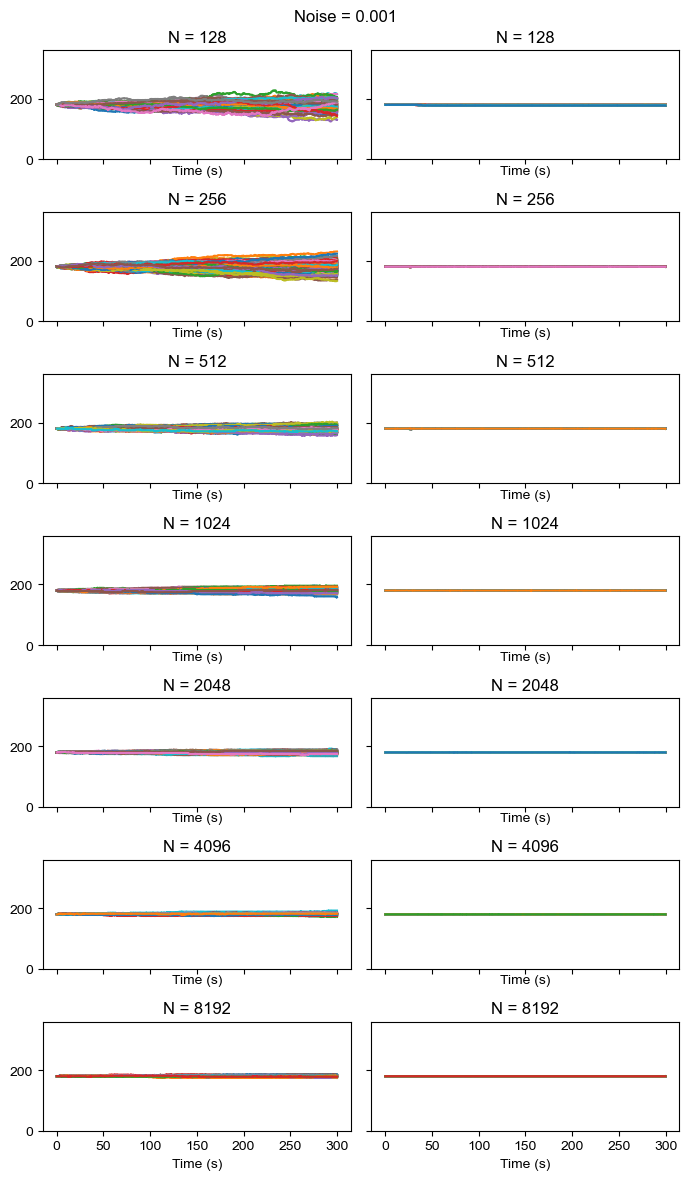

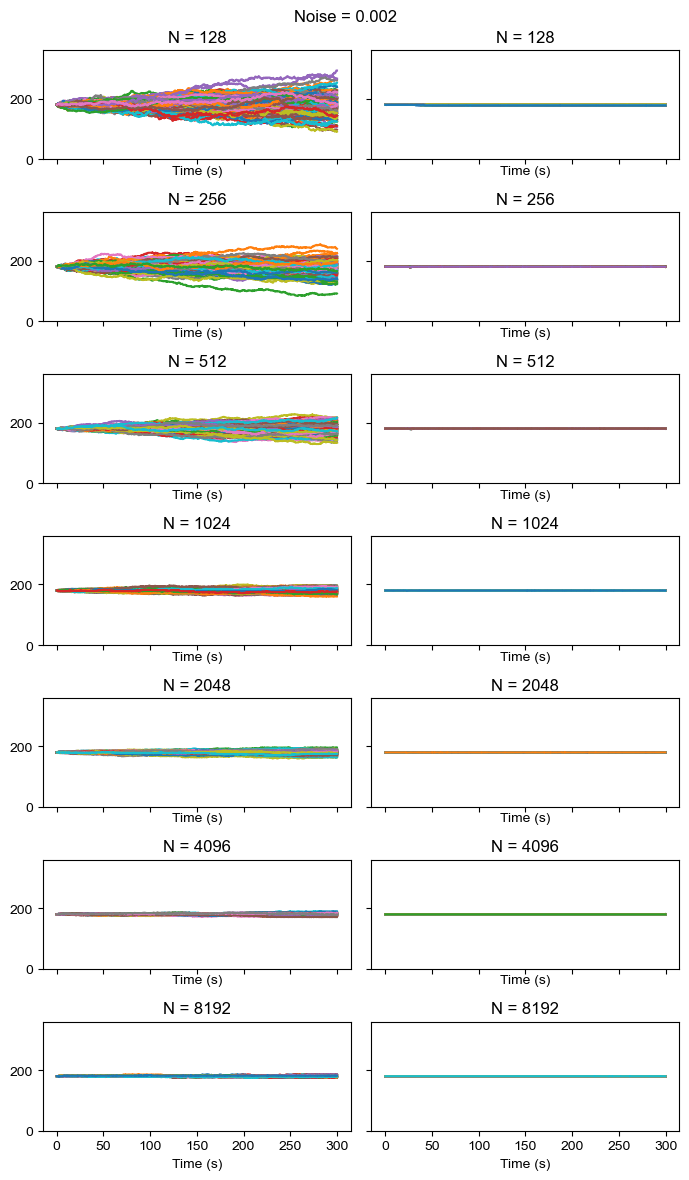

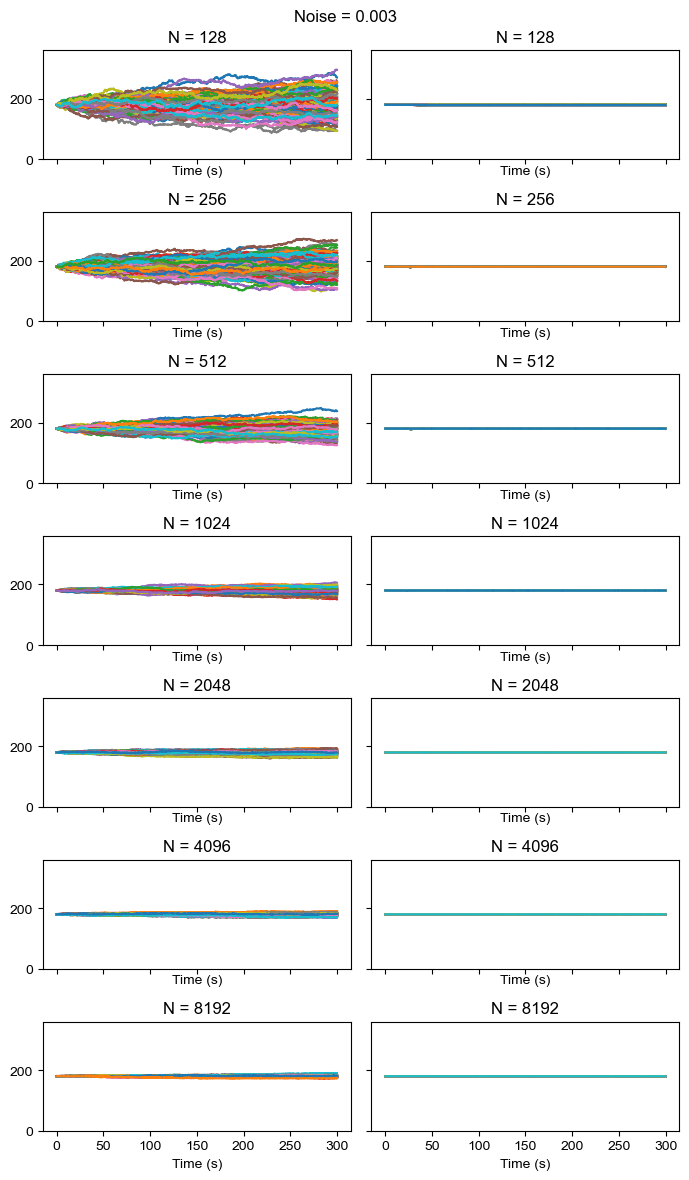

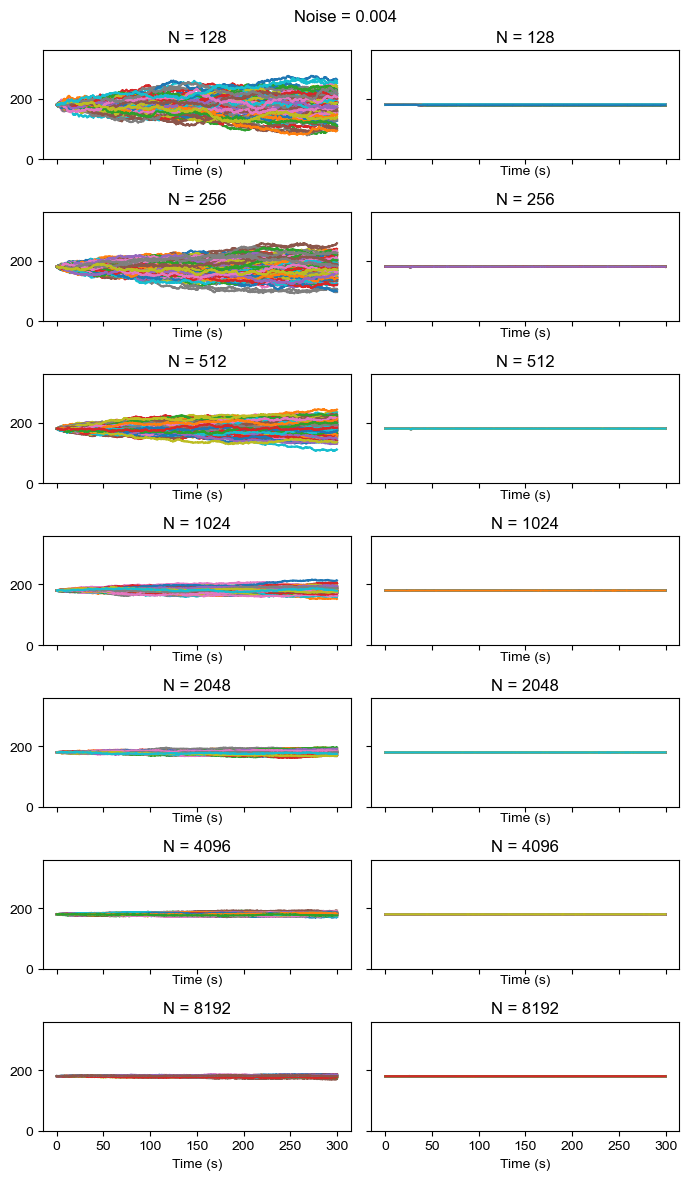

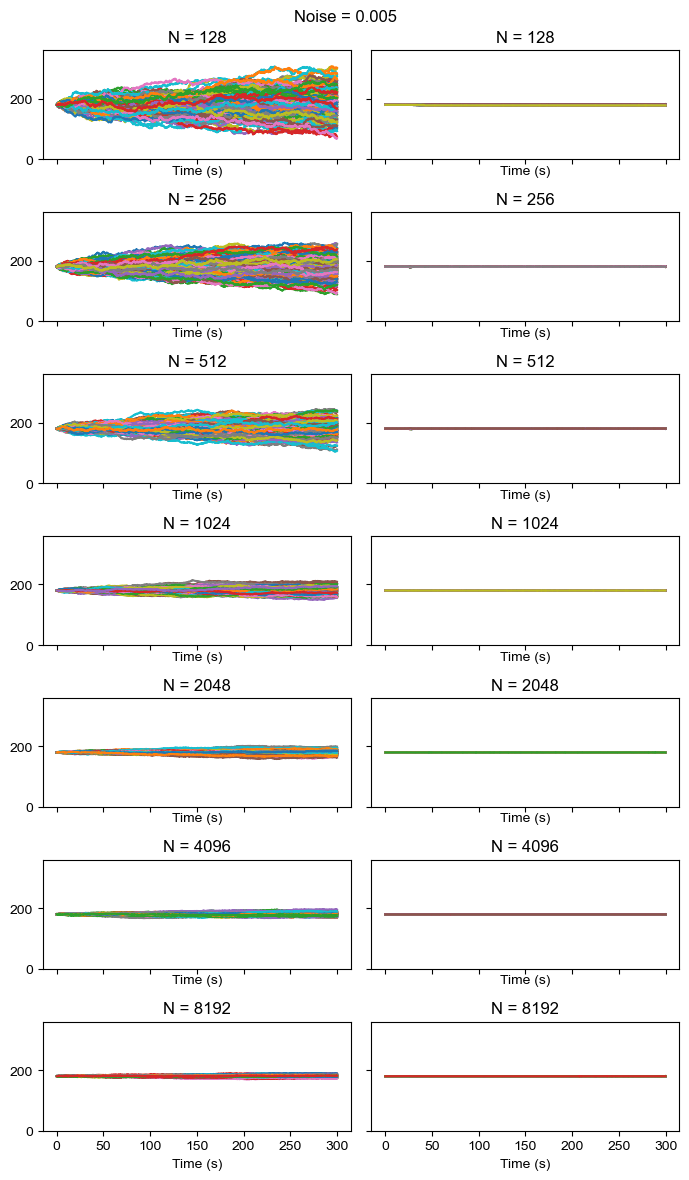

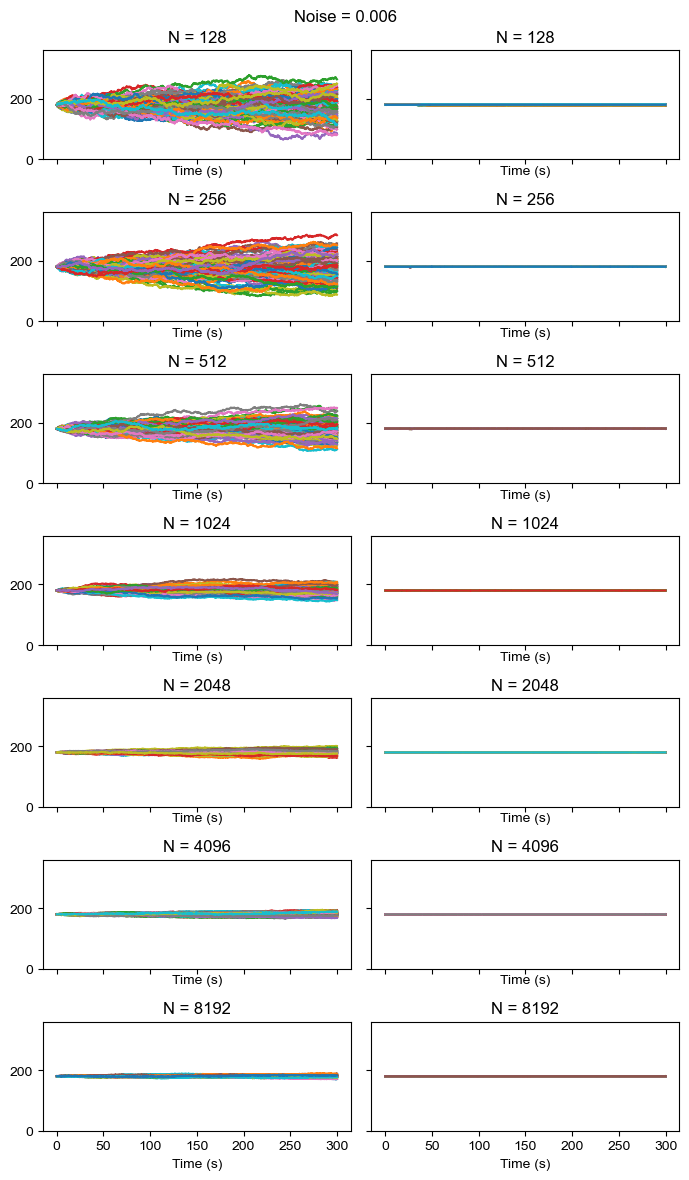

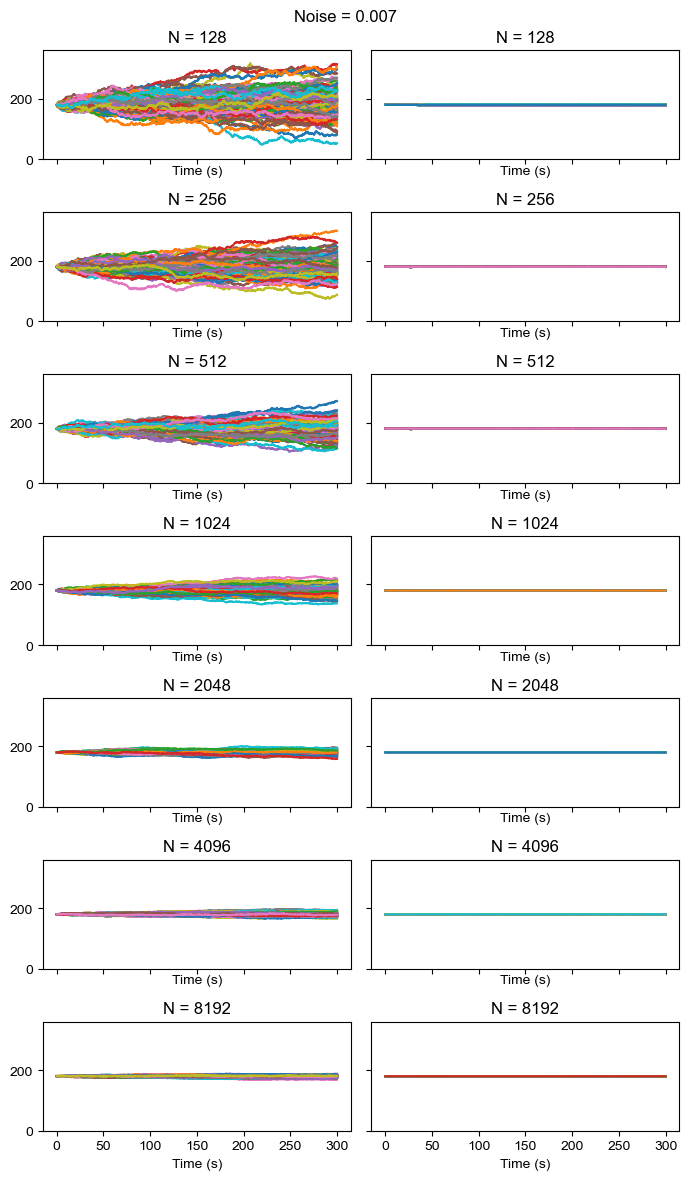

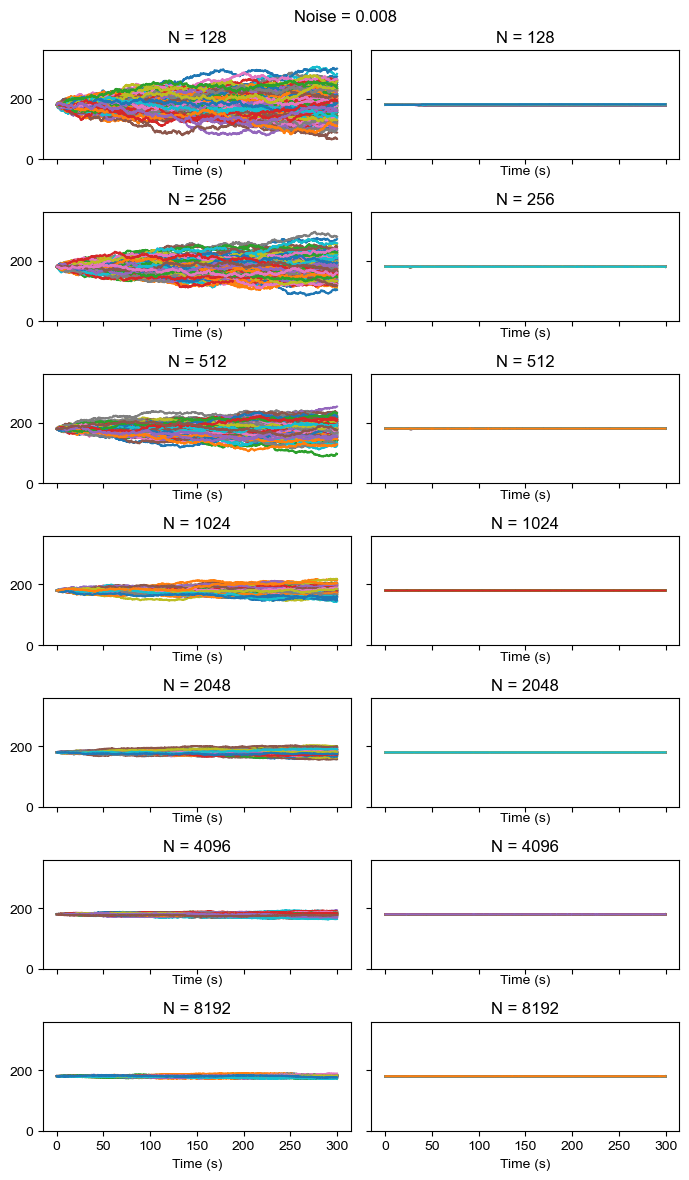

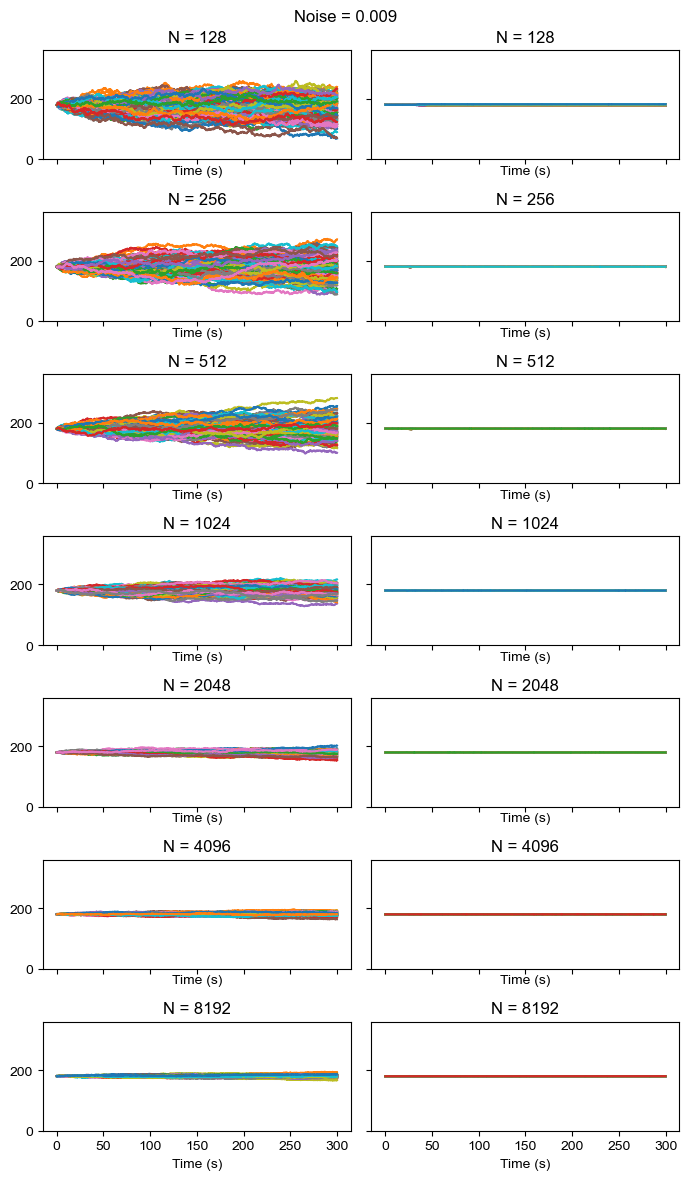

In [11]:
# Plot each experimental condition in separate plot

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(neurons_nums), ncols=2, figsize=(7, 12), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_j, indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']

            fig.suptitle('Noise = ' + str(poisson_neuron_noise))

            if plot_type == plot_types[0]: # Plot theta_ts_list
                for i, ts in enumerate(theta_ts_list):
                    ax.plot(t_snapshots, ts)
                    ax.set_title('N = ' + str(neurons_num))
                    ax.set_xlabel('Time (s)')
                    ax.set_ylim((0, 360))

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ax.plot(t_snapshots, theta_ts_abs_diff_std)
                ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

    fig.tight_layout()

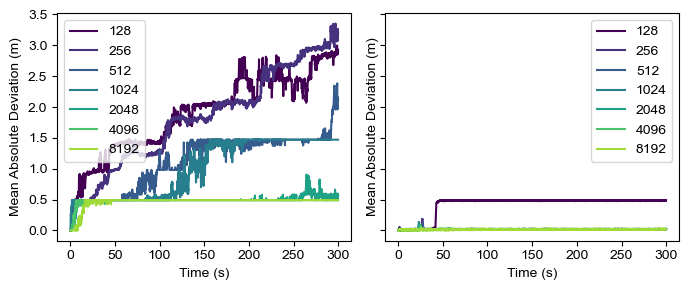

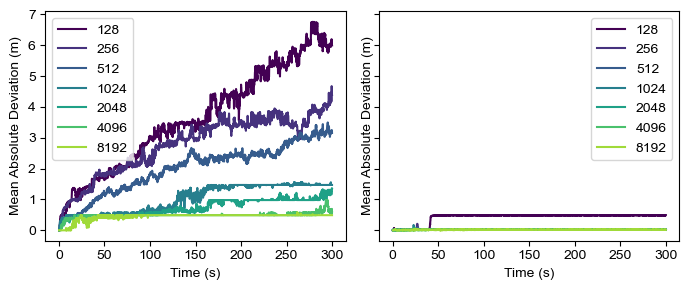

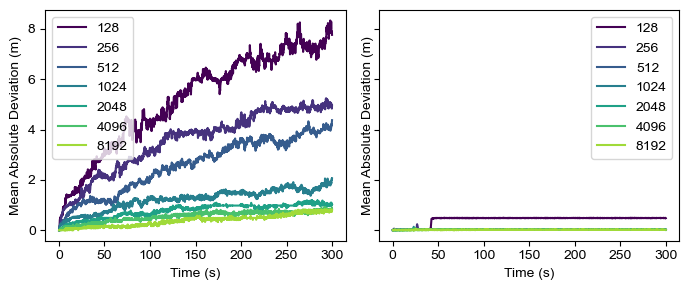

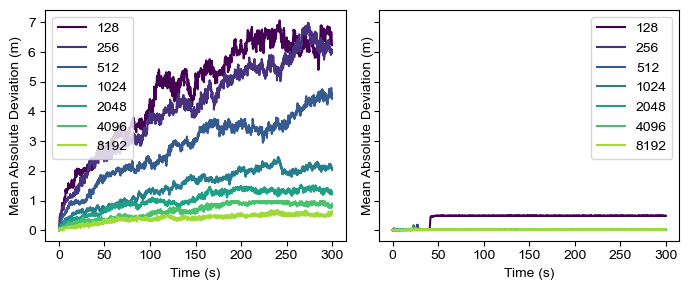

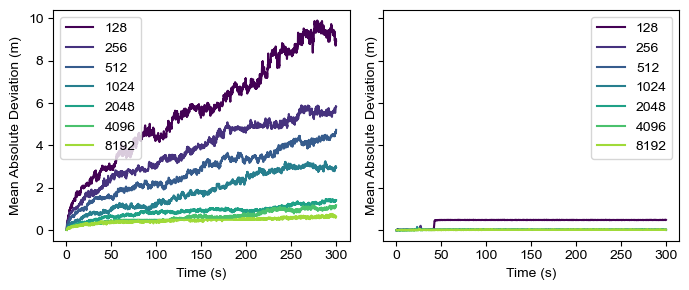

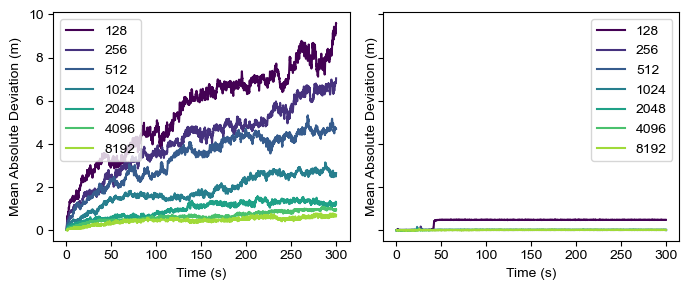

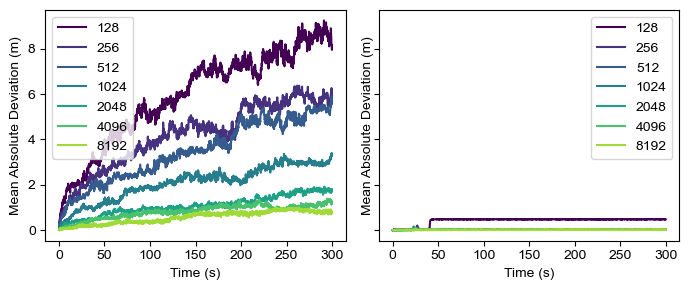

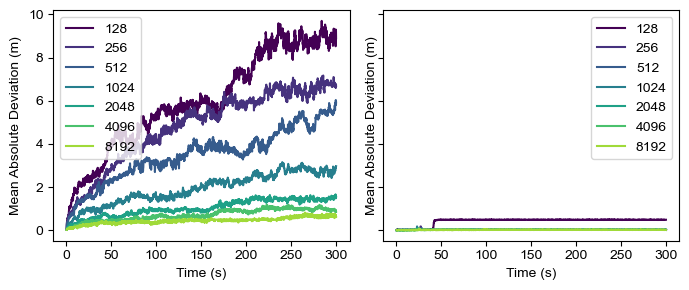

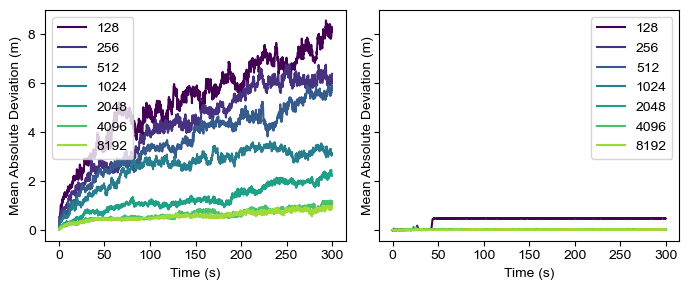

In [12]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

for poisson_neuron_noise in poisson_neuron_noises:
    if SAVE_PLOT:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=False)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('N = ' + str(neurons_num))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()
            #if indx_i == 1:
            #    ax.set_ylim([0, 0.04])
    fig.tight_layout()
    
    #if SAVE_PLOT:
    #    fig.savefig(os.path.join(figs_path, 'pub_effect_of_net_size_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
        

Noise = 0.005
N = 256
ts_list len =  249


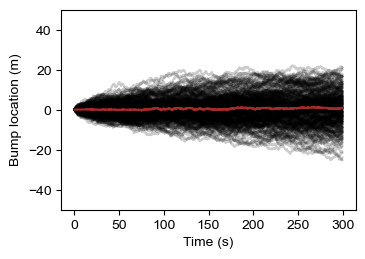

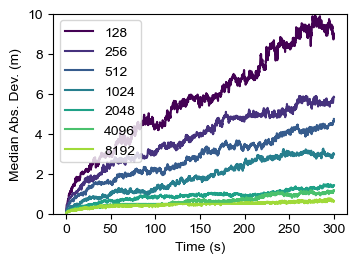

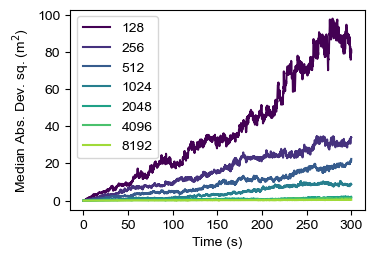

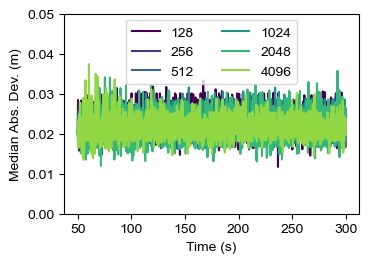

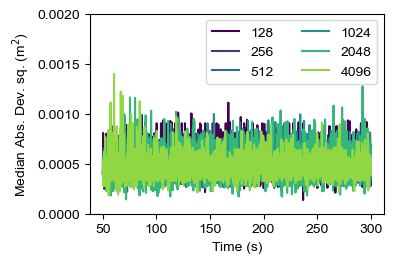

In [13]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

def plot_individual_traces(ax, data_dic, scale, plot_type, y_bias=0, xlabel='Time (s)', ylabel='y label', plot_traces_subset=None, colourscheme=None, colour=None, alpha=0.2, plot_median=False, colour_median='black', SAVE_PLOT=False):
    """
        plot_traces_subset : If None plot all traces, 
                             if an integer plot only the first as many traces [:plot_traces_subset], 
                             if a list of two items use it as a slice and plot the sliced traces.
    """
    # Get the list of theta recordings time series
    theta_ts_list = data_dic['theta_ts_list']
    t_snapshots = data_dic['t_snapshots']
    theta_ts_abs_diff_mean = data_dic['theta_ts_abs_diff_mean']
    theta_ts_abs_diff_std = data_dic['theta_ts_abs_diff_std']

    if colourscheme == 'viridis':
        viridis = plt.cm.get_cmap('viridis')

    # In this version there is not much point of using this option because it will plot all network sizes in the same plot
    if plot_type == 'theta': # Plot theta_ts_list
        ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
        if plot_traces_subset is not None:
            if isinstance(plot_traces_subset, int):
                ts_list = ts_list[:plot_traces_subset]
            elif isinstance(plot_traces_subset, list) and len(plot_traces_subset) == 2:
                ts_list = ts_list[slice(*plot_traces_subset)]
        for i, ts in enumerate(ts_list):
            if colourscheme == 'viridis': 
                colour = viridis(indx_j/len(neurons_nums))
                ax.plot(t_snaps/second, ts+y_bias, color=colour)
            else:
                ax.plot(t_snaps/second, ts+y_bias, color=colour, alpha=alpha)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
        print('ts_list len = ', len(ts_list))
        
        if plot_median:
            ax.plot(t_snaps/second, np.median(ts_list, axis=0)+y_bias, color=colour_median)


def plot_abs_diff_mean(ax, data_dic, scale, plot_type, neurons_nums, power=1, xlabel='Time (s)', ylabel='y label', plot_from_t=None, normalise_start=None, colourscheme=None, SAVE_PLOT=False):
    if colourscheme == 'viridis':
        viridis = plt.cm.get_cmap('viridis')
    
    dict_of_ts_list = {}
    list_of_colours = []
    
    # Get the list of theta recordings time series
    for indx_j, neurons_num in enumerate(neurons_nums):
        theta_ts_list = data_dic[neurons_num]['theta_ts_list']
        t_snapshots = data_dic[neurons_num]['t_snapshots']
        theta_ts_abs_diff_mean = data_dic[neurons_num]['theta_ts_abs_diff_mean']
        theta_ts_abs_diff_std = data_dic[neurons_num]['theta_ts_abs_diff_std']

        if plot_type == 'abs_diff_mean': # Plot theta_ts_abs_diff_mean
            ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=plot_from_t, normalise_start=normalise_start)
            if colourscheme == 'viridis': 
                colour = viridis(indx_j/len(neurons_nums))
                ax.plot(t_snaps/second, ts_list**power, label=str(neurons_num), color=colour)
            else: 
                ax.plot(t_snaps/second, ts_list**power, label=str(neurons_num))

        if plot_type == 'abs_diff_std': # Plot theta_ts_abs_diff_std
            ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=plot_from_t, normalise_start=normalise_start)
            if colourscheme == 'viridis': 
                colour = viridis(indx_j/len(neurons_nums))
                ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
            else:
                ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
        
        dict_of_ts_list[neurons_num] = ts_list
        list_of_colours.append(colour)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    
    return (t_snaps/second, dict_of_ts_list, list_of_colours)

models = ['NMDA', 'EC_LV_1']  # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009] # List of the neuron noise present in the collected recordings file
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

model = models[0]  # List of the neuron models present in the collected recordings file
poisson_neuron_noise = 0.005 # The neuron noise present in the collected recordings file
neurons_num = 256 # The network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']
tau = taus[0]
plot_traces_subset = None # None for plotting all traces, if a number plots that many first traces

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Plot unbiased bump location diffusion
print('Noise = ' + str(poisson_neuron_noise))
print('N = ' + str(neurons_num))
model = ['NMDA', 'EC_LV_1'][0]
data_dic = data[()][model][poisson_neuron_noise][tau][neurons_num]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][0]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_individual_traces(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, y_bias=-50, ylabel = 'Bump location (m)', plot_traces_subset=plot_traces_subset, colour='black', SAVE_PLOT=SAVE_PLOT, alpha=0.2, plot_median=True, colour_median='brown')
#ax.set_ylim([0, 100])
ax.set_ylim([-50, 50])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_bump_dispersion_traces_range100m' + '_neurons' + str(neurons_num) + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)

# Plot error accumulation (MofAD) due to bump location diffusion for the canonical (NMDA) neuron model
model = ['NMDA', 'EC_LV_1'][0]
data_dic = data[()][model][poisson_neuron_noise][tau]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][1]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, ylabel = 'Median Abs. Dev. (m)', colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
ax.set_ylim([0, 10])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_net_size_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)

# Plot error accumulation (MofAD^2) due to bump location diffusion for the canonical (NMDA) neuron model
model = ['NMDA', 'EC_LV_1'][0]
data_dic = data[()][model][poisson_neuron_noise][tau]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][1]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, power=2, ylabel = 'Median Abs. Dev. sq. (m$^2$)', colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
#ax.set_ylim([0, 10])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_net_size_on_dispersion_squared_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)

# Plot error accumulation (MofAD) due to bump location diffusion for the persistent activity neuron model
model = ['NMDA', 'EC_LV_1'][1]
data_dic = data[()][model][poisson_neuron_noise][tau]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][1]
neurons_nums = [128, 256, 512, 1024, 2048, 4096] # List of the network sizes present in the collected recordings file
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, ylabel = 'Median Abs. Dev. (m)', plot_from_t=50*second, normalise_start=0.02, colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
#ax.set_ylim([0, 10])
ax.set_ylim([0, 0.1])
ax.set_ylim([0, 0.05])
ax.legend(ncol=2)

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_net_size_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


# Plot error accumulation (MofAD^2) due to bump location diffusion for the persistent activity neuron model
model = ['NMDA', 'EC_LV_1'][1]
data_dic = data[()][model][poisson_neuron_noise][tau]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][1]
neurons_nums = [128, 256, 512, 1024, 2048, 4096] # List of the network sizes present in the collected recordings file
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, power=2, ylabel = 'Median Abs. Dev. sq. (m$^2$)', plot_from_t=50*second, normalise_start=0.02, colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
#ax.set_ylim([0, 10])
#ax.set_ylim([0, 0.1])
ax.set_ylim([0, 0.002])
ax.legend(ncol=2)

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_net_size_on_dispersion_squared_range100m' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


In [14]:
neurons_nums = [128, 256, 512, 1024, 2048, 4096, 8192] # List of the network sizes present in the collected recordings file
results_data = {}
for poisson_neuron_noise in poisson_neuron_noises:
    # Collect data for plot
    results_data[poisson_neuron_noise] = dict()
    print()
    print('Noise = ' + str(poisson_neuron_noise))
    for indx_i, model in enumerate(models):
        print()
        print(model + ' neuron model')
        print('=====================')
        trials_dict = data[()][model][poisson_neuron_noise][tau]
        trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict, neurons_nums, start_time=30, end_time=270, percentage=False, exponent=1)
        print('---------------------')
        print('Not scaled output')
        print('---------------------')
        print_theta_mean_absolute_deviation_rate(trials_dict_ammended, neurons_nums, plot_key_str='Neurons', plot_key_units='number')
        #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, neurons_nums, plot_key_str='Noise', plot_key_units='(1/SNR)')
        print('---------------------')
        print('Scaled output')
        print('---------------------')
        print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, neurons_nums, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

        # Collect data for plot
        results_data[poisson_neuron_noise][model] = dict()
        results_data[poisson_neuron_noise][model]['x'] = []
        results_data[poisson_neuron_noise][model]['y'] = []
        for neurons_num in neurons_nums:
            results_data[poisson_neuron_noise][model]['x'].append(neurons_num)
            results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[neurons_num]['theta_mean_absolute_deviation_rate'])



Noise = 0.001

NMDA neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
    128 0.04235125379745647
    256 0.042099057651237164
    512 0.025639715319345342
   1024 0.02396180431559887
   2048 0.010012847104839647
   4096 0.009694276793251107
   8192 0.009692813253790731
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
    128 0.01176423716596013
    256 0.011694182680899213
    512 0.007122143144262596
   1024 0.006656056754333019
   2048 0.002781346418011013
   4096 0.0026928546647919742
   8192 0.002692448126052981

EC_LV_1 neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
    128 0.009420008564140929
    256 0.0003627068185806331
    512 0.000363064576385108
   1024 0.0003727718156738018
   2048 0.0003670565700337713
   4096 0.00036978613308323956
   8192 0.0003592114064130146
---------------------
Scaled output

Original Slopes
128 0.0017777777777777779
256 0.0035555555555555557
512 0.0071111111111111115
1024 0.014222222222222223
2048 0.028444444444444446
4096 0.05688888888888889
8192 0.11377777777777778
New MAD^2 Slopes
[[0.26999098]
 [0.11125096]
 [0.06131554]
 [0.03001908]
 [0.00560604]
 [0.00332883]
 [0.00144598]]
New MAD Slopes
[[0.02609613]
 [0.01524123]
 [0.01172964]
 [0.01044731]
 [0.00233359]
 [0.00270498]
 [0.00103689]]
New MAD Slopes whole range
New MAD Slopes from function are wrong
128 0.13113897989422812
256 0.08752298487894858
512 0.06352527041546734
1024 0.0439713546177973
2048 0.019317616173868162
4096 0.014419510640518631
8192 0.01003430364386541


Text(0.5, 1.0, 'New MAD Slopes from function are wrong')

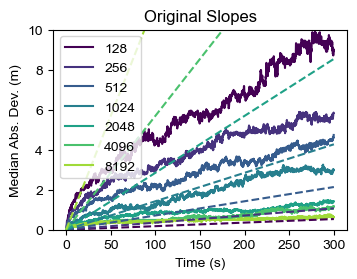

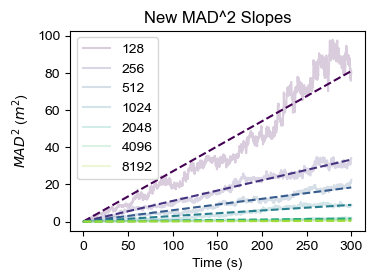

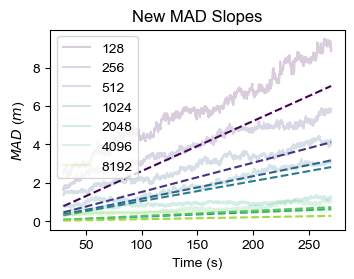

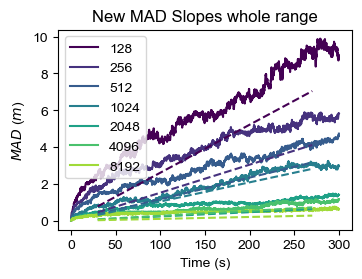

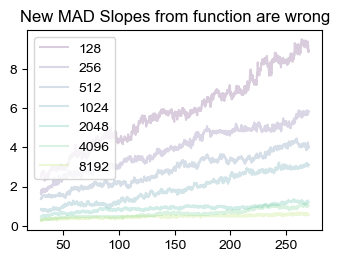

In [15]:
poisson_neuron_noise = 0.005

model = ['NMDA', 'EC_LV_1'][0]
data_dic = data[()][model][poisson_neuron_noise][tau]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][1]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
t_snaps, dict_of_ts_list, list_of_colours = plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, ylabel = 'Median Abs. Dev. (m)', colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
ax.set_ylim([0, 10])

range_max = 360
range_max_new = 100
y2 = np.array(results_data[poisson_neuron_noise][model]['y'])
z2 = np.array(results_data[poisson_neuron_noise][model]['x'])
y2 = scale_circ_to_line(z2, scale=[(0, range_max), (0, range_max_new)]) / 20000

print('Original Slopes')
for i, neurons_num in enumerate(neurons_nums):
    print(z2[i], y2[i])

# Curve fits
viridis = plt.cm.get_cmap('viridis')
for indx_j, neurons_num in enumerate(neurons_nums):
    x3 = np.linspace(0, 300) 
    y3 = x3 * y2[indx_j]
    colour = viridis(indx_j/len(neurons_nums))
    ax.plot(x3, y3, color=list_of_colours[indx_j], linestyle='--')
ax.set_title('Original Slopes')
    
    
print('New MAD^2 Slopes')
fig = plt.figure(figsize=figsize)
ax = plt.gca()

MAD2_ar = np.empty((len(dict_of_ts_list),len(t_snaps)))
N_ar = np.empty(len(dict_of_ts_list))
for i,key in enumerate(dict_of_ts_list):
    value = dict_of_ts_list[key]
    MAD2_ar[i] = value**2
    N_ar[i] = key
    #ax.plot(t_snaps, MAD2_ar[i], label=int(N_ar[i]), color=list_of_colours[i])
#ax.set_ylim([0, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('$MAD^2$ ($m^2$)')

slopes = calculate_slopes1(t_snaps, MAD2_ar)
print(slopes)

for i in range(len(dict_of_ts_list)):
    ax.plot(t_snaps,MAD2_ar[i],label=int(N_ar[i]),color=list_of_colours[i],alpha=0.2)
    ax.plot(t_snaps,t_snaps*slopes[i],color=list_of_colours[i], linestyle='--')
ax.legend()
ax.set_title('New MAD^2 Slopes')
slopes_MAD2 = slopes


print('New MAD Slopes')
fig = plt.figure(figsize=figsize)
ax = plt.gca()

# Keep the middle 80% of the samples
exclude_N = int(len(t_snaps) * 0.8 / 2)
t_snaps_subset = t_snaps[exclude_N:len(t_snaps)-exclude_N]
start_time = 30
end_time = 270
index_start_time = np.argmax(t_snaps >= start_time)
index_end_time = np.argmin(t_snaps <= end_time)
t_snaps_subset = t_snaps[index_start_time:index_end_time]
        
MAD_ar = np.empty((len(dict_of_ts_list),len(t_snaps_subset)))
N_ar = np.empty(len(dict_of_ts_list))
for i,key in enumerate(dict_of_ts_list):
    value = dict_of_ts_list[key]
    #MAD_ar[i] = value[exclude_N:len(t_snaps)-exclude_N]
    MAD_ar[i] = value[index_start_time:index_end_time]
    N_ar[i] = key
    #ax.plot(t_snaps, MAD2_ar[i], label=int(N_ar[i]), color=list_of_colours[i])
#ax.set_ylim([0, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('$MAD$ ($m$)')

from sklearn.linear_model import LinearRegression

# (*, fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False)[source]

lr = LinearRegression(fit_intercept=True)
# print(times.reshape(-1,1).shape, MAD2.shape)
lr_fitted = lr.fit(t_snaps_subset.reshape(-1,1),MAD_ar.T)

slopes = lr_fitted.coef_

print(slopes)

for i in range(len(dict_of_ts_list)):
    ax.plot(t_snaps_subset,MAD_ar[i],label=int(N_ar[i]),color=list_of_colours[i],alpha=0.2)
    ax.plot(t_snaps_subset,t_snaps_subset*slopes[i],color=list_of_colours[i], linestyle='--')
ax.legend()
ax.set_title('New MAD Slopes')
slopes_MAD = slopes

print('New MAD Slopes whole range')
fig = plt.figure(figsize=figsize)
ax = plt.gca()
t_snaps, dict_of_ts_list, list_of_colours = plot_abs_diff_mean(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, neurons_nums=neurons_nums, ylabel = 'Median Abs. Dev. (m)', colourscheme='viridis', SAVE_PLOT=SAVE_PLOT)
for i in range(len(dict_of_ts_list)):
    ax.plot(t_snaps_subset,t_snaps_subset*slopes[i],color=list_of_colours[i], linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('$MAD$ ($m$)')
ax.legend()
ax.set_title('New MAD Slopes whole range')


fig = plt.figure(figsize=figsize)
ax = plt.gca()
print('New MAD Slopes from function are wrong')
for i, neurons_num in enumerate(neurons_nums):
    print(results_data[poisson_neuron_noise][model]['x'][i], 
    results_data[poisson_neuron_noise][model]['y'][i])
#    slopes[i] = results_data[poisson_neuron_noise][model]['y'][i]
    
for i in range(len(dict_of_ts_list)):
    ax.plot(t_snaps_subset, MAD_ar[i],label=int(N_ar[i]), color=list_of_colours[i], alpha=0.2)
#    ax.plot(t_snaps_subset, t_snaps_subset*slopes[i], color=list_of_colours[i], linestyle='--')
ax.legend()
ax.set_title('New MAD Slopes from function are wrong')


Max tolerable drift rate 0.343m/h (9.527777777777779e-05m/s)
Optimal parameters
N=(1/D)*a, [a] = [12.14076172]
R^2 = 0.9851527777420793
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 127425 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [12.14076172]
R^2 = 0.9851527777420793
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 127425 excitatory neurons


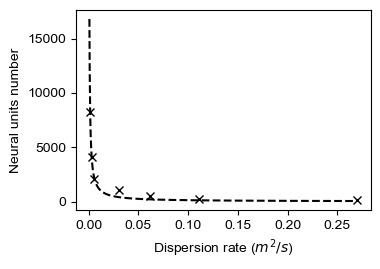

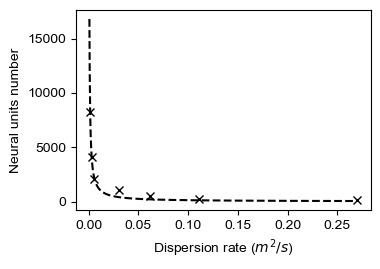

In [16]:
# This fits the straightened MAD curves from above so it fits to the calculations 
# of slope that used the MAD^2 data which seems more appropriate. So it fits the 
# the N = a * 1/D where D is in m^2/s.

# Using the above fitted slopes that now are correct as plotted above.
# Now the required numebr of neurons is 700 million instead of 500 milliion.

# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD instead or variance, the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus we have D_{MAD} ~ D_{SD} = \sqrt{D_{VAR}} = \sqrt{\frac{1}{N}a} [m/s] => N = \reac{1}{(D_{SD})^2}a [unitless]
# Thus fit N=(1/D^2)*a=y=((1/x^2)*a) to the ant data points.
# Drift rate MAD/s in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
# condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
# if condition == 1:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.01 # 1% => 1m/100m
# if condition == 2:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

# drift_max = drift_max_percent * range_max_new
drift_max = 0.343 # m2/hour
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y


def func_inv_invprop(D, a):
    """ y=1/x^2*a function """
    #y = a * np.exp(-b*x) + c
    #y = (1/x) * a * (1 / (1-b))
    N=(1/D**1)*a
    return N
func_inv_invprop_str = 'N=(1/D)*a, [a] = {}'

func_fit = func_inv_invprop

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    
    x = slopes_MAD2.flatten() # Dispertion MAD
    y = N_ar # Neurons number
    #x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD
    
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    
    params, conv  = curve_fit(func_fit, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    #print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    print(func_inv_invprop_str.format(params))

    # Calculate fitted curve prediction
    y_prime = func_fit(x, params[0])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    y_req = func_fit(x_req, params[0])
    print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    max_lim = np.max(x)
    min_lim = x_req
    min_lim = 0.001
    min_lim = np.min(x) - np.min(x)*0.5
    x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_fit(x_prime, params[0])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    #plt.xlabel('Drift rate (m/s)')
    plt.xlabel('Dispersion rate ($m^2/s$)')
    plt.ylabel('Neural units number')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        #plt.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
    

## Bootstrap the error for the required number of neurons

In [17]:
# Package the data for bootstrapping
# Calculate the absolute deviations for each trial separately over time
# data_trials_abs_dev is a dict with structure eg {"256": array[trials, t], "512": array[trials, t], etc}
model = models[0]                               # Choose neuron model in the collected recordings file
poisson_neuron_noise = 0.005                    # Choose neuron noise level in the collected recordings file
tau = taus[0]                                   # Choose time constant 'complex' in this case
print('model = {}, poisson_neuron_noise = {}, tau = {}'.format(model, poisson_neuron_noise, tau))
data_trials_abs_dev = {}
data_trials_msq_dev = {}
for indx_j, neurons_num in enumerate(neurons_nums): # For each network size
    data_trials_abs_dev[neurons_num] = np.abs(180 - np.array(data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list'])) # Calculate the absolute deviations from 180deg
    data_trials_msq_dev[neurons_num] = (180 - np.array(data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']))**2 # Calculate the mean-squared deviations from 180deg

print('data_trials_abs_dev contains the absolute deviation per trial per time step for each network size.')

model = NMDA, poisson_neuron_noise = 0.005, tau = complex
data_trials_abs_dev contains the absolute deviation per trial per time step for each network size.


Text(0, 0.5, 'Slope m2/s')

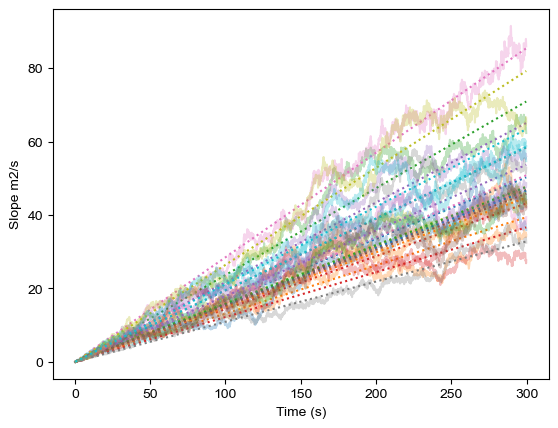

In [18]:
# Test the process with one case N=2048
# construct ensembles for one case N=2048
x2_ens = construct_ensembles(data_trials_msq_dev[2048], ensemble_size = 40, N_ensembles = 20)

# calculate slopes
slopes = calculate_slopes(t_snaps, x2_ens)

## plot results for one case N=2048
#for i,x2 in enumerate(x2_ens):
#  plt.plot(x2,c=f'C{i}', alpha=0.3)
#  plt.plot(t_snaps[::100],t_snaps[::100]*slopes[i],linestyle=':',c=f'C{i}')

fig = plt.figure()
# plot results for one case N=2048
for i,x2 in enumerate(x2_ens):
    plt.plot(t_snaps, x2, c=f'C{i}', alpha=0.3)
    #plt.plot(t_snaps[::100],t_snaps[::100]*slopes[i],linestyle=':',c=f'C{i}')
    plt.plot(t_snaps,t_snaps*slopes[i],linestyle=':',c=f'C{i}')
plt.xlabel('Time (s)')
plt.ylabel('Slope m2/s')

{128: array([6.65870526, 5.14336148, 5.73319178, 6.19152189, 5.63717018,
        6.50003866, 7.56524431, 6.04435329, 7.41933126, 6.39802461,
        6.89004266, 6.28850984, 6.87752673, 6.41137348, 6.12750278,
        7.51527482, 7.2898696 , 7.34864648, 6.58537886, 6.85314763,
        6.99146067, 7.26378276, 6.80917967, 7.33834031, 6.11025511,
        6.8693215 , 6.28079218, 6.62729344, 6.83945471, 6.49632741,
        7.21108966, 7.08585568, 6.02502699, 8.81112073, 7.71641137,
        7.15476438, 7.32931981, 5.89334156, 7.43165842, 8.13025714]),
 256: array([3.59079405, 3.81265679, 3.26145829, 3.41880515, 3.30518305,
        3.00384765, 2.71184963, 3.38075099, 3.69334362, 2.98860023,
        3.30031143, 3.325246  , 2.7984009 , 3.18070474, 3.50561374,
        4.22127735, 3.41946583, 3.85162809, 3.70221921, 3.77918543,
        2.70624978, 3.69269098, 2.95497455, 3.31174707, 3.16639503,
        3.96671856, 2.51379453, 2.9769096 , 3.64226833, 3.17125976,
        3.18726873, 2.92059368, 3.70

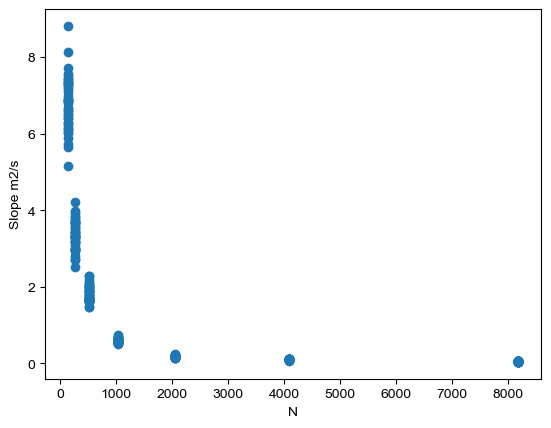

In [19]:
# Calculate the slopes using bootstrapping for all data
slopes = {}
list2plot = [] 
for k in data_trials_abs_dev.keys():
    x2_ens = construct_ensembles(data_trials_msq_dev[k], 
                                 ensemble_size = 100, 
                                 N_ensembles = 40)
    slopes[k] = calculate_slopes(t_snaps, x2_ens)
    for slope in slopes[k]:
        list2plot.append([k,slope])
plt.scatter(*np.array(list2plot).T)
plt.xlabel('N')
plt.ylabel('Slope m2/s')
slopes

### This uses slopes_MAD2 which were calculated earlier without bootstrapping and does bootstrap by removing one of the 6 points in each iteration. 

In [20]:
# This fits the straightened MAD curves from above so it fits to the calculations 
# of slope that used the MAD^2 data which seems more appropriate. So it fits the 
# the N = a * 1/D where D is in m^2/s.

# Using the above fitted slopes that now are correct as plotted above.
# Now the required numebr of neurons is 700 million instead of 500 milliion.

# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD instead or variance, the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus we have D_{MAD} ~ D_{SD} = \sqrt{D_{VAR}} = \sqrt{\frac{1}{N}a} [m/s] => N = \reac{1}{(D_{SD})^2}a [unitless]
# Thus fit N=(1/D^2)*a=y=((1/x^2)*a) to the ant data points.
# Drift rate MAD/s in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
# condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
# if condition == 1:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.01 # 1% => 1m/100m
# if condition == 2:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

# drift_max = drift_max_percent * range_max_new
drift_max = 0.343 # m2/hour
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}$m^2/h$ ({}$m^2/s$)'.format(drift_max, drift_rate_max))

func_inv_invprop_str = 'N=(1/D)*a, [a] = {}'

func_fit = func_inv_invprop

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

fig = plt.figure(figsize=figsize)

x_raw = slopes_MAD2.flatten() # Dispertion MAD
y_raw = N_ar # Neurons number
#x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD

y_reqs = []

for i in range(len(x_raw)): # Leave-one-out cycle
    mask = np.ones_like(x_raw)
    mask[i] = 0
    x = x_raw[mask==1]
    y = y_raw[mask==1]

    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]

    params, conv  = curve_fit(func_fit, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    #print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    print(func_inv_invprop_str.format(params))

    # Calculate fitted curve prediction
    y_prime = func_fit(x, params[0])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    y_req = func_fit(x_req, params[0])
    print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    y_reqs.append(y_req)

y_reqs = np.array(y_reqs)

Max tolerable drift rate 0.343$m^2/h$ (9.527777777777779e-05$m^2/s$)
Optimal parameters
N=(1/D)*a, [a] = [12.14025069]
R^2 = 0.983493337831063
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 127420 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [12.13856775]
R^2 = 0.9840320861210441
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 127402 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [12.13224862]
R^2 = 0.9860269351798663
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 127336 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [12.1064032]
R^2 = 0.9922951774260631
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 127064 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [12.1775832]
R^2 = 0.9854106126575514
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 127811 excitatory neurons
Optimal parameters
N=(1/D)*a,

<Figure size 380x260 with 0 Axes>

In [21]:
# Required number of neurons calculated as the mean and SD of leaving one sample out each time (bootstrap?)
print('Mean, SD required number of neurons:', (y_reqs.mean(),y_reqs.std()))

Mean, SD required number of neurons: (128730.80387006549, 4472.017045879654)


## Gaussian process fit

Text(0.5, 1.0, 'Problem: noise in est. of D decreases with the increase of N')

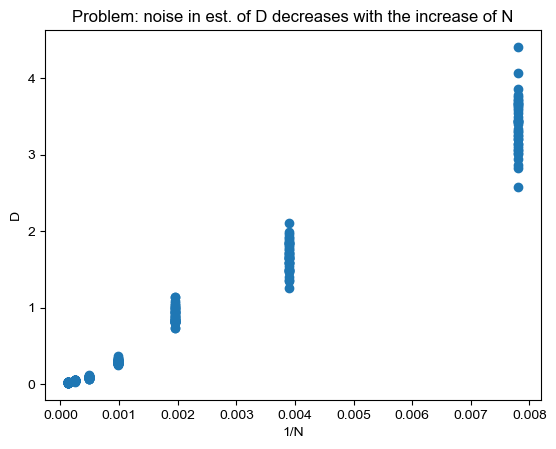

In [22]:
x_raw, y_raw = np.array(list2plot).T

plt.scatter(1/x_raw, y_raw/2)
plt.xlabel('1/N')
plt.ylabel('D')

plt.title('Problem: noise in est. of D decreases with the increase of N')

In [23]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Sum, RBF, WhiteKernel, DotProduct, Exponentiation
# kernel = Sum(RBF(length_scale=1000), WhiteKernel(noise_level=.1,))
kernel = DotProduct(sigma_0=10)
# Exponentiation(DotProduct(sigma_0=.1),1/2)

x_raw, y_raw = np.array(list2plot).T
x_raw = np.log(1/x_raw) / np.log(10)
y_raw = np.log(y_raw/2) / np.log(10) # /2 because of the 2 in the Einstein's law

gpr = GaussianProcessRegressor(kernel=kernel,random_state=0,normalize_y=True,\
                               alpha=1).fit(
    x_raw.reshape(-1, 1), 
    y_raw.reshape(-1, 1))

[0.29896763 0.29526934 0.29157214 0.28787609 0.28418121 0.28048757
 0.2767952  0.27310417 0.26941452 0.26572631 0.26203961 0.25835448
 0.25467098 0.25098919 0.24730919 0.24363105 0.23995486 0.23628072
 0.23260871 0.22893895 0.22527154 0.2216066  0.21794425 0.21428462
 0.21062787 0.20697414 0.20332358 0.19967639 0.19603274 0.19239284
 0.1887569  0.18512516 0.18149787 0.17787529 0.17425774 0.17064551
 0.16703897 0.16343849 0.15984446 0.15625736 0.15267765 0.14910587
 0.1455426  0.1419885  0.13844425 0.13491065 0.13138854 0.12787888
 0.12438273 0.12090124 0.11743574 0.11398766 0.11055866 0.10715055
 0.1037654  0.10040552 0.09707355 0.09377246 0.09050562 0.08727688
 0.08409063 0.08095189 0.07786641 0.07484077 0.07188253 0.06900035
 0.06620417 0.06350536 0.06091686 0.05845331 0.05613119 0.05396874
 0.05198589 0.05020393 0.04864494 0.04733097 0.04628287 0.04551903
 0.0450539  0.04489677 0.04505085 0.045513   0.04627397 0.04731936
 0.04863083 0.05018751 0.05196739 0.05394837 0.05610916 0.0584

Text(0, 0.5, 'log D')

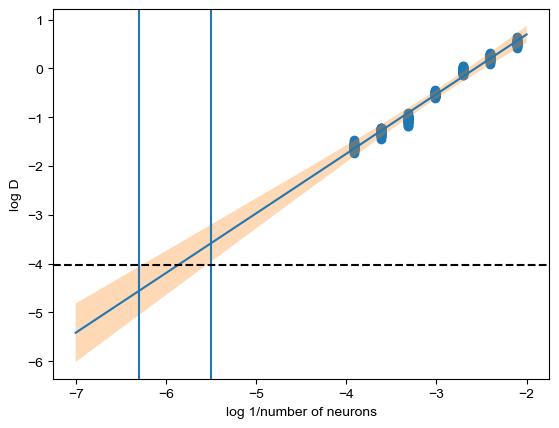

In [24]:
# prediction for training points

# x_plot = np.concatenate([x_raw,[x_req]])
x_plot = np.linspace(-7,-2,100)
mean, std = gpr.predict(x_plot.reshape(-1,1), return_std=True)

print(std)

plt.scatter(x_raw,y_raw)
plt.plot(x_plot,mean)
plt.fill_between(x_plot,
                 (mean.squeeze()-2*std), 
                 (mean.squeeze()+2*std),
                 alpha=0.3)
ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.axvline(-5.5)
plt.axvline(-6.3)
plt.axhline(np.log(x_req) / np.log(10),c='k',linestyle='dashed')
plt.xlabel('log 1/number of neurons')
plt.ylabel('log D')

### Fitting a GP for D ~ 1/N

In [25]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Sum, RBF, WhiteKernel, DotProduct,\
                                              Exponentiation, ConstantKernel
# kernel = Sum(RBF(length_scale=1000), WhiteKernel(noise_level=.1,))
kernel = Sum(ConstantKernel(), WhiteKernel(noise_level=.1,))

x_raw, y_raw = np.array(list2plot).T
x_raw = np.log(1/x_raw) / np.log(10)
y_raw = np.log(y_raw/2) / np.log(10) - x_raw # /2 because of the 2 in the Einstein's law

gpr = GaussianProcessRegressor(kernel=kernel,random_state=0,normalize_y=False,\
                               alpha=700).fit(
    x_raw.reshape(-1, 1), \
    y_raw.reshape(-1, 1))

1.4612845355433763 [1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375 1.21598375
 1.21598375 1.21598375 1.21598375 1.2159837

Text(0, 0.5, 'log D')

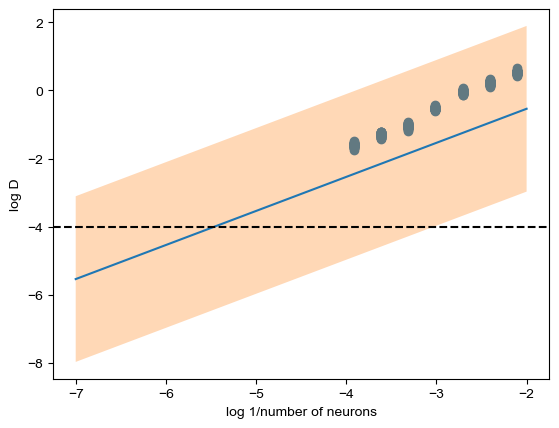

In [26]:
# prediction for training points

# x_plot = np.concatenate([x_raw,[x_req]])
x_plot = np.linspace(-7,-2,100)
mean, std = gpr.predict(x_plot.reshape(-1,1), return_std=True)

print(mean.squeeze()[0],std)

plt.scatter(x_raw,y_raw+x_raw)
plt.plot(x_plot,x_plot+mean.squeeze())
plt.fill_between(x_plot,
                 (x_plot+mean.squeeze()-2*std), 
                 (x_plot+mean.squeeze()+2*std),
                 alpha=0.3)
ax = plt.gca()
# ax.set_xscale('log')
# ax.set_yscale('log')
# plt.axvline(-5.02)
# plt.axvline(-5.4)
plt.axhline(np.log(x_req) / np.log(10),c='k',linestyle='dashed')
plt.xlabel('log 1/number of neurons')
plt.ylabel('log D')

## Try now to fit a line to D~1/N and calculate confidence intervals. This uses the slopes dict that were calculated using bootstrapping.

Optimal parameters
a*x + b, [a, b] = [-1.23873419  3.49053585]
R^2 = 0.9853334425001883


Text(0.5, 1.0, '4')

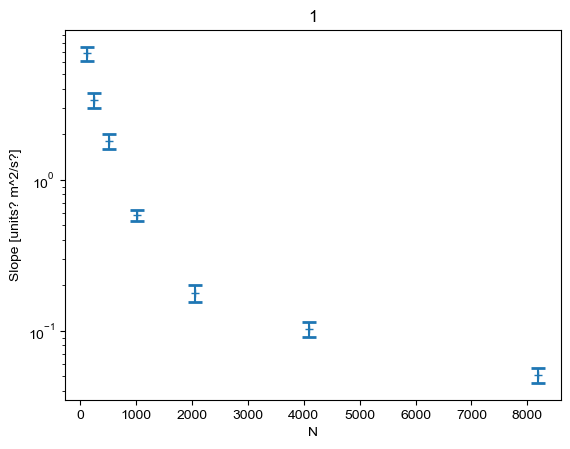

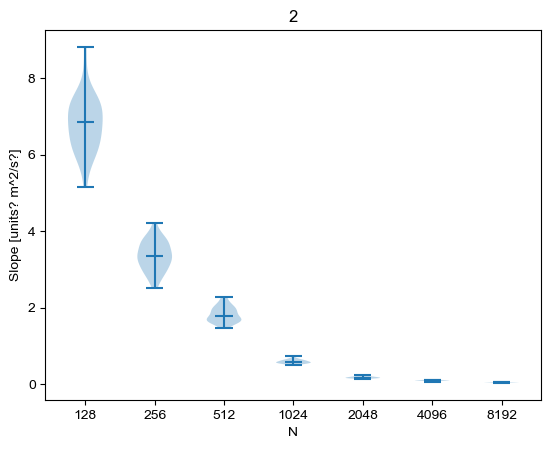

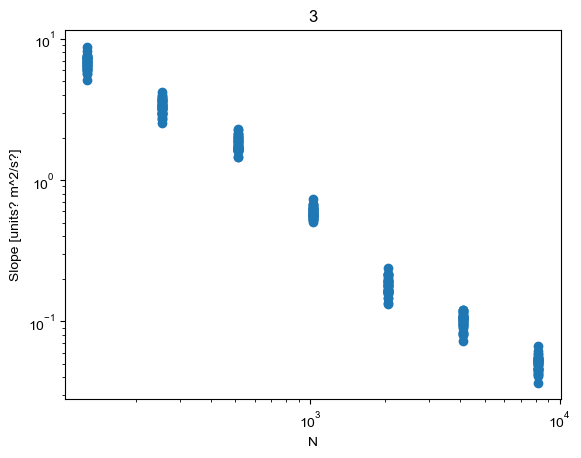

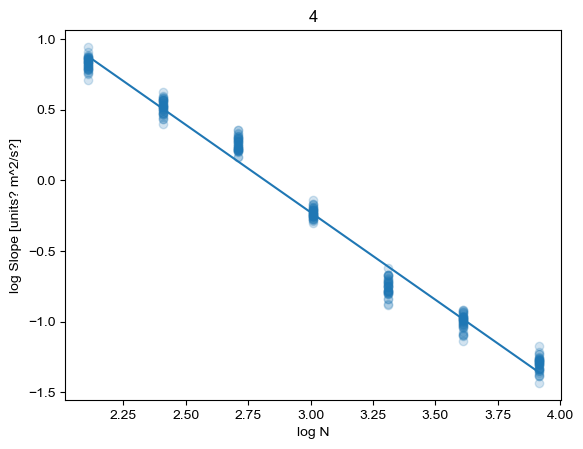

In [27]:
# Plot errorbars plot
slopes_keys = []
slopes_median = []
slopes_std = []
for k in slopes.keys():
    slopes_keys.append(k)
    slopes_median.append(np.median(slopes[k]))
    slopes_std.append(np.std(slopes[k]))

plt.figure()
plt.errorbar(slopes_keys, slopes_median, yerr=slopes_std, fmt='+', capsize=5, capthick=2)
plt.xlabel('N')
plt.ylabel('Slope [units? m^2/s?]')
#plt.xscale('log')
plt.yscale('log')
#plt.ylim([None, 1])
plt.title('1')

# Repack the data to plot violin plot
plt.figure()
slopes_array = np.empty((len(slopes.keys()), len(slopes[128])))
for i,k in enumerate(slopes.keys()):
    slopes_array[i] = slopes[k]
plt.violinplot(slopes_array.T, showmedians=True)
#plt.violinplot(slopes_array.T, positions = list(slopes.keys()), showmedians=True)
plt.xlabel('N')
plt.ylabel('Slope [units? m^2/s?]')
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(range(1, len(slopes.keys())+1), list(slopes.keys()))
#plt.ylim([None, 1])
plt.title('2')

# Repack the data, keys (number of nuerons N) and values (diffusion rates D) 
# into a 2D array.
# 'slopes' is a dictionary with numeric keys and values 1D numpy arrays. 
# The key values are the x value of the data points and the values in each numpy 
# array are the y values recorded for the same x value. 
N_s = []      # Holds the N value corresponding to each Diffusion value
slopes_s = [] # Holds the corresponding Diffusion values
for k in slopes.keys():
    N_s = N_s + [k]*len(slopes[k])            # Append to the list of N values
    slopes_s = np.append(slopes_s, slopes[k]) # Append the Diffusion values
N_s = np.array(N_s)    # Convert the list of N values to an array
one_over_N_s = 1 / N_s # Convert 1/N values
# The result of this section is the x values in the array N_s and the corresponding
# y values in the array slopes_s. 

# Plot a data histogram
plt.figure()
plt.scatter(N_s, slopes_s)
plt.xlabel('N')
plt.ylabel('Slope [units? m^2/s?]')
plt.xscale('log')
plt.yscale('log')
#plt.ylim([None, 1])
plt.title('3')

# Regress a line to the data points and plot it
# The relation of log(slopes_s) vs log(N_s) is linear therefore we 
# convert both x and y values to log_10()
log_N_s = np.log(N_s) / np.log(10)
log_slopes_s = np.log(slopes_s) / np.log(10)
# and then fit a line to the data points
N_prime, slopes_prime, params, r2 = regress(log_N_s, log_slopes_s, func_lin_1, params0=[1, 0], func_str = 'a*x + b, [a, b] = {}', x_range_min=None, x_range_max=None)
plt.figure()
plt.scatter(log_N_s, log_slopes_s, alpha=0.2)
plt.plot(N_prime, slopes_prime)
plt.xlabel('log N')
plt.ylabel('log Slope [units? m^2/s?]')
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim([None, 1])
plt.title('4')



## Use of bootstrapping to calculate the confidence intervals for the fit of line and D~1/N

Regressed line intercept (y = -x + b, b = ) mean+/-std = 2.7733201645595678 +/- 0.017392192294875368
R^2 = 0.9487318339895903
Number of neurons required mean=6232707.496822912, std=2287840.036409671


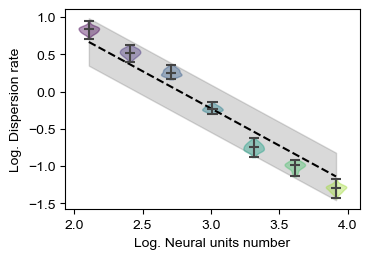

In [28]:
subsample_size=int(log_N_s.shape[0]*0.3)

# Create subsamples of data points
data_x_subsamples, data_y_subsamples = select_rand_subsample(log_N_s, 
                                                             log_slopes_s, 
                                                             subsample_size=subsample_size, 
                                                             N_subsamples=80)

# Calculate the slope for each subsample
func_fit = func_line_0
func_fit_str = func_line_0_str
fitted_intercepts_2 = calculate_slopes2(func_fit, data_x_subsamples, data_y_subsamples)
print('Regressed line intercept ({}) mean+/-std = {} +/- {}'.format(func_fit_str.format(''), np.mean(fitted_intercepts_2), np.std(fitted_intercepts_2)))

# R2 match score
r2 = r2_score(log_slopes_s, func_fit(log_N_s, np.mean(fitted_intercepts_2)))
print('R^2 = {}'.format(r2))

# Generate an x vector
x_prime = np.linspace(np.min(log_N_s), np.max(log_N_s))

# Max tolerable drift rate 0.343m/h (9.527777777777779e-05m/s)
y_req = 0.343 / 60 / 60
log_y_req = np.log(y_req) / np.log(10)
# Rearranged y = a*x + b => x = (y - b) / a
x_s_est = func_fit(np.array(log_y_req), fitted_intercepts_2)
print('Number of neurons required mean={}, std={}'.format(np.mean(10**x_s_est), 
                                                            np.std(10**x_s_est)*np.sqrt(subsample_size)))

# Plot with CI shade
# ==================
fig = plt.figure(figsize=figsize)

# Plot fitted line and shaded min max
fitted_intercepts_2_mean = np.mean(fitted_intercepts_2)
fitted_intercepts_2_std  = np.std(fitted_intercepts_2)*np.sqrt(subsample_size)

plt.fill_between(x=x_prime, 
                 y1=fitted_intercepts_2_mean-2*fitted_intercepts_2_std - x_prime, 
                 y2=fitted_intercepts_2_mean+2*fitted_intercepts_2_std - x_prime,
                 color='#444444', 
                 alpha=0.2)
plt.plot(x_prime, fitted_intercepts_2_mean - x_prime, linestyle='--', color='black')

# Plot violin
log_slopes_array = np.log(slopes_array) / np.log(10)
violin_parts = plt.violinplot(log_slopes_array.T, 
               positions=np.log(np.array(list(slopes.keys()))) / np.log(10), 
               showmedians=True,
               widths=0.15)

# Style the violin plot
# Make the violin body grey with a grey border:
for vp in violin_parts['bodies']:
    vp.set_facecolor('#444444')
    #vp.set_edgecolor('#444444')
    #vp.set_linewidth(1)
    vp.set_alpha(0.3)

# Make all the violin statistics marks grey:
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('#444444')
    #vp.set_linewidth(1)

if colourscheme == 'viridis':
    # Make the violin body grey with a grey border:
    for indx_j,vp in enumerate(violin_parts['bodies']):
        colour = viridis(indx_j/len(list(slopes.keys())))
        vp.set_facecolor(colour)
        vp.set_edgecolor(colour)
        vp.set_alpha(0.4)

# Plot a scatter plot
plt.xlabel('Log. Neural units number')
plt.ylabel('Log. Dispersion rate')
#plt.ylabel('Log. Diffusion coef. ($m^2/s$)')

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_dispersion_rate_vs_net_size_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


Max tolerable drift rate 0.343$m^2/h$ (9.527777777777779e-05$m^2/s$)
Optimal parameters
N=(1/D)*a, [a] = [854.59860295]
R^2 = 0.977531181671942
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 8969548 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [837.79492996]
R^2 = 0.9746885107446913
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 8793183 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [835.81725667]
R^2 = 0.9735915570041744
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 8772426 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [885.55372856]
R^2 = 0.9809852441617857
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 9294441 excitatory neurons
Optimal parameters
N=(1/D)*a, [a] = [867.51002255]
R^2 = 0.9820140388213834
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need 9105061 excitatory neurons
Optimal parameter

Text(0.5, 1.0, '4')

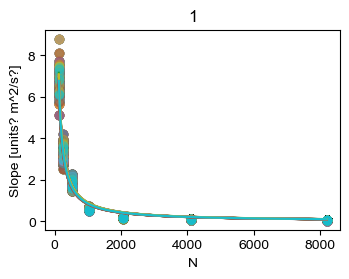

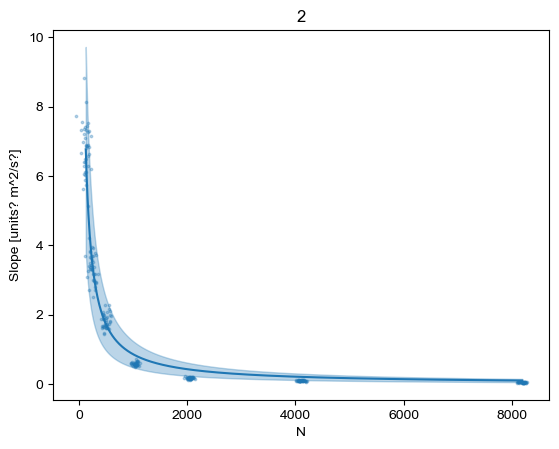

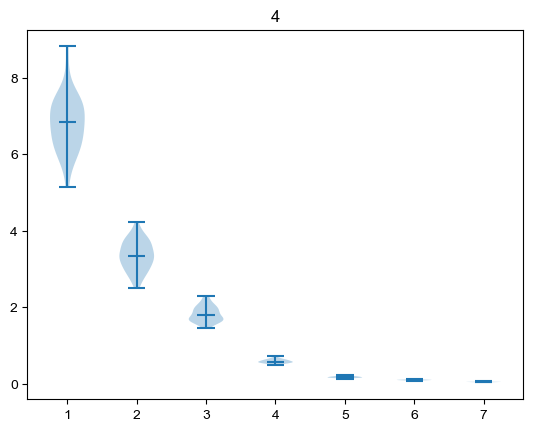

In [29]:
# Fit N~1/D*a to data

# This fits the straightened MAD curves from above so it fits to the calculations 
# of slope that used the MAD^2 data which seems more appropriate. So it fits the 
# the N = a * 1/D where D is in m^2/s.

# Using the above fitted slopes that now are correct as plotted above.
# Now the required numebr of neurons is 700 million instead of 500 milliion.

# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD instead or variance, the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus we have D_{MAD} ~ D_{SD} = \sqrt{D_{VAR}} = \sqrt{\frac{1}{N}a} [m/s] => N = \reac{1}{(D_{SD})^2}a [unitless]
# Thus fit N=(1/D^2)*a=y=((1/x^2)*a) to the ant data points.
# Drift rate MAD/s in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
# condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
# if condition == 1:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.01 # 1% => 1m/100m
# if condition == 2:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

# drift_max = drift_max_percent * range_max_new
drift_max = 0.343 # m2/hour
drift_rate_max = drift_max / t_req # m2/s
x_req = drift_rate_max
print('Max tolerable drift rate {}$m^2/h$ ({}$m^2/s$)'.format(drift_max, drift_rate_max))

func_inv_invprop_str = 'N=(1/D)*a, [a] = {}'

func_str = func_inv_invprop_str
func_fit = func_inv_invprop
func_params0 = [1]

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

fig = plt.figure(figsize=figsize)

#x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD

# Regress a curve to the data points using bootstrapping and plot
# N_s      # Neurons numbers
# slopes_s # Dispertion MAD2/s

subsample_size=int(N_s.shape[0]*0.3)
                   
# Create subsamples of data points
data_x_subsamples, data_y_subsamples = select_rand_subsample(N_s, 
                                                             slopes_s, 
                                                             subsample_size=subsample_size, 
                                                             N_subsamples=80)

y_reqs = []
N_prime_list     = []
slope_prime_list = []
params_list      = []
for i in range(len(data_x_subsamples)):
    N_prime, slope_prime, params, r2 = regress(data_x_subsamples[i], 
                                             data_y_subsamples[i], 
                                             func_fit, 
                                             params0=func_params0, 
                                             func_str = func_str, 
                                             x_range_min=None, 
                                             x_range_max=None)
    N_prime_list.append(N_prime)
    slope_prime_list.append(slope_prime)
    params_list.append(params)
    # Plot a scatter plot of this subsample
    plt.scatter(data_x_subsamples[i], data_y_subsamples[i], c=f'C{i}', alpha=0.3)
    # Plot the curve fitted to this subsample
    plt.plot(N_prime, slope_prime, c=f'C{i}')

    # Calculate required number of neurons
    y_req = func_fit(x_req, *params)
    print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    y_reqs.append(y_req)

plt.xlabel('N')
plt.ylabel('Slope [units? m^2/s?]')
plt.title('1')

y_reqs = np.array(y_reqs)
print()
print('Number of neurons required median={}, std={}'.format(np.median(y_reqs), np.std(y_reqs)*np.sqrt(subsample_size)))


# 2nd plot
# ========
# Replot with shade
plt.figure()

# Plot violin (does appear as vertical lines because it does not fit)
#plt.violinplot(slopes_array.T, 
#               positions=np.array(list(slopes.keys())), 
#               showmedians=True,
#               widths=0.1
#               )

# Plot fitted line and shaded min max
N_prime_array           = np.mean(np.array(N_prime_list), axis=0)
fitted_slope_prime_mean = np.mean(np.array(slope_prime_list), axis=0)
fitted_slope_prime_std  = np.std(np.array(slope_prime_list), axis=0)*np.sqrt(subsample_size)
params_median           = np.median(np.array(params_list), axis=0)

plt.fill_between(x=N_prime_array, 
                 y1=fitted_slope_prime_mean-2*fitted_slope_prime_std, 
                 y2=fitted_slope_prime_mean+2*fitted_slope_prime_std,
                 color=f'C{0}',
                 alpha=0.3)
plt.plot(N_prime_array, fitted_slope_prime_mean, c=f'C{0}')

# Plot a scatter plot
#plt.scatter(N_s, slopes_s, marker='o', s=3, c=f'C{0}', alpha=0.3)
plt.scatter(N_s+np.random.normal(loc=0, scale=50, size=log_N_s.shape), slopes_s, marker='o', s=3, c=f'C{0}', alpha=0.3)
plt.xlabel('N')
plt.ylabel('Slope [units? m^2/s?]')
plt.title('2')


# 3rd plot
# ========
# Plot violin
plt.figure()
vp = plt.violinplot(slopes_array.T, 
               showmedians=True
               )
#for pc in vp['bodies']:
#    pc.set_facecolor('#444444')
#    pc.set_edgecolor('#444444')
#    pc.set_alpha(1)

plt.title('4')


## Back to the previous attempts to fit different functions

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y=a*exp(-b*x)+c, [a, b, c] = [42732.12150952   614.26452371   469.68061166]
R^2 = 0.9913677327263757
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need 42955 excitatory neurons


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

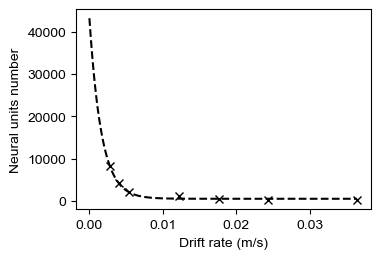

<Figure size 380x260 with 0 Axes>

In [33]:
# Fit curves to the ant data points using an exponential function (that was used in the first version of the paper)
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    
    params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))

    # Calculate fitted curve prediction
    y_prime = func_exp(x, params[0], params[1], params[2])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    y_req = func_exp(x_req, params[0], params[1], params[2])
    print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    max_lim = np.max(x)
    x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_exp(x_prime, params[0], params[1], params[2])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Neural units number')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        #plt.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
    

In [ ]:
# The relation theretically should be drift_coefficient=variance~1/N, N being the number of neurons.
# But the data points are not measured as variance, so this fitting is wrong. 
# Just tried this: Thus fit curves to the ant data points using the inverse of y=(1/x)*a=D=(1/N)*a that is x=(1/y)*a=N=(1/D)*a
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y


def func_inv_invprop(x, a):
    """ Exponential function """
    #y = a * np.exp(-b*x) + c
    #y = (1/x) * a * (1 / (1-b))
    y = (1/x) * a
    return y
func_inv_invprop_str = 'y=(1/x)*a, [a] = {}'

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    
    x = np.array(results_data[poisson_neuron_noise][model]['y']) # Dispertion MAD
    y = np.array(results_data[poisson_neuron_noise][model]['x']) # Neurons num N
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD
    
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    
    params, conv  = curve_fit(func_inv_invprop, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    #print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    print(func_inv_invprop_str.format(params))

    # Calculate fitted curve prediction
    y_prime = func_inv_invprop(x, params[0])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    y_req = func_inv_invprop(x_req, params[0])
    print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    max_lim = np.max(x)
    min_lim = x_req
    min_lim = 0.001
    min_lim = np.min(x) - np.min(x)*0.6
    x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_inv_invprop(x_prime, params[0])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Dispertion rate (m/s)')
    plt.ylabel('Neural units number')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        #plt.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
    

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y=a*1/x, [a] = [5.28280126]
R^2 = 0.8264010649098641
min(x) is 128
max(x) is 8192
Optimal parameters
y=a*1/x, [a] = [0.26164103]
R^2 = 0.7460158405785227
min(x) is 128
max(x) is 8192


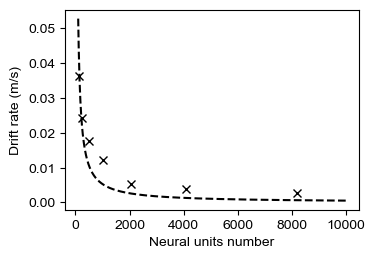

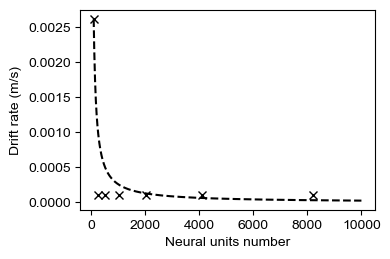

In [34]:
# The relation theretically should be drift_coefficient=variance~1/N, N being the number of neurons.
# But the data points are not measured as variance, so this fitting is wrong. 
# Just tried this: Thus fit a 1/N curve to the ant data points y=(1/x)*a=D=(1/N)*a
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max # Temp: Not used now
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_inv(x, a, b):
    """ Exponential function """
    y = (1 / x) * a + b
    #y = np.sqrt((1 / x) * a + b)
    #y = ((1 / x_tmp) * a + b)**2
    return y

def func_inv(x, a):
    """ Exponential function """
    y = (1 / x) * a           # OK match: R^2=0.7822170348833326 with a=4.9201581
    #y = np.sqrt((1 / x) * a) # Closer match: R^2=0.9689253549752882 with a=0.13683791 less steep than above
    #y = ((1 / x_tmp) * a)**2 # Totally off match: too steep curve raise
    return y


# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    
    y = np.array(results_data[poisson_neuron_noise][model]['y']) # Dispertion MAD
    x = np.array(results_data[poisson_neuron_noise][model]['x']) # Neurons number
    y = scale_circ_to_line(y, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD
    
    #params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    #params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
    params0 = [1] # Initial guess of parameter values to optimize [a, b]
    if model == 'NMDA':
        #params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
        #params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
        params0 = [1] # Initial guess of parameter values to optimize [a, b]
    if model == 'EC_LV_1':
        #params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
        #params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
        params0 = [1] # Initial guess of parameter values to optimize [a, b]
    
    #params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters
    params, conv  = curve_fit(func_inv, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    #print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    #print('y=a*1/x+b, [a, b] = {}'.format(params))
    print('y=a*1/x, [a] = {}'.format(params))

    # Calculate fitted curve prediction
    #y_prime = func_exp(x, params[0], params[1], params[2])
    #y_prime = func_inv(x, params[0], params[1])
    y_prime = func_inv(x, params[0])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    #y_req = func_exp(x_req, params[0], params[1], params[2])
    #y_req = func_inv(x_req, params[0], params[1])  # Temp: Not used now
    #print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))  # Temp: Not used now

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    #max_lim = np.max(x) # max drift rate
    max_lim = 10000 # max num of neurons
    print('min(x) is', np.min(x))
    print('max(x) is', np.max(x))
    x_prime = np.linspace(100, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    #y_prime = func_exp(x_prime, params[0], params[1], params[2])
    #y_prime = func_inv(x_prime, params[0], params[1])
    y_prime = func_inv(x_prime, params[0])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.ylabel('Drift rate (m/s)')
    plt.xlabel('Neural units number')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        #plt.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
    

Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
N=(1/D^2)*a, [a] = [0.0639991]
R^2 = 0.9899430672640714
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need 717498608 excitatory neurons
Optimal parameters
N=(1/D^2)*a, [a] = [2.76851913e-05]
R^2 = 0.09500842010130917
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need 310381 excitatory neurons


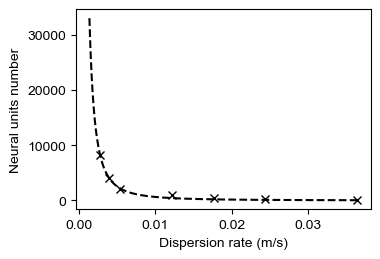

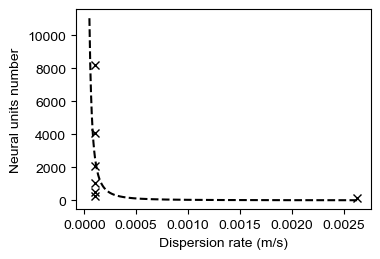

In [35]:
# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD instead or variance, the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus we have D_{MAD} ~ D_{SD} = \sqrt{D_{VAR}} = \sqrt{\frac{1}{N}a} [m/s] => N = \reac{1}{(D_{SD})^2}a [unitless]
# Thus fit N=(1/D^2)*a=y=((1/x^2)*a) to the ant data points.
# Drift rate MAD/s in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y


def func_inv_invprop(D, a):
    """ y=1/x^2*a function """
    #y = a * np.exp(-b*x) + c
    #y = (1/x) * a * (1 / (1-b))
    N=(1/D**2)*a
    return N
func_inv_invprop_str = 'N=(1/D^2)*a, [a] = {}'

func_fit = func_inv_invprop

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    
    x = np.array(results_data[poisson_neuron_noise][model]['y']) # Dispertion MAD
    y = np.array(results_data[poisson_neuron_noise][model]['x']) # Neurons number
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD
    
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    
    params, conv  = curve_fit(func_fit, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    #print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    print(func_inv_invprop_str.format(params))

    # Calculate fitted curve prediction
    y_prime = func_fit(x, params[0])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    y_req = func_fit(x_req, params[0])
    print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    max_lim = np.max(x)
    min_lim = x_req
    min_lim = 0.001
    min_lim = np.min(x) - np.min(x)*0.5
    x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    y_prime = func_fit(x_prime, params[0])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    #plt.xlabel('Drift rate (m/s)')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Neural units number')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        #plt.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
    

WARNING    /var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_82872/3163802773.py:44: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt((1 / x) * a) # Closer match: R^2=0.9689253549752882 with a=0.13683791 less steep than above
 [py.warnings]
WARNING    /var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_82872/3163802773.py:44: RuntimeWarning: invalid value encountered in sqrt
  y = np.sqrt((1 / x) * a) # Closer match: R^2=0.9689253549752882 with a=0.13683791 less steep than above
 [py.warnings]


Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y=sqrt(a*1/x), [a] = [0.15547008]
R^2 = 0.977280817330057
min(x) is 128
max(x) is 8192
Optimal parameters
y=sqrt(a*1/x), [a] = [0.0002622]
R^2 = 0.4702529470702719
min(x) is 128
max(x) is 8192


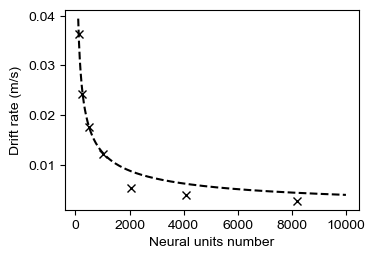

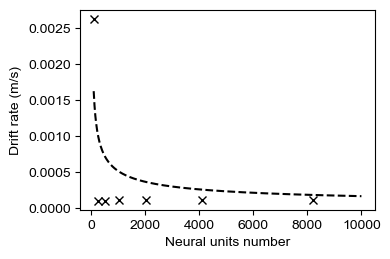

In [36]:
# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus fit a sqrt(1/N) curve to the ant data points y=sqrt((1/x)*a)=D=sqrt((1/N) * a)
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max # Temp: Not used now
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_inv(x, a, b):
    """ Exponential function """
    y = (1 / x) * a + b
    #y = np.sqrt((1 / x) * a + b)
    #y = ((1 / x_tmp) * a + b)**2
    return y

def func_inv(x, a):
    """ Exponential function """
    #y = (1 / x) * a           # OK match: R^2=0.7822170348833326 with a=4.9201581
    y = np.sqrt((1 / x) * a) # Closer match: R^2=0.9689253549752882 with a=0.13683791 less steep than above
    #y = ((1 / x_tmp) * a)**2 # Totally off match: too steep curve raise
    return y


# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    
    y = np.array(results_data[poisson_neuron_noise][model]['y'])
    x = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = scale_circ_to_line(y, scale=[(0, range_max), (0, range_max_new)])
    
    #params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    #params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
    params0 = [1] # Initial guess of parameter values to optimize [a, b]
    if model == 'NMDA':
        #params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
        #params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
        params0 = [1] # Initial guess of parameter values to optimize [a, b]
    if model == 'EC_LV_1':
        #params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
        #params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
        params0 = [1] # Initial guess of parameter values to optimize [a, b]
    
    #params, conv  = curve_fit(func_exp, x, y, params0) # fit function parameters
    params, conv  = curve_fit(func_inv, x, y, params0) # fit function parameters

    # Print the fitted parameters
    print('Optimal parameters')
    #print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
    #print('y=a*1/x+b, [a, b] = {}'.format(params))
    print('y=sqrt(a*1/x), [a] = {}'.format(params))

    # Calculate fitted curve prediction
    #y_prime = func_exp(x, params[0], params[1], params[2])
    #y_prime = func_inv(x, params[0], params[1])
    y_prime = func_inv(x, params[0])

    # Calculate r^2
    print('R^2 = {}'.format(r2_score(y, y_prime)))

    # Calculate required number of neurons
    #y_req = func_exp(x_req, params[0], params[1], params[2])
    #y_req = func_inv(x_req, params[0], params[1])  # Temp: Not used now
    #print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))  # Temp: Not used now

    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')

    # Plot fitted curve for more sample points to make it smooth
    #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
    max_lim = 1
    #max_lim = np.max(x) # max drift rate
    max_lim = 10000 # max num of neurons
    print('min(x) is', np.min(x))
    print('max(x) is', np.max(x))
    x_prime = np.linspace(100, max_lim, num=1000, endpoint=True)

    # Calculate fitted curve prediction
    #y_prime = func_exp(x_prime, params[0], params[1], params[2])
    #y_prime = func_inv(x_prime, params[0], params[1])
    y_prime = func_inv(x_prime, params[0])
    #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.ylabel('Drift rate (m/s)')
    plt.xlabel('Neural units number')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        #plt.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + figs_extension), bbox_inches='tight', dpi=300)
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_net_size_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
    

### For the EC_LV_1 neurons for more than 128 neurons any number of neurons does not produce significant difference in drift so all measurements appear vertically the one above the other so no good fitting can be made and it is not meaningfull. Because of this behaviour using the percentage value in the calc_theta_mean_absolute_deviation_rate() call produces wildly varying results. It works though as expected for the NMDA neurons. 

In [37]:
#import pandas as pd
#import copy 
## Reformat to 3D dict
#results_data_3D = copy.deepcopy(results_data)
#for k1 in results_data_3D.keys():
#    for k2 in results_data_3D[k1].keys():
#        for k_i, val in enumerate(results_data_3D[k1][k2]['x']):
#            results_data_3D[k1][k2][val] = scale_circ_to_line(results_data_3D[k1][k2]['y'][k_i], scale=[(0, 360), (0, 100)])
#        del results_data_3D[k1][k2]['x']
#        del results_data_3D[k1][k2]['y']
#
## Load the dict into a pandas data frame
## The dict structure is 
##     results_data_3D[poisson_neuron_noise][model][neurons_num] = drift_MAD_float
#df = pd.concat({k: pd.DataFrame(v).T for k, v in results_data_3D.items()}, axis=0)
#
## Set index names
#df.index.names = ['Noise', 'Model']
#df = df.reorder_levels(['Model', 'Noise'])
#
## Not sure how to do this; Scale the Noise values to the actual per neuron *1000
##df['Noise'] = df['Noise'].apply(lambda x: x*1000)
#
##df.columns.tolist()
#
## Sort index
#df.sort_index(inplace=True)
#df

In [30]:
import pandas as pd
import copy 
# Reformat to 3D dict
results_data_3D = []
for k1 in results_data.keys():
    for k2 in results_data[k1].keys():
        for k_i, key in enumerate(results_data[k1][k2]['x']):
            results_data_3D.append([k1, key, k2, scale_circ_to_line(results_data[k1][k2]['y'][k_i], scale=[(0, 360), (0, 100)])])
#results_data_3D
df4 = pd.DataFrame(results_data_3D, columns=['Noise', 'Neurons', 'Model', 'Drift'])
df4.set_index(['Model', 'Neurons'], inplace=True)

df4

Noise     Drift
Model   Neurons                 
NMDA    128      0.001  0.011764
        256      0.001  0.011694
        512      0.001  0.007122
        1024     0.001  0.006656
        2048     0.001  0.002781
...                ...       ...
EC_LV_1 512      0.009  0.000101
        1024     0.009  0.000103
        2048     0.009  0.000104
        4096     0.009  0.000103
        8192     0.009  0.000104

[126 rows x 2 columns]

Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 5.16845140e-02  7.42393550e+02 -7.00999821e+04  7.01000182e+04]
R^2 = 0.9330240967635465
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 2.76188885e-02  4.71410237e+02  6.99000144e+04 -6.98999856e+04]
R^2 = 0.9402261786361154
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 2.26019198e-02  3.53993289e+02  9.89998444e+03 -9.89996105e+03]
R^2 = 0.9704664448433793
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 3.24351435e-02  4.31415197e+01  1.99000186e+04 -1.98999815e+04]
R^2 = 0.904634361756881


WARNING    /Users/john/miniconda3/envs/brian2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 [py.warnings]
WARNING    /Users/john/miniconda3/envs/brian2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 [py.warnings]


Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [ 6.25344712e-03  2.62081694e+02  9.90000865e+03 -9.90000078e+03]
R^2 = 0.8681107568377093
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [-1.07188440e-03  2.11845273e+04 -1.24729347e+04  1.24729386e+04]
R^2 = -2.8720836819928763e-09
Optimal parameters
d - a*exp(-b*x)+c, [a, b, c, d] = [-8.79241901e-03  1.15704851e+04  4.05123342e+03 -4.05123052e+03]
R^2 = -2.0777254099213494e-05


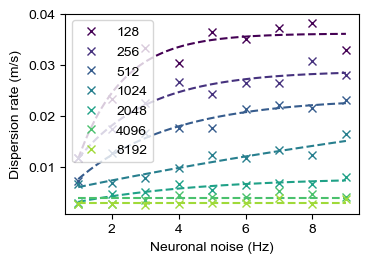

In [31]:
#df4.xs('NMDA').plot()
#df4.xs('NMDA').plot(x='Noise', y='Drift')
#df4.xs('NMDA').loc[128]['Noise']
#df4.xs('NMDA').loc[128]['Drift']

model = 'NMDA'

fig = plt.figure(figsize=figsize)
# Get the unique list of Neurons values and iterate
for indx_i, neurons in enumerate(np.unique(df4.xs(model).index.values)):
    # For each Neurons value plot a Drift vs Noise plot
    x = df4.xs(model).loc[neurons]['Noise']
    y = df4.xs(model).loc[neurons]['Drift']
    x_prime, y_prime, params, r2 = regress(x, y, func_exp_2, [0.06, 1000.0, -100, 100], func_str = 'd - a*exp(-b*x)+c, [a, b, c, d] = {}')
    if colourscheme == 'viridis': 
        colour = viridis(indx_i/len(neurons_nums))
        plt.plot(x*1000, y, 'x', label=neurons, color=colour)
        plt.plot(x_prime*1000, y_prime, '--', color=colour)
    else:
        plt.plot(x*1000, y, 'x', label=neurons)
        plt.plot(x_prime*1000, y_prime, '--')
plt.legend()
plt.xlabel('Neuronal noise (Hz)')
#plt.ylabel('Drift rate (m/s)')
plt.ylabel('Dispersion rate (m/s)')

#fig.tight_layout()

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + str(model) + '_effect_of_neuronal_noise_on_dispersion_rate_range100m' + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


Optimal parameters
a*x + b, [a, b] = [-0.00054136  0.00263335]
R^2 = 0.03284517371815876
Optimal parameters
a*x + b, [a, b] = [8.28077902e-06 1.00520367e-04]
R^2 = 0.008705109861449456
Optimal parameters
a*x + b, [a, b] = [1.92604201e-05 1.00792664e-04]
R^2 = 0.17036862745332293
Optimal parameters
a*x + b, [a, b] = [-9.21056053e-05  1.03122072e-04]
R^2 = 0.21346437382316497
Optimal parameters
a*x + b, [a, b] = [0.00015167 0.00010224]
R^2 = 0.2934632037018926
Optimal parameters
a*x + b, [a, b] = [1.54893572e-05 1.02623126e-04]
R^2 = 0.010924621123631573
Optimal parameters
a*x + b, [a, b] = [4.65409832e-04 9.88862367e-05]
R^2 = 0.774678960662041


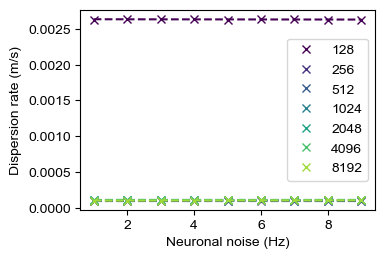

In [32]:
model = 'EC_LV_1'

fig = plt.figure(figsize=figsize)

for indx_i, neurons in enumerate(np.unique(df4.xs(model).index.values)):
    # For each Neurons value plot a Drift vs Noise plot
    x = df4.xs(model).loc[neurons]['Noise']
    y = df4.xs(model).loc[neurons]['Drift']
    # Both the exponential and linear function regression give equally bad R^2 score
    #x_prime, y_prime = regress(x, y, func_exp_2, [0.06, 1.0, -1.0, 1.0], func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
    x_prime, y_prime, params, r2 = regress(x, y, func_lin_1, [0.01, 0.0], func_str = 'a*x + b, [a, b] = {}')
    if colourscheme == 'viridis': 
        colour = viridis(indx_i/len(neurons_nums))
        plt.plot(x*1000, y, 'x', label=neurons, color=colour)
        plt.plot(x_prime*1000, y_prime, '--', color=colour)
    else:
        plt.plot(x*1000, y, 'x', label=neurons)
        plt.plot(x_prime*1000, y_prime, '--')
plt.legend()
plt.xlabel('Neuronal noise (Hz)')
plt.ylabel('Dispersion rate (m/s)')

#fig.tight_layout()

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + str(model) + '_effect_of_neuronal_noise_on_dispersion_rate_range100m' + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


# The ant data


Plot MofAD
Optimal parameters
y = a * x + b, [a, b] = [0.03422619 1.14285714]
R^2 = 0.8909203594669973
a = 0.034m/hour

Plot MofAD^2
Optimal parameters
y = a * x + b, [a, b] = [ 0.34318452 -4.78380962]
R^2 = 0.8453500500976842
a = 0.343m^2/hour

Plot MoAD converted to variance (assuming data are from Gaussian distribution)
Optimal parameters
y = a * x + b, [a, b] = [ 0.53907299 -7.51439043]
R^2 = 0.845350050097684
a = 0.539m^2/hour


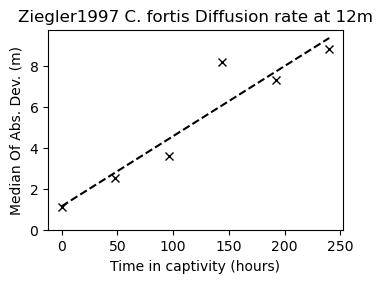

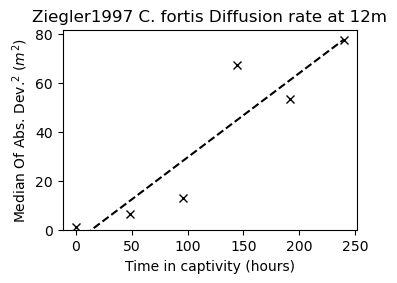

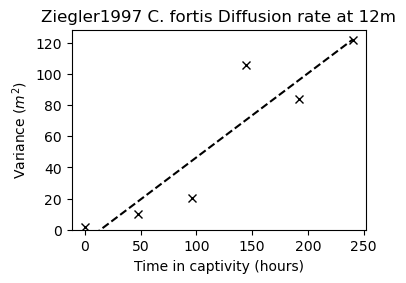

In [77]:
# Plot the homing distance error over time as Median Of Abs Deviations and approximations of variance

# Functions to use for regression to data
def func_linear(x, a, b):
    """ Linear function """
    y = a * x + b
    return y

def func_slowthenfastdecay(x, a, b):
    """ Decaying anti-exponential function """
    y = a - exp(x / b)
    return y

# Functions to use for regression to data
def func_parabola(x, a, b, c):
    """ Linear function """
    y = a * x**2 + b * x + c
    return y

def func_sigmoid_logistic_modified(x, a, x0, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    #return a * (1 - 1 / (1 + np.exp(-k * (x - x0))))
    return a / (1 + np.exp(k * (x - x0)))


# Select function to fit:
# -----------------------------------------------
# Function to fit 1
fit_func_name = 'func_slowthenfastdecay'
# Function to fit 2
#fit_func_name = 'func_parabola'
# Function to fit 3
fit_func_name = 'func_sigmoid_logistic_modified'
# -----------------------------------------------

if fit_func_name == 'func_slowthenfastdecay':
    fit_func = func_slowthenfastdecay
    fit_func_str = 'y = a - exp(x / b), [a, b] = {}'
if fit_func_name == 'func_parabola':
    fit_func = func_parabola
    fit_func_str = 'y = ax^2 + bx + c, [a, b, c] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified':
    fit_func = func_sigmoid_logistic_modified
    fit_func_str = 'y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'

# Plot data from [11] Ziegler, P. E. and Wehner, R. Time-courses of memory decay in vector-based and landmark-based systems of navigation in desert ants, Cataglyphis fortis. 1997.

# Data from paper
str_Ziegler1997 = 'Ziegler et al. (1997)'
str_Ziegler1997 = 'Ziegler et al.'
Z_DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
Z_HoursInCaptivity = Z_DaysInCaptivity * 24
Z_Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Z_Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])

print()
print('Plot MofAD')

# Plot data points of MofAD
fig = plt.figure(figsize=figsize)
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m, 'xk')

# Fit a curve: Line to the Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m
params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
# Calculate fitted curve to data points
x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m, func_linear, params0, func_str = 'y = a * x + b, [a, b] = {}', x_range_min=None, x_range_max=None)
print('a = {:.3f}m/hour'.format(params[0]))

plt.plot(x_prime, y_prime, '--k')
plt.ylabel('Median Of Abs. Dev. (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Diffusion rate at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviations' + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


print()
print('Plot MofAD^2')
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos2_12m = Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m**2
# Plot data points of MofAD
fig = plt.figure(figsize=figsize)
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos2_12m, 'xk')

# Fit a curve: Line to the Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos2_12m
params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
# Calculate fitted curve to data points
x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos2_12m, func_linear, params0, func_str = 'y = a * x + b, [a, b] = {}', x_range_min=None, x_range_max=None)
print('a = {:.3f}m^2/hour'.format(params[0]))

plt.plot(x_prime, y_prime, '--k')
plt.ylabel('Median Of Abs. Dev.$^2$ ($m^2$)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Diffusion rate at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviationsSquared' + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


print()
print('Plot MoAD converted to variance (assuming data are from Gaussian distribution)')

# Plot data points after converting MofAD to variance
fig = plt.figure(figsize=figsize)
plt.plot(Z_HoursInCaptivity, MAD2variance(Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m), 'xk')

# Fit a curve: Line to the Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m
params0 = [1, 0] # Initial guess of parameter values to optimize [a, b]
# Calculate fitted curve to data points
x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, MAD2variance(Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m), func_linear, params0, func_str = 'y = a * x + b, [a, b] = {}', x_range_min=None, x_range_max=None)
print('a = {:.3f}m^2/hour'.format(params[0]))

plt.plot(x_prime, y_prime, '--k')
plt.ylabel('Variance ($m^2$)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Diffusion rate at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'MedianOfAbsDeviations_to_variance' + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


<function matplotlib.pyplot.show(close=None, block=None)>

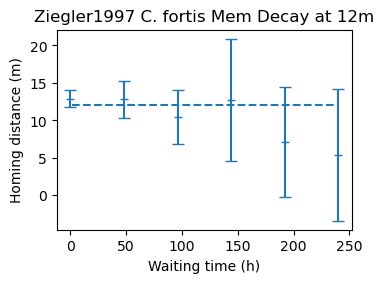

In [78]:
# Plot the homing distance data point spread (MofAD) vs waiting time
str_Ziegler1997 = 'Ziegler et al. (1997)'
str_Ziegler1997 = 'Ziegler et al.'
Z_DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
Z_HoursInCaptivity = Z_DaysInCaptivity * 24
Z_Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Z_Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])
outbound_distance = 12 # m

wait_t = Z_HoursInCaptivity

fig, ax = plt.subplots(1, 1, figsize=figsize)
#violin_parts = ax.violinplot(search_distance_data, showmedians=True)
ax.errorbar(wait_t, Z_Homing_Distance_Median_12m, yerr=Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m, fmt='_',capsize=4)

# Plot the nominal outbound distance
ax.hlines(outbound_distance, 1, max(wait_t), linestyles='dashed')

#ax.set_xticks(np.arange(1, len(wait_t) + 1))
#ax.set_xticklabels(wait_t)

ax.set_xlabel('Waiting time (h)')
ax.set_ylabel('Homing distance (m)')

if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Mem Decay at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'homing_distance_vs_waiting_time_errorbars_MAD' + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
plt.show



### Here I should try to fit the PopulationLoss form parametrisation of the inverse logistic function instead of the simple one that was best fitted to the data


Plot Median homing distance for Ziegler1997 and Cheng2005
Optimal parameters
y = a / (1 + k * np.exp((r*x))), [a, r, k] = [1.27911224e+01 2.20667438e-02 7.84371795e-03]
R^2 = 0.8481471042526401
a = 12.791m/hour

Plot Median homing distance for Cheng2005
Optimal parameters
y = a / (1 + k * np.exp((r*x))), [a, r, k] = [7.09554655e+00 3.37341805e-02 5.00000000e-03]
R^2 = 0.8220356384120207
a = 7.096m/hour

Plot Median homing distance for Ziegler1997 and Cheng2005 with extended x range


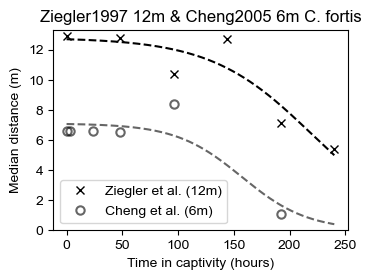

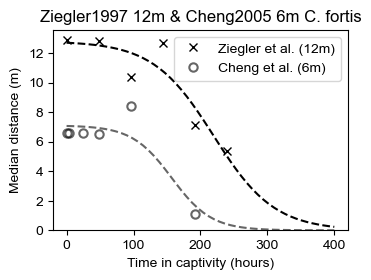

In [70]:
# Fit the function func_sigmoid_logistic_modified_2

# Plots again the Median homing distance for both papers in one plot and 
# fit alternative form of the inverse logistic function the PopulationLoss function

# Plot the same values as variance instead of MAD
# Plot data from [11] Ziegler, P. E. and Wehner, R. Time-courses of memory decay in vector-based and landmark-based systems of navigation in desert ants, Cataglyphis fortis. 1997.
# Plots the Median homing distance and the Median Of Abs Deviations

# Data from paper
str_Ziegler1997 = 'Ziegler et al. (1997)'
str_Ziegler1997 = 'Ziegler et al.'
Z_DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
Z_HoursInCaptivity = Z_DaysInCaptivity * 24
Z_Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Z_Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])

# Functions to use for regression to data
def func_linear(x, a, b):
    """ Linear function """
    y = a * x + b
    return y

def func_slowthenfastdecay(x, a, b):
    """ Decaying anti-exponential function """
    y = a - exp(x / b)
    return y

# Functions to use for regression to data
def func_parabola(x, a, b, c):
    """ Linear function """
    y = a * x**2 + b * x + c
    return y

def func_sigmoid_logistic_modified(x, a, x0, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    #return a * (1 - 1 / (1 + np.exp(-k * (x - x0))))
    return a / (1 + np.exp(k * (x - x0)))

# Functions to use for regression to data
def PopulationLoss(t, K, Nl, r):
    return K / (1 + Nl/(K - Nl) * np.exp(-r * t))

def func_sigmoid_logistic_modified_2(x, a, r, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    return a / (1 + k * np.exp(r*x))

# Select function to fit:
# -----------------------------------------------
# Function to fit 1
fit_func_name = 'func_slowthenfastdecay'
# Function to fit 2
#fit_func_name = 'func_parabola'
# Function to fit 3
fit_func_name = 'func_sigmoid_logistic_modified'
# Function to fit 4
fit_func_name = 'PopulationLoss'
# Function to fit 5
fit_func_name = 'func_sigmoid_logistic_modified_2'
# -----------------------------------------------

if fit_func_name == 'func_slowthenfastdecay':
    fit_func = func_slowthenfastdecay
    fit_func_str = 'y = a - exp(x / b), [a, b] = {}'
if fit_func_name == 'func_parabola':
    fit_func = func_parabola
    fit_func_str = 'y = ax^2 + bx + c, [a, b, c] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified':
    fit_func = func_sigmoid_logistic_modified
    fit_func_str = 'y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'
if fit_func_name == 'PopulationLoss':
    fit_func = PopulationLoss
    fit_func_str = 'y = K / (1 + Nl/(K - Nl) * np.exp(-r * t)), [K, Nl, r] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    fit_func = func_sigmoid_logistic_modified_2
    fit_func_str = 'y = a / (1 + k * np.exp((r*x))), [a, r, k] = {}'

print()
print('Plot Median homing distance for Ziegler1997 and Cheng2005')

fig = plt.figure(figsize=figsize)

# Plot data points: Median homing distance
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'x', color='black', alpha=1.00, label=str_Ziegler1997 + ' (12m)')

# Fit a curve: Decaying anti-exponential function to the Homing_Distance_Median
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [12, 200, 1] # Initial guess of parameter values to optimize [a, x0, k]
if fit_func_name == 'PopulationLoss':
    params0 = [12.7, 1, -0.02] # Initial guess of parameter values to optimize [K, Nl, r]
    bounds = [[10, -1, -1], [15, 2, -0.001]]
    bounds = None
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    params0 = [12.671639926260875, 0.035, 0.001] # Initial guess of parameter values to optimize [a, r, k]
    params0 = [12.7, 0.02, 1] # Initial guess of parameter values to optimize [K, Nl, r]
    
# Fit to the data points
x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, fit_func, params0, func_str = fit_func_str, x_range_min=Z_HoursInCaptivity[0], x_range_max=Z_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
Z_Homing_Distance_Median_12m_params = params.copy()

plot(x_prime, y_prime, '--', color='black', alpha=1.00)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Mem Decay at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
plt.show

# Store variables for later
Z_x_prime_12m_poploss = x_prime
Z_y_prime_12m_poploss = y_prime



# Data from paper
str_Cheng2005 = 'Cheng et al. (2005)'
str_Cheng2005 = 'Cheng et al.'
C_HoursInCaptivity = np.array([0, 3, 24, 48, 96, 192])
C_Homing_Distance_Median_12m=np.array([11.9, 12.7, 12.8, 8.0, 8.2, 3.0])
C_Homing_Distance_CV_12m=np.array([0.21, 0.26, 0.34, 0.54, 0.64, 0.89])
C_Homing_Distance_Median_6m=np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
C_Homing_Distance_CV_6m=np.array([0.38, 0.28, 0.62, 0.55, 0.64, 1.41])

print()
print('Plot Median homing distance for Cheng2005')

# Plot data points: Median homing distance
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')

# Fit a curve: Decaying anti-exponential function to the C_Homing_Distance_Median_6m
bounds = (-inf, inf)
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [6, 100, 0.01] # Initial guess of parameter values to optimize [a, x0, k]
    bounds = [[0, 50, 0.01], [20, 150, 0.05]]
if fit_func_name == 'PopulationLoss':
    params0 = [6, 1, -0.02] # Initial guess of parameter values to optimize [K, Nl, r]
    bounds = [[0, 0.01, -1], [15, 10, -0.001]]
    bounds = [[0, 0.01, -1], [15, 10, 10]]
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    params0 = [7, 0.035, 0.001] # Initial guess of parameter values to optimize [a, r, k]
    params0 = [7, 0.0220667871, 0.00784362457] # Initial guess of parameter values to optimize [a, r, k]
    bounds = [[6, 0.005, 0.005], [8, 0.08, 0.01]]
    # As we expand the bounds the curve becomes steeper and keeps moving the knee to the right (r increases and k decreases and never finds an optimum without bounds beeing set, so we set these boudns that produce a reasonable curve)
    
x_prime, y_prime, params, r2 = regress(C_HoursInCaptivity, C_Homing_Distance_Median_6m, fit_func, params0, func_str = fit_func_str, bounds = bounds, x_range_min=C_HoursInCaptivity[0], x_range_max=Z_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
C_Homing_Distance_Median_6m_params = params.copy()
plt.plot(x_prime, y_prime, '--', color='black', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

# Store variables for later
C_x_prime_6m_poploss = x_prime
C_y_prime_6m_poploss = y_prime

plt.legend()

if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


print()
print('Plot Median homing distance for Ziegler1997 and Cheng2005 with extended x range')

fig = plt.figure(figsize=figsize)
# Plot data points: Median homing distance
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'x', color='black', alpha=1.00, label=str_Ziegler1997 + ' (12m)')
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')
x_prime_iii = np.linspace(0, 400)
plt.plot(x_prime_iii, fit_func(x_prime_iii, *Z_Homing_Distance_Median_12m_params), '--', color='black', alpha=1.00)
plt.plot(x_prime_iii, fit_func(x_prime_iii, *C_Homing_Distance_Median_6m_params), '--', color='black', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
plt.legend()

if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_extended_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)





Plot Median homing distance for Ziegler1997 and Cheng2005
Optimal parameters
y = K / (1 + Nl/(K - Nl) * np.exp(-r * t)), [K, Nl, r] = [12.79111889  0.09954786 -0.0220668 ]
R^2 = 0.8481471042550036
a = 12.791m/hour

Plot Median homing distance for Cheng2005
Optimal parameters
y = K / (1 + Nl/(K - Nl) * np.exp(-r * t)), [K, Nl, r] = [ 7.03278734  0.01       -0.04114223]
R^2 = 0.8621380655583584
a = 7.033m/hour

Plot Median homing distance for Ziegler1997 and Cheng2005 with extended x range


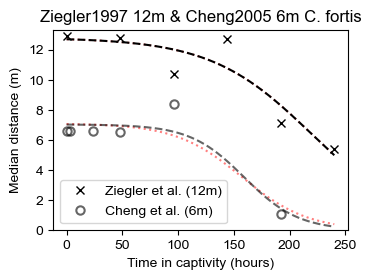

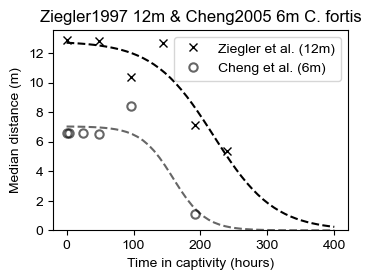

In [42]:
# Fit the function PopulationLoss

# Plots again the Median homing distance for both papers in one plot and 
# fit alternative form of the inverse logistic function the PopulationLoss function

# Plot the same values as variance instead of MAD
# Plot data from [11] Ziegler, P. E. and Wehner, R. Time-courses of memory decay in vector-based and landmark-based systems of navigation in desert ants, Cataglyphis fortis. 1997.
# Plots the Median homing distance and the Median Of Abs Deviations

# Data from paper
str_Ziegler1997 = 'Ziegler et al. (1997)'
str_Ziegler1997 = 'Ziegler et al.'
Z_DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
Z_HoursInCaptivity = Z_DaysInCaptivity * 24
Z_Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Z_Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])

# Functions to use for regression to data
def func_linear(x, a, b):
    """ Linear function """
    y = a * x + b
    return y

def func_slowthenfastdecay(x, a, b):
    """ Decaying anti-exponential function """
    y = a - exp(x / b)
    return y

# Functions to use for regression to data
def func_parabola(x, a, b, c):
    """ Linear function """
    y = a * x**2 + b * x + c
    return y

def func_sigmoid_logistic_modified(x, a, x0, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    #return a * (1 - 1 / (1 + np.exp(-k * (x - x0))))
    return a / (1 + np.exp(k * (x - x0)))

# Functions to use for regression to data
def PopulationLoss(t, K, Nl, r):
    return K / (1 + Nl/(K - Nl) * np.exp(-r * t))

def func_sigmoid_logistic_modified_2(x, a, r, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    return a / (1 + k * np.exp(r*x))

# Select function to fit:
# -----------------------------------------------
# Function to fit 1
fit_func_name = 'func_slowthenfastdecay'
# Function to fit 2
#fit_func_name = 'func_parabola'
# Function to fit 3
fit_func_name = 'func_sigmoid_logistic_modified'
# Function to fit 4
fit_func_name = 'PopulationLoss'
# Function to fit 5
#fit_func_name = 'func_sigmoid_logistic_modified_2'
# -----------------------------------------------

if fit_func_name == 'func_slowthenfastdecay':
    fit_func = func_slowthenfastdecay
    fit_func_str = 'y = a - exp(x / b), [a, b] = {}'
if fit_func_name == 'func_parabola':
    fit_func = func_parabola
    fit_func_str = 'y = ax^2 + bx + c, [a, b, c] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified':
    fit_func = func_sigmoid_logistic_modified
    fit_func_str = 'y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'
if fit_func_name == 'PopulationLoss':
    fit_func = PopulationLoss
    fit_func_str = 'y = K / (1 + Nl/(K - Nl) * np.exp(-r * t)), [K, Nl, r] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    fit_func = func_sigmoid_logistic_modified_2
    fit_func_str = 'y = a / (1 + k * np.exp((r*x))), [a, r, k] = {}'

print()
print('Plot Median homing distance for Ziegler1997 and Cheng2005')

fig = plt.figure(figsize=figsize)

# Plot old fit 
plt.plot(Z_x_prime_12m_poploss, Z_y_prime_12m_poploss, ':', color='red', alpha=0.5)

# Plot data points: Median homing distance
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'x', color='black', alpha=1.00, label=str_Ziegler1997 + ' (12m)')

# Fit a curve: Decaying anti-exponential function to the Homing_Distance_Median
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [12, 200, 1] # Initial guess of parameter values to optimize [a, x0, k]
if fit_func_name == 'PopulationLoss':
    params0 = [12.7, 1, -0.02] # Initial guess of parameter values to optimize [K, Nl, r]
    bounds = [[10, -1, -1], [15, 2, -0.001]]
    bounds = None
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    params0 = [12.671639926260875, 0.035, 0.001] # Initial guess of parameter values to optimize [a, r, k]
# Fit to the data points
x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, fit_func, params0, func_str = fit_func_str, x_range_min=Z_HoursInCaptivity[0], x_range_max=Z_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
Z_Homing_Distance_Median_12m_params = params.copy()

plot(x_prime, y_prime, '--', color='black', alpha=1.00)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Mem Decay at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
plt.show

# Store variables for later
Z_x_prime_12m_poploss = x_prime
Z_y_prime_12m_poploss = y_prime



# Data from paper
str_Cheng2005 = 'Cheng et al. (2005)'
str_Cheng2005 = 'Cheng et al.'
C_HoursInCaptivity = np.array([0, 3, 24, 48, 96, 192])
C_Homing_Distance_Median_12m=np.array([11.9, 12.7, 12.8, 8.0, 8.2, 3.0])
C_Homing_Distance_CV_12m=np.array([0.21, 0.26, 0.34, 0.54, 0.64, 0.89])
C_Homing_Distance_Median_6m=np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
C_Homing_Distance_CV_6m=np.array([0.38, 0.28, 0.62, 0.55, 0.64, 1.41])

print()
print('Plot Median homing distance for Cheng2005')

# Plot old fit 
plt.plot(C_x_prime_6m_poploss, C_y_prime_6m_poploss, ':', color='red', alpha=0.5)

# Plot data points: Median homing distance
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')

# Fit a curve: Decaying anti-exponential function to the C_Homing_Distance_Median_6m
bounds = (-inf, inf)
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [6, 100, 0.01] # Initial guess of parameter values to optimize [a, x0, k]
    bounds = [[0, 50, 0.01], [20, 150, 0.05]]
if fit_func_name == 'PopulationLoss':
    params0 = [6, 1, -0.02] # Initial guess of parameter values to optimize [K, Nl, r]
    bounds = [[0, 0.01, -1], [15, 10, -0.001]]
    bounds = [[0, 0.01, -1], [15, 10, 10]]
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    params0 = [7, 0.035, 0.001] # Initial guess of parameter values to optimize [a, r, k]
    params0 = [7, 0.0220667871, 0.00784362457] # Initial guess of parameter values to optimize [a, r, k]
    bounds = [[6, 0.005, 0.005], [8, 0.08, 0.01]]
    # As we expand the bounds the curve becomes steeper and keeps moving the knee to the right (r increases and k decreases and never finds an optimum without bounds beeing set, so we set these boudns that produce a reasonable curve)
    
x_prime, y_prime, params, r2 = regress(C_HoursInCaptivity, C_Homing_Distance_Median_6m, fit_func, params0, func_str = fit_func_str, bounds = bounds, x_range_min=C_HoursInCaptivity[0], x_range_max=Z_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
C_Homing_Distance_Median_6m_params = params.copy()
plt.plot(x_prime, y_prime, '--', color='black', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

# Store variables for later
C_x_prime_6m_poploss = x_prime
C_y_prime_6m_poploss = y_prime

plt.legend()

if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


print()
print('Plot Median homing distance for Ziegler1997 and Cheng2005 with extended x range')

fig = plt.figure(figsize=figsize)
# Plot data points: Median homing distance
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m, 'x', color='black', alpha=1.00, label=str_Ziegler1997 + ' (12m)')
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m, 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')
x_prime_iii = np.linspace(0, 400)
plt.plot(x_prime_iii, fit_func(x_prime_iii, *Z_Homing_Distance_Median_12m_params), '--', color='black', alpha=1.00)
plt.plot(x_prime_iii, fit_func(x_prime_iii, *C_Homing_Distance_Median_6m_params), '--', color='black', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
plt.legend()

if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_extended_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)





Plot Median homing distance for Ziegler1997 and Cheng2005
Optimal parameters
y = K / (1 + Nl/(K - Nl) * np.exp(-r * t)), [K, Nl, r] = [ 0.99155984  0.00771702 -0.02206672]
R^2 = 0.8481471042491061
a = 0.992m/hour

Plot Median homing distance for Cheng2005
Optimal parameters
y = K / (1 + Nl/(K - Nl) * np.exp(-r * t)), [K, Nl, r] = [ 0.85925161  0.01       -0.02863933]
R^2 = 0.780863071552397
a = 0.859m/hour

Plot Median homing distance for Ziegler1997 and Cheng2005 with extended x range
K1, Nl1, r1 0.8592516094841097 0.010000000000000002 -0.02863933067856276


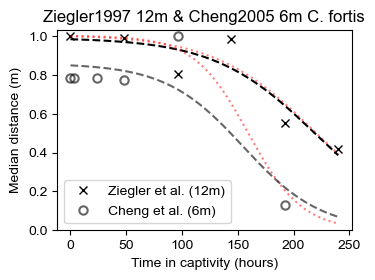

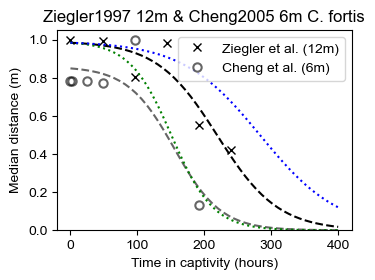

In [43]:
# Copy of the above to see the range of Nl and r we need to use

# Plots again the Median homing distance for both papers in one plot and 
# fit alternative form of the inverse logistic function the PopulationLoss function

# Plot the same values as variance instead of MAD
# Plot data from [11] Ziegler, P. E. and Wehner, R. Time-courses of memory decay in vector-based and landmark-based systems of navigation in desert ants, Cataglyphis fortis. 1997.
# Plots the Median homing distance and the Median Of Abs Deviations

# Data from paper
str_Ziegler1997 = 'Ziegler et al. (1997)'
str_Ziegler1997 = 'Ziegler et al.'
Z_DaysInCaptivity = np.array([0, 2, 4, 6, 8, 10])
Z_HoursInCaptivity = Z_DaysInCaptivity * 24
Z_Homing_Distance_Median_12m=np.array([12.9, 12.8, 10.4, 12.7, 7.1, 5.4])
Z_Homing_Distance_MAD_12m=np.array([1.6, 2.2, 3.7, 8.1, 5.6, 4.0])
Z_Homing_Distance_MedianOfAbsDeviationsFirstTurnFromNestPos_12m=np.array([1.1, 2.5, 3.6, 8.2, 7.3, 8.8])

# Functions to use for regression to data
def func_linear(x, a, b):
    """ Linear function """
    y = a * x + b
    return y

def func_slowthenfastdecay(x, a, b):
    """ Decaying anti-exponential function """
    y = a - exp(x / b)
    return y

# Functions to use for regression to data
def func_parabola(x, a, b, c):
    """ Linear function """
    y = a * x**2 + b * x + c
    return y

def func_sigmoid_logistic_modified(x, a, x0, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    #return a * (1 - 1 / (1 + np.exp(-k * (x - x0))))
    return a / (1 + np.exp(k * (x - x0)))

# Functions to use for regression to data
def PopulationLoss(t, K, Nl, r):
    return K / (1 + Nl/(K - Nl) * np.exp(-r * t))

def func_sigmoid_logistic_modified_2(x, a, r, k):
    """ 
        Parameters:
            x0 : the centre of the function along the x axis
            k  : the slope of the logistic function
            a  : the maximum value
    """
    return a / (1 + k * np.exp(r*x))

# Select function to fit:
# -----------------------------------------------
# Function to fit 1
fit_func_name = 'func_slowthenfastdecay'
# Function to fit 2
#fit_func_name = 'func_parabola'
# Function to fit 3
fit_func_name = 'func_sigmoid_logistic_modified'
# Function to fit 4
fit_func_name = 'PopulationLoss'
# Function to fit 5
#fit_func_name = 'func_sigmoid_logistic_modified_2'
# -----------------------------------------------

if fit_func_name == 'func_slowthenfastdecay':
    fit_func = func_slowthenfastdecay
    fit_func_str = 'y = a - exp(x / b), [a, b] = {}'
if fit_func_name == 'func_parabola':
    fit_func = func_parabola
    fit_func_str = 'y = ax^2 + bx + c, [a, b, c] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified':
    fit_func = func_sigmoid_logistic_modified
    fit_func_str = 'y = a / (1 + np.exp(k * (x - x0))), [a, x0, k] = {}'
if fit_func_name == 'PopulationLoss':
    fit_func = PopulationLoss
    fit_func_str = 'y = K / (1 + Nl/(K - Nl) * np.exp(-r * t)), [K, Nl, r] = {}'
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    fit_func = func_sigmoid_logistic_modified_2
    fit_func_str = 'y = a / (1 + k * np.exp((r*x))), [a, r, k] = {}'

print()
print('Plot Median homing distance for Ziegler1997 and Cheng2005')

fig = plt.figure(figsize=figsize)

# Plot old fit 
plt.plot(Z_x_prime_12m_poploss, Z_y_prime_12m_poploss/np.max(Z_y_prime_12m_poploss), ':', color='red', alpha=0.5)

# Plot data points: Median homing distance
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m/np.max(Z_Homing_Distance_Median_12m), 'x', color='black', alpha=1.00, label=str_Ziegler1997 + ' (12m)')

# Fit a curve: Decaying anti-exponential function to the Homing_Distance_Median
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [12, 200, 1] # Initial guess of parameter values to optimize [a, x0, k]
if fit_func_name == 'PopulationLoss':
    params0 = [12.7, 1, -0.02] # Initial guess of parameter values to optimize [K, Nl, r]
    bounds = [[10, -1, -1], [15, 2, -0.001]]
    bounds = None
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    params0 = [12.671639926260875, 0.035, 0.001] # Initial guess of parameter values to optimize [a, r, k]
# Fit to the data points
x_prime, y_prime, params, r2 = regress(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m/np.max(Z_Homing_Distance_Median_12m), fit_func, params0, func_str = fit_func_str, x_range_min=Z_HoursInCaptivity[0], x_range_max=Z_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
Z_Homing_Distance_Median_12m_params = params.copy()

plot(x_prime, y_prime, '--', color='black', alpha=1.00)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

if not SAVE_PLOT:
    plt.title('Ziegler1997 C. fortis Mem Decay at 12m')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_cataglyphis_fortis_12m_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
plt.show

# Store variables for later
Z_x_prime_12m_poploss = x_prime
Z_y_prime_12m_poploss = y_prime



# Data from paper
str_Cheng2005 = 'Cheng et al. (2005)'
str_Cheng2005 = 'Cheng et al.'
C_HoursInCaptivity = np.array([0, 3, 24, 48, 96, 192])
C_Homing_Distance_Median_12m=np.array([11.9, 12.7, 12.8, 8.0, 8.2, 3.0])
C_Homing_Distance_CV_12m=np.array([0.21, 0.26, 0.34, 0.54, 0.64, 0.89])
C_Homing_Distance_Median_6m=np.array([6.6, 6.6, 6.6, 6.5, 8.4, 1.1])
C_Homing_Distance_CV_6m=np.array([0.38, 0.28, 0.62, 0.55, 0.64, 1.41])

print()
print('Plot Median homing distance for Cheng2005')

# Plot old fit 
plt.plot(C_x_prime_6m_poploss, C_y_prime_6m_poploss/np.max(C_y_prime_6m_poploss), ':', color='red', alpha=0.5)

# Plot data points: Median homing distance
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m/np.max(C_Homing_Distance_Median_6m), 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')

# Fit a curve: Decaying anti-exponential function to the C_Homing_Distance_Median_6m
bounds = (-inf, inf)
if fit_func_name == 'func_slowthenfastdecay':
    params0 = [10, 10] # Initial guess of parameter values to optimize [a, b]
if fit_func_name == 'func_parabola':
    params0 = [10, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
if fit_func_name == 'func_sigmoid_logistic_modified':
    params0 = [6, 100, 0.01] # Initial guess of parameter values to optimize [a, x0, k]
    bounds = [[0, 50, 0.01], [20, 150, 0.05]]
if fit_func_name == 'PopulationLoss':
    params0 = [6, 1, -0.02] # Initial guess of parameter values to optimize [K, Nl, r]
    bounds = [[0, 0.01, -1], [15, 10, -0.001]]
    bounds = [[0, 0.01, -1], [15, 10, 10]]
if fit_func_name == 'func_sigmoid_logistic_modified_2':
    params0 = [7, 0.035, 0.001] # Initial guess of parameter values to optimize [a, r, k]
    params0 = [7, 0.0220667871, 0.00784362457] # Initial guess of parameter values to optimize [a, r, k]
    bounds = [[6, 0.005, 0.005], [8, 0.08, 0.01]]
    # As we expand the bounds the curve becomes steeper and keeps moving the knee to the right (r increases and k decreases and never finds an optimum without bounds beeing set, so we set these boudns that produce a reasonable curve)
    
x_prime, y_prime, params, r2 = regress(C_HoursInCaptivity, C_Homing_Distance_Median_6m/np.max(C_Homing_Distance_Median_6m), fit_func, params0, func_str = fit_func_str, bounds = bounds, x_range_min=C_HoursInCaptivity[0], x_range_max=Z_HoursInCaptivity[-1])
print('a = {:.3f}m/hour'.format(params[0]))
C_Homing_Distance_Median_6m_params = params.copy()
plt.plot(x_prime, y_prime, '--', color='black', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])

# Store variables for later
C_x_prime_6m_poploss = x_prime
C_y_prime_6m_poploss = y_prime

plt.legend()

if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


print()
print('Plot Median homing distance for Ziegler1997 and Cheng2005 with extended x range')

fig = plt.figure(figsize=figsize)
# Plot data points: Median homing distance
plt.plot(Z_HoursInCaptivity, Z_Homing_Distance_Median_12m/np.max(Z_Homing_Distance_Median_12m), 'x', color='black', alpha=1.00, label=str_Ziegler1997 + ' (12m)')
plt.plot(C_HoursInCaptivity, C_Homing_Distance_Median_6m/np.max(C_Homing_Distance_Median_6m), 'o', color='black', alpha=0.60, fillstyle='none', markeredgewidth=1.5, label=str_Cheng2005 + ' (6m)')
x_prime_iii = np.linspace(0, 400)
plt.plot(x_prime_iii, fit_func(x_prime_iii, *Z_Homing_Distance_Median_12m_params), '--', color='black', alpha=1.00)
plt.plot(x_prime_iii, fit_func(x_prime_iii, *C_Homing_Distance_Median_6m_params), '--', color='black', alpha=0.60)
plt.ylabel('Median distance (m)')
plt.xlabel('Time in captivity (hours)')
plt.ylim([0, None])
plt.legend()

## Plot parameter range exploration curves
#K1, Nl1, r1 = Z_Homing_Distance_Median_12m_params
#print('K1, Nl1, r1 {} {} {}'.format(*params))
#Nl1 = Nl1 - 0.005 # -0.001 -0.002 -0.003 -0.004 -0.005
#plt.plot(x_prime_iii, fit_func(x_prime_iii, *[K1, Nl1, r1]), ':', color='green', alpha=1)
##Nl1 = Nl1 + 0.005 No change
#Nl1 = Nl1 + 0.02 # 0.006 0.008 0.01 0.012 0.015
#plt.plot(x_prime_iii, fit_func(x_prime_iii, *[K1, Nl1, r1]), ':', color='blue', alpha=1)

K1, Nl1, r1 = Z_Homing_Distance_Median_12m_params
print('K1, Nl1, r1 {} {} {}'.format(*params))
r1 = r1 - 0.01 # -0.001 -0.002 -0.005 -0.008 -0.01
plt.plot(x_prime_iii, fit_func(x_prime_iii, *[K1, Nl1, r1]), ':', color='green', alpha=1)
#r1 = r1 + 0.01 No change
r1 = r1 + 0.015 # 0.011 0.012 0.013 0.014 0.015
plt.plot(x_prime_iii, fit_func(x_prime_iii, *[K1, Nl1, r1]), ':', color='blue', alpha=1)


if not SAVE_PLOT:
    plt.title('Ziegler1997 12m & Cheng2005 6m C. fortis')
if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'Ziegler_etal_1997_12m_Cheng_etal_2005_6m_cataglyphis_fortis_' + 'Homing_Distance_Median_fit_extended_' + fit_func_name + figs_extension), bbox_inches='tight', dpi=300, transparent=True)




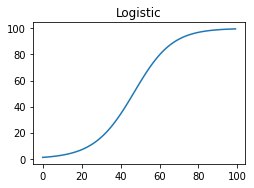

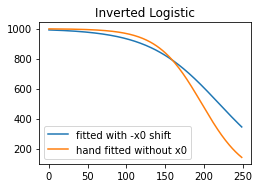

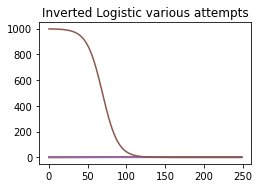

In [226]:
xxx = []
yyy = []
yyy_v = 2
dN_l = []

r = 0.1
N = 1
K = 100

for i in range(0,100):
    dN = r * N * (1 - N/K)
    dN_l.append(dN)
    N = N + dN
    yyy.append(N)
    xxx.append(i)

xxx = np.array(xxx)
yyy = np.array(yyy)

fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.set_title('Logistic')

ax.plot(xxx, yyy)

fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.set_title('Inverted Logistic')

def logistic(a, k, x0, x):
    return a / (1 + np.exp(k * (x-x0)))

def PopulationGrowth(N0, r, K, t):
    return K / (1 + (K - N0)/N0 * np.exp(-r * t))
def PopulationLoss(Nl, r, K, t):
    return K / (1 + Nl/(K - Nl) * np.exp(-r * t))
r = 0.1
K = 100
N0 = 1

ttt = np.array(range(0, 250))
# Nt = K / (1 + (K - N0)/N0 * np.exp(-r * ttt))
#Nt = PopulationGrowth(N0, r, K, ttt)
#ax.plot(ttt, Nt)

a=1000; k=0.022; x0=219.7
Nt = logistic(a, k, x0, ttt)
ax.plot(ttt, Nt, label='fitted with -x0 shift')
ax.plot(ttt, 1000/(1+0.001*np.exp(0.035*ttt)), label='hand fitted without x0')
ax.legend()

Nl = 1; K = 1000; r = -0.1
Nt = PopulationLoss(Nl, r, K, ttt)
#ax.plot(ttt, Nt)
Nl = 1; K = 1000; r = -0.1
Nt = PopulationLoss(Nl, r, K, ttt)
#ax.plot(ttt, Nt)

fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.set_title('Inverted Logistic various attempts')
ax.plot(ttt, np.exp(-0.1*ttt))
ax.plot(ttt, 1/(1+np.exp(-0.1*ttt)))
ax.plot(ttt, 1/(1+2*np.exp(-0.1*ttt)))
ax.plot(ttt, 1/(1+100*np.exp(-0.1*ttt)))
ax.plot(ttt, 1/(1+1000*np.exp(-0.1*ttt)))

ax.plot(ttt, 1000/(1+0.001*np.exp(0.1*ttt)))
#ax.plot(ttt, 500/(1+0.001*np.exp(0.1*ttt)))


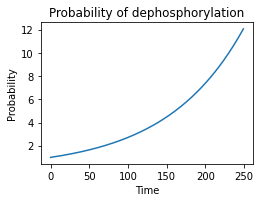

In [227]:
ttt = np.array(range(0, 250))
import scipy as sp

fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.set_title('Probability of dephosphorylation')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
P = np.exp(0.01*ttt) # /(sp.constants.k*298.15)# e^{c*x/(kT), T=25C in K}
#P = P.clip(0, 1)
ax.plot(ttt, P) 


# Here I explored how Gaussian independent noise affects the state of a process over time.

Text(0, 0.5, 'Mean abs deviation of Gaussian noise')

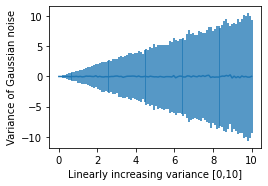

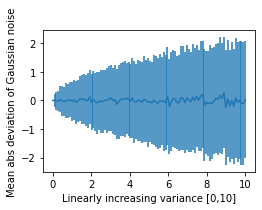

In [228]:
## Test MAD vs variance
import scipy as sp

variance_vals = np.linspace(0,10,num=100) # Variance values to explore
x = variance_vals
y = []
y_variance = []
y_MAD = []
for i,val in enumerate(x):
    variance_val = variance_vals[i]
    sample_vals = np.random.normal(loc=0, scale=np.sqrt(variance_val), size=1000)
    y.append(np.median(sample_vals))
    y_variance.append(np.var(sample_vals))
    y_MAD.append(sp.stats.median_abs_deviation(sample_vals))

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.errorbar(x, y, yerr=y_variance)
ax.set_xlabel('Linearly increasing variance [0,10]')
ax.set_ylabel('Variance of Gaussian noise')

fig2, ax2 = plt.subplots(1, 1, figsize=figsize)
ax2.errorbar(x, y, yerr=y_MAD)
ax2.set_xlabel('Linearly increasing variance [0,10]')
ax2.set_ylabel('Mean abs deviation of Gaussian noise')


Text(0, 0.5, 'Mean abs deviation of Gaussian noise')

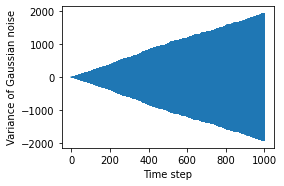

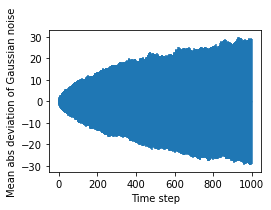

In [229]:
# Test MAD vs variance
import scipy as sp

variance_val = 2 # Fixed variance will be accumulated over time steps

t_steps = range(0,1000)
y = []
y_variance = []
y_MAD = []

sample_vals = np.zeros((1000,))
for i,t_step in enumerate(t_steps):
    sample_delta_vals = np.random.normal(loc=0, scale=np.sqrt(variance_val), size=1000)
    sample_vals = sample_vals + sample_delta_vals
    y.append(np.median(sample_vals))
    y_variance.append(np.var(sample_vals))
    y_MAD.append(sp.stats.median_abs_deviation(sample_vals))

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.errorbar(t_steps, y, yerr=y_variance)
ax.set_xlabel('Time step')
ax.set_ylabel('Variance of Gaussian noise')

fig2, ax2 = plt.subplots(1, 1, figsize=figsize)
ax2.errorbar(t_steps, y, yerr=y_MAD)
ax2.set_xlabel('Time step')
ax2.set_ylabel('Mean abs deviation of Gaussian noise')


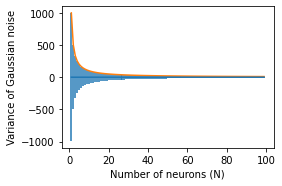

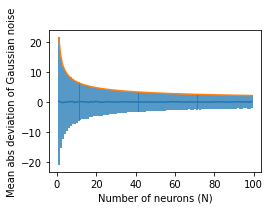

In [230]:
# Test MAD vs variance
import scipy as sp

variance_val = 1000 # Fixed variance 
N_vals = range(1,100) # Different factors (number of neurons)

x = N_vals
y = []
y_variance = []
y_MAD = []

for i,N_val in enumerate(N_vals):
    # temp Ninv = N_val
    Ninv = 1 / N_val
    sample_vals = np.random.normal(loc=0, scale=np.sqrt(Ninv*variance_val), size=10000)
    y.append(np.median(sample_vals))
    y_variance.append(np.var(sample_vals))
    y_MAD.append(sp.stats.median_abs_deviation(sample_vals))

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.errorbar(x, y, yerr=y_variance)
ax.set_xlabel('Number of neurons (N)')
ax.set_ylabel('Variance of Gaussian noise')
#ax.plot(x, np.array(x)*1000) # model of variance values with Ninv=N_val
ax.plot(x, 1/(np.array(x))*1000) # model of variance values with Ninv=1/N_val

fig2, ax2 = plt.subplots(1, 1, figsize=figsize)
ax2.errorbar(x, y, yerr=y_MAD)
ax2.set_xlabel('Number of neurons (N)')
ax2.set_ylabel('Mean abs deviation of Gaussian noise')
#ax2.plot(x, np.sqrt(np.array(x)*450))     # model of MAD values with Ninv=N_val
ax2.plot(x, np.sqrt(1/(np.array(x))*450)) # model of MAD values with Ninv=1/N_val

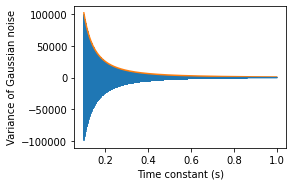

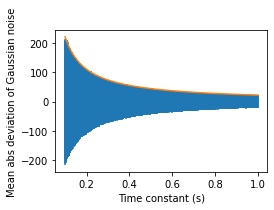

In [231]:
# Test MAD vs variance when it depends to 1/(x^2)
import scipy as sp

variance_val = 1000 # Fixed variance 
N_vals = np.linspace(10**-1,1,num=1000) # Different factors (number of neurons)

x = N_vals
y = []
y_variance = []
y_MAD = []

for i,N_val in enumerate(N_vals):
    # temp Ninv = N_val
    Ninv = 1 / (N_val**2)
    sample_vals = np.random.normal(loc=0, scale=np.sqrt(Ninv*variance_val), size=10000)
    y.append(np.median(sample_vals))
    y_variance.append(np.var(sample_vals))
    y_MAD.append(sp.stats.median_abs_deviation(sample_vals))

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.errorbar(x, y, yerr=y_variance)
ax.set_xlabel('Time constant (s)')
ax.set_ylabel('Variance of Gaussian noise')
#ax.plot(x, np.array(x)*1000) # model of variance values with Ninv=N_val
ax.plot(x, (1/(np.array(x))*32)**2) # model of variance values with Ninv=1/N_val

fig2, ax2 = plt.subplots(1, 1, figsize=figsize)
ax2.errorbar(x, y, yerr=y_MAD)
ax2.set_xlabel('Time constant (s)')
ax2.set_ylabel('Mean abs deviation of Gaussian noise')
#ax2.plot(x, np.sqrt(np.array(x)*450))     # model of MAD values with Ninv=N_val
ax2.plot(x, (1/(np.array(x))*22)) # model of MAD values with Ninv=1/N_val

# Systematic weight bias

In [38]:
input_path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
input_file = 'collected-wrapped-NMDA-SHIFT.npy' # This is the non unwrapped recordings

input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [39]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'][1]
poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][4]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][1]
tau = ['complex', '10m', '50m', '100m', '500m', '1000m', '5000m', '10000m', '50000m'][0]
data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

TypeError: 'NoneType' object is not subscriptable

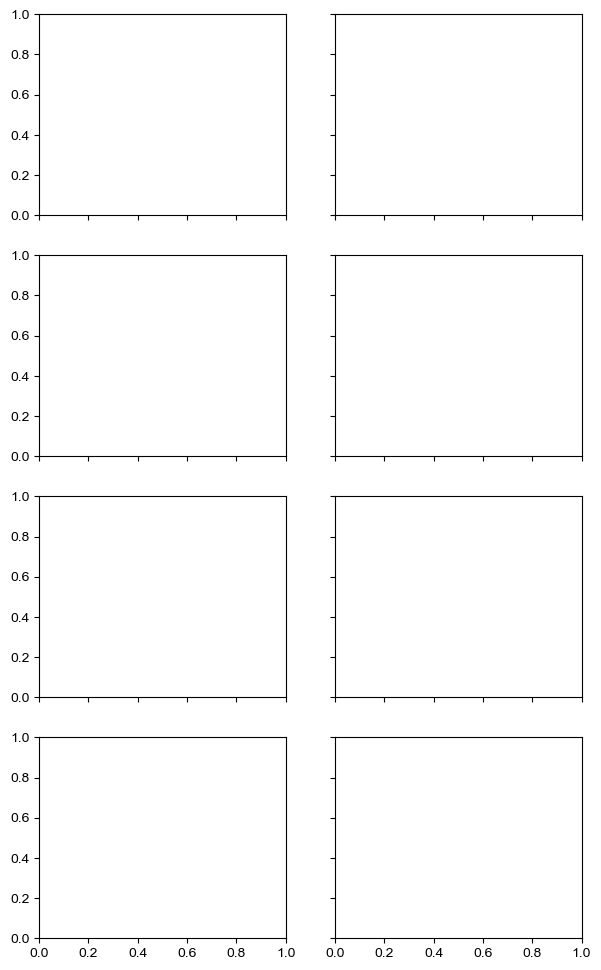

In [40]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std, 
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

#models = ['NMDA-SHIFT']  # List of the neuron models present in the collected recordings file
models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = -50 + 12 # To start from 12[m]
plot_from_t = None

# Plot labeling
if plot_type == plot_types[0]: # Plot theta_ts_list
    plot_mapping_units = 'Bump location (m)'
if plot_type == plot_types[1]: # Plot abs_diff_mean
    plot_mapping_units = 'Mean Absolute Deviation (m)'
if plot_type == plot_types[2]: # Plot abs_diff_std
    plot_mapping_units = 'Mean Absolute Deviation SD? (m)'
if plot_type == plot_types[3]: # Plot the median of theta_ts_list
    plot_mapping_units = 'Median bump location (m)'

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    
for poisson_neuron_noise in poisson_neuron_noises:
    if SAVE_PLOT:
        fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(7, 12), sharex=True, sharey=True)
    else:
        fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(7, 12), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_i, indx_j]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts+normalise_start, color='black', alpha=0.2)
                    ax.set_title('NMDA SHIFT = ' + str(model))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(neurons_nums))
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num), color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=str(neurons_num))
                #ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()
            
            if plot_type == plot_types[3]: # Plot theta_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                ax.plot(t_snapshots, np.median(np.array(ts_list)+normalise_start, axis=0))
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))
                ax.set_ylabel(plot_mapping_units)

            #if indx_i == 1:
            #    ax.set_ylim([0, 0.04])
    fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_effect_of_systematic_weight_anisotropy_on_bump_shift_' + plot_type + '_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


Noise = 0.005
N = 256
Model and skewed Gaussian shift factor = NMDA-SHIFT-0.0005
ts_list len =  249


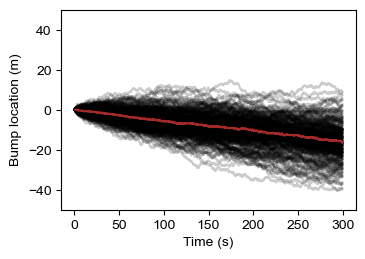

In [41]:
# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std, 
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

model = models[1]                               # Choose which neuron model results to plot
poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]
plot_traces_subset = 249 # Plot the first 249 traces to have the same sample as the without shift model

# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = -50 + 12 # To start from 12[m]
plot_from_t = None

print('Noise = ' + str(poisson_neuron_noise))
print('N = ' + str(neurons_num))
print('Model and skewed Gaussian shift factor = ' + model)
data_dic = data[()][model][poisson_neuron_noise][tau][neurons_num]
plot_type = ['theta', 'abs_diff_mean', 'abs_diff_std'][0]
fig = plt.figure(figsize=figsize)
ax = plt.gca()
plot_individual_traces(ax, data_dic, scale=plot_scale_mapping, plot_type=plot_type, y_bias=-50, ylabel = 'Bump location (m)', plot_traces_subset=plot_traces_subset, colour='black', plot_median=True, colour_median='brown', SAVE_PLOT=SAVE_PLOT)
#ax.set_ylim([0, 100])
ax.set_ylim([-50, 50])

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_systematic_weight_anisotropy_on_bump_shift_' + plot_type + '_range100m' + '_neurons' + str(neurons_num) + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


TypeError: 'NoneType' object is not subscriptable

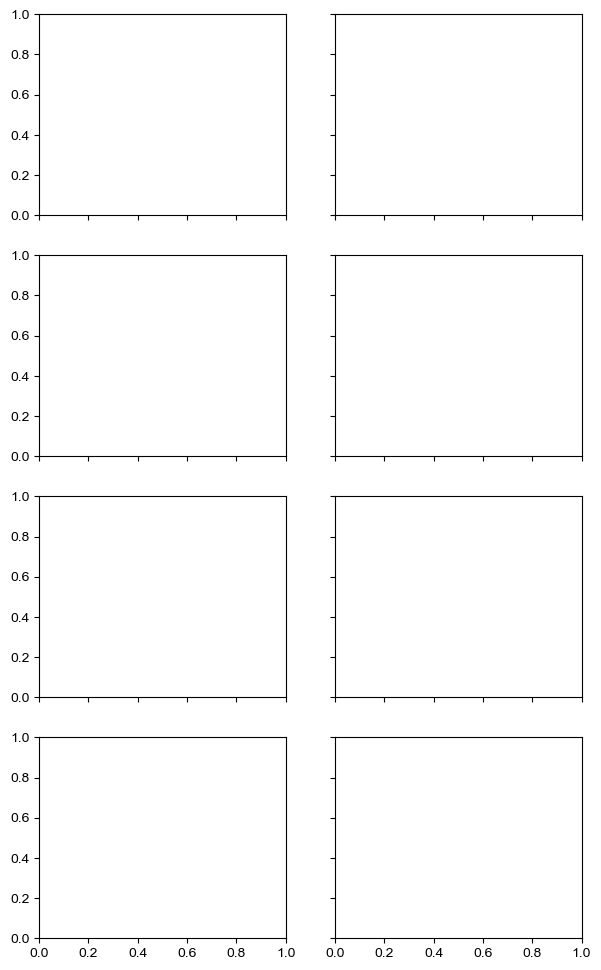

In [42]:
# Plot each experimental condition in separate plot

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[3]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
#neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(models), ncols=2, figsize=(7, 12), sharex=True, sharey=True)

    for indx_i, model in enumerate(models):
        for indx_j, neurons_num in enumerate(neurons_nums):
            # Get reference to the appropriate subplot
            ax = axs[indx_i, indx_j]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']

            fig.suptitle('Noise = ' + str(poisson_neuron_noise))

            if plot_type == plot_types[0]: # Plot theta_ts_list
                for i, ts in enumerate(theta_ts_list):
                    ax.plot(t_snapshots, ts)
                    ax.set_title('NMDA SHIFT = ' + str(model))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ax.plot(t_snapshots, theta_ts_abs_diff_std)
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))

            if plot_type == plot_types[3]: # Plot theta_mean
                ax.plot(t_snapshots, np.median(np.array(theta_ts_list), axis=0))
                ax.set_title('NMDA SHIFT = ' + str(model))
                ax.set_xlabel('Time (s)')
                #ax.set_ylim((0, 360))
    
    fig.tight_layout()

Noise = 0.005
N = 256
Model and skewd Gaussian shift factor = NMDA-SHIFT-0.0005


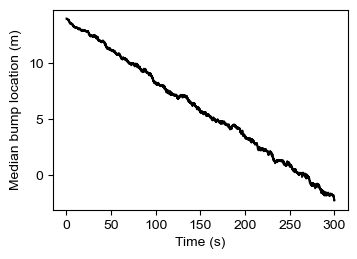

In [43]:
# Plot each experimental condition in separate plot

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std', 'theta_mean']
plot_type = plot_types[3]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std
                                                #       'theta_mean': calculates and plots the mean of theta_ts_list

models = ['NMDA-SHIFT-0.001', 'NMDA-SHIFT-0.0005', 'NMDA-SHIFT-0.0001', 'NMDA-SHIFT-0.00001'] # List of the neuron models present in the collected recordings file
poisson_neuron_noises = [0.005] # List of the neuron noise present in the collected recordings file
neurons_nums = [256] # List of the network sizes present in the collected recordings file
taus = ['complex', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms']

model = models[1]                               # Choose which neuron model results to plot
poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot
tau = taus[0]

print('Noise = ' + str(poisson_neuron_noise))
print('N = ' + str(neurons_num))
print('Model and skewd Gaussian shift factor = ' + model)
data_dic = data[()][model][poisson_neuron_noise][tau][neurons_num]

fig = plt.figure(figsize=figsize)
ax = plt.gca()

# Get the list of theta recordings time series
theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)

if plot_type == plot_types[3]: # Plot theta_mean
    ax.plot(t_snaps, np.median(np.array(ts_list), axis=0)-50+14, color='black')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Median bump location (m)')
    #ax.set_ylim((0, 360))

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_systematic_weight_anisotropy_on_bump_shift_' + plot_type + '_range100m' + '_neurons' + str(neurons_num) + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)
    

# Effect of neuronal time constant on bump stability 

In [33]:
if not running_on_colab: # if not running on colab, thus on the laptop, load data from external disk
    input_path = '/Volumes/WD Elements 25A3 Media/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
else:                    # if running on colab, load data google drive
    input_path = '/content/drive/MyDrive/Journals/Bump Attractors and Path Integration/Data/Documents/Research/PhD/Projects/Recurrent_Net_Memory/Attractor_Based_Memory_Plaussibility_Study/'
    #input_path = '/content/drive/MyDrive/Attractor_Based_Memory_Plaussibility_Study/'

input_file = 'collected-wrapped.npy' # This is the non unwrapped recordings
#input_file = 'collected-wrapped-NMDA-EC_LV_1-bak27082021.npy' # This is the non unwrapped recordings
input_file = 'collected-wrapped-SIMPLE.npy' # This is the non unwrapped recordings with various tau values
#input_file = 'collected-unwrapped-SIMPLE-bak01092021-2.npy'
input_file = 'collected-unwrapped-SIMPLE.npy' # This is the unwrapped recordings with various tau values
input_file = 'collected-wrapped-SIMPLE-TAU2.npy' # This is the non unwrapped recordings with various tau values
input_file = 'collected-unwrapped-SIMPLE-TAU2.npy' # This is the unwrapped recordings with various tau values
input_file = 'collected-unwrapped-NMDA-TAU.npy' # This is the unwrapped recordings with various tau values

input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [34]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA', 'EC_LV_1', 'SIMPLE'][2]
poisson_neuron_noise = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.100][5]
model = ['NMDA', 'EC_LV_1', 'SIMPLE', 'SIMPLE-TAU2', 'NMDA-TAU'][4]
poisson_neuron_noise = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.100, 1.0, 1.4][13]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][1]
tau = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms', '100000ms'][4]
#data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()
data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

Trials tau=0.5ms n=398
Trials tau=1ms n=336
Trials tau=5ms n=299
Trials tau=10ms n=380
Trials tau=20ms n=368
Trials tau=30ms n=407
Trials tau=40ms n=420
Trials tau=50ms n=386
Trials tau=60ms n=365
Trials tau=70ms n=373
Trials tau=80ms n=212
Trials tau=90ms n=250
Trials tau=100ms n=291


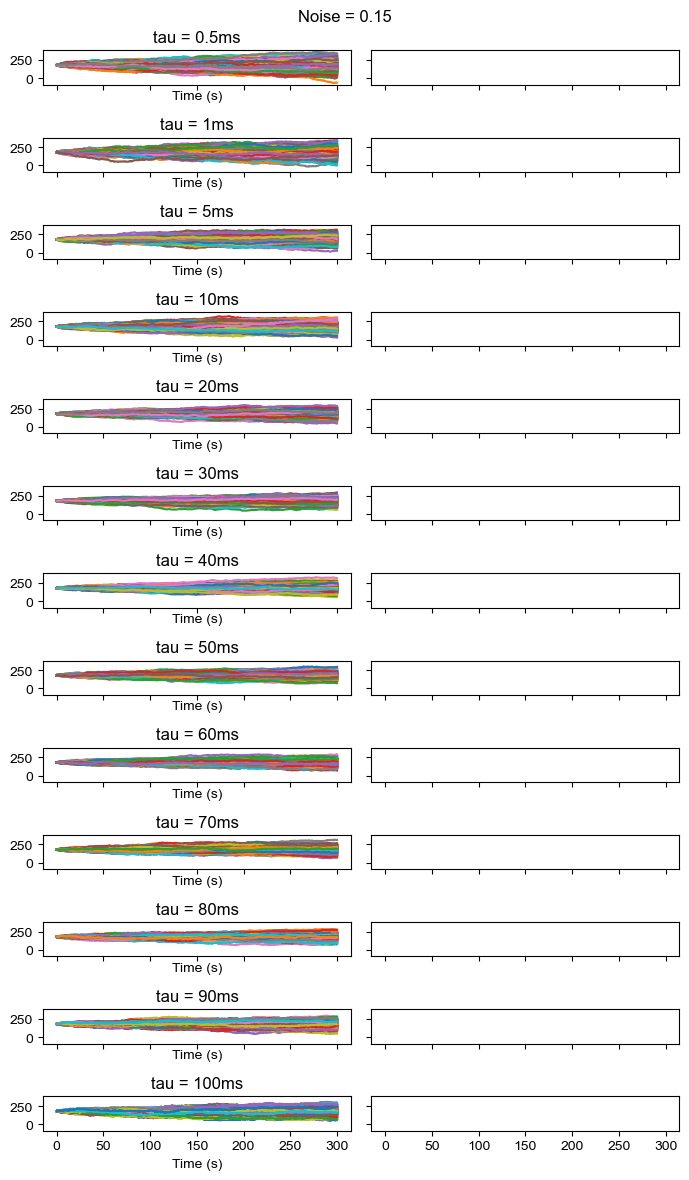

In [35]:
# Plot each experimental condition in separate plot
#noise=0.002 Dispersion seems to be decreasing with tau value for tau 10-1000 not for 10000
#noise=0.005 There does not seem to be difference between tau values
#noise=0.008 Very noisy. Dispersion maybe decreases with tau value but it is very noisy

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

show_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
show_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
show_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#show_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512
            
models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if show_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '1ms', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms', '100000ms'][1:]
    taus = ['complex', '1ms', '10ms', '100ms', '1000ms', '10000ms', '100000ms'][2:7]
    taus = ['complex', '1ms', '10ms', '100ms', '1000ms', '10000ms', '100000ms'][1:4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '100ms', '1000ms', '10000ms', '100000ms'][1:7]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:14]
    # temp
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '50ms', '80ms', '100ms', '1000ms', '10000ms', '100000ms'][1:10]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:12]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:14]

# Newly collected data with 256 neurons
if show_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]

# Newly collected data with 512 neurons
if show_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]

if show_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]


#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(taus), ncols=2, figsize=(7, 12), sharex=True, sharey=True)
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            ax = axs[indx_j, indx_i]
            try: 
                # Get the list of theta recordings time series
                theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
                t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
                theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
                theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']

                fig.suptitle('Noise = ' + str(poisson_neuron_noise))

                if plot_type == plot_types[0]: # Plot theta_ts_list
                    print('Trials tau={:} n={:}'.format(tau, len(theta_ts_list)))
                    #theta_ts_list = theta_ts_list[:134]
                    for i, ts in enumerate(theta_ts_list):
                        ax.plot(t_snapshots, ts)
                        ax.set_title('tau = ' + str(tau))
                        ax.set_xlabel('Time (s)')
                        #ax.set_ylim((0, 360))

                if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                    ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                    ax.set_title('tau = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))

                if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                    ax.plot(t_snapshots, theta_ts_abs_diff_std)
                    ax.set_title('tau = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
            except:
                pass

    fig.tight_layout()

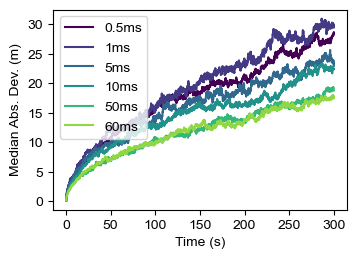

In [36]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

plot_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
#plot_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
#plot_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#plot_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512


models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if plot_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '60ms'][1:]

#taus = ['0.5ms', '1ms', '10ms', '40ms', '50ms', '80ms']

# Newly collected data with 256 neurons - These data look very bad worse than with possion_noise=1.4
if plot_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:]
    taus = ['complex', '1ms', '10ms', '20ms', '80ms'][1:]

# Newly collected data with 512 neurons - These data use more neurons for having less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '30ms', '40ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    #taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '30ms', '40ms'][1:] # The 5ms sample has a funny drop in error after 250s probably an unwrapping issue
    # To try without unwrapping if 5ms shows up ok. It looks the same.
    
# Newly collected data with 512 neurons - These data use more neurons for having even less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]
    taus = ['complex', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    # To collect and include 5ms trials

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_mapping_units = 'Mean Abs. Dev. (m)'
plot_mapping_units = 'Median Abs. Dev. (m)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    #viridis = plt.cm.get_cmap('Greys')
    
for poisson_neuron_noise in poisson_neuron_noises:
    #if SAVE_PLOT:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    #else:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=True)
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            #ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('$\tau$ = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

    #fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_tau_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)

        

Plot the curves with MAD values raised to the power of 2


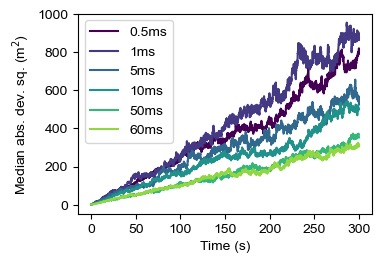

In [37]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

MAD_to_power = 2 # Raise the MASD values to that power, default 1
print('Plot the curves with MAD values raised to the power of', MAD_to_power)

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

plot_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
#plot_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
#plot_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#plot_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512


models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if plot_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '60ms'][1:]

#taus = ['0.5ms', '1ms', '10ms', '40ms', '50ms', '80ms']

# Newly collected data with 256 neurons - These data look very bad worse than with possion_noise=1.4
if plot_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:]
    taus = ['complex', '1ms', '10ms', '20ms', '80ms'][1:]

# Newly collected data with 512 neurons - These data use more neurons for having less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '30ms', '40ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    #taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '30ms', '40ms'][1:] # The 5ms sample has a funny drop in error after 250s probably an unwrapping issue
    # To try without unwrapping if 5ms shows up ok. It looks the same.
    
# Newly collected data with 512 neurons - These data use more neurons for having even less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]
    taus = ['complex', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    # To collect and include 5ms trials

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_mapping_units = 'Mean Abs. Dev. (m)'
#plot_mapping_units = 'Median Abs. Dev. (m)'
plot_mapping_units = 'Median abs. dev. sq. (m$^2$)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    #viridis = plt.cm.get_cmap('Greys')
    
for poisson_neuron_noise in poisson_neuron_noises:
    #if SAVE_PLOT:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    #else:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=True)
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            #ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('$\tau$ = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    # Was: ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                    ax.plot(t_snaps/second, np.power(ts_list, MAD_to_power), label=tau, color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

    #fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_tau_on_dispersion_squared_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


In [38]:
# Explore the activity bump shape for different time constants

data[()][model][poisson_neuron_noise][tau][neurons_num].keys()


dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

Plot the curves with MAD values raised to the power of 2
[[2.44636308]
 [2.89815619]
 [1.91366292]
 [1.58946224]
 [1.58076696]
 [1.09032487]
 [1.06044891]
 [1.07472268]
 [1.01208553]
 [1.17916576]
 [1.03035535]
 [1.12192565]]


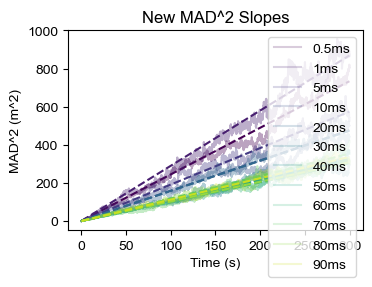

In [39]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

MAD_to_power = 2 # Raise the MASD values to that power, default 1
print('Plot the curves with MAD values raised to the power of', MAD_to_power)

plot_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
# plot_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
#plot_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#plot_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512


models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if plot_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]
    # taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '60ms'][1:]

#taus = ['0.5ms', '1ms', '10ms', '40ms', '50ms', '80ms']

# Newly collected data with 256 neurons - These data look very bad worse than with possion_noise=1.4
if plot_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:]
    taus = ['complex', '1ms', '10ms', '20ms', '80ms'][1:]

# Newly collected data with 512 neurons - These data use more neurons for having less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '30ms', '40ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    #taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '30ms', '40ms'][1:] # The 5ms sample has a funny drop in error after 250s probably an unwrapping issue
    # To try without unwrapping if 5ms shows up ok. It looks the same.
    
# Newly collected data with 512 neurons - These data use more neurons for having even less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]
    taus = ['complex', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    # To collect and include 5ms trials

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_mapping_units = 'Mean Abs. Dev. (m)'
plot_mapping_units = 'Median Abs. Dev. (m)'
plot_mapping_units = 'MAD^2 (m^2)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    #viridis = plt.cm.get_cmap('Greys')
    
for poisson_neuron_noise in poisson_neuron_noises:
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    for indx_i, model in enumerate(models):
        tau_ar = []
        MAD2_ar = []
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            #ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # Plot theta_ts_abs_diff_mean
            ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)

            MAD2_ar.append(np.power(ts_list, MAD_to_power))
            tau_ar.append(tau)

            if colourscheme == 'viridis': 
                colour = viridis(indx_j/len(taus))
                # Was: ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                ax.plot(t_snaps/second, np.power(ts_list, MAD_to_power), label=tau, color=colour,alpha=0.2)
            else: 
                ax.plot(t_snaps/second, np.power(ts_list, MAD_to_power), label=tau,alpha=0.2)
            #ax.set_title('N = ' + str(neurons_num))
            ax.set_xlabel('Time (s)')
            ax.set_ylabel(plot_mapping_units)
            #ax.set_ylim((0, 360))
            ax.legend()
    
    MAD2_ar = np.array(MAD2_ar)
    slopes = calculate_slopes1(t_snaps, MAD2_ar)
    print(slopes)

    for i in range(len(taus)):
        ax.plot(t_snaps,MAD2_ar[i],label=tau_ar[i],color=viridis(i/len(taus)),alpha=0.2)
        ax.plot(t_snaps,t_snaps*slopes[i],color=viridis(i/len(taus)), linestyle='--')
    #ax.legend()
    ax.set_title('New MAD^2 Slopes')
    slopes_MAD2 = slopes

    #fig.tight_layout()
    
    #if SAVE_PLOT:
    #    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_tau_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


## Bootstrap the error for the required tau

In [40]:
# Package the tau data for bootstrapping
model = 'NMDA-TAU'                              # Choose neuron model in the collected recordings file
poisson_neuron_noise = 1.4                      # Choose neuron noise level in the collected recordings file
neurons_num = 256                               # Choose network size present in the collected recordings file
print('model = {}, poisson_neuron_noise = {}, neurons_num = {}'.format(model, poisson_neuron_noise, neurons_num))
taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]
taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '60ms'][1:]
taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][2:13]
data_trials_abs_dev = {}
data_trials_msq_dev = {}
for indx_j, tau in enumerate(taus): # For each network size
    data_trials_abs_dev[tau] = np.abs(180 - np.array(data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list'])) # Calculate the absolute deviations from 180deg
    data_trials_msq_dev[tau] = (180 - np.array(data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']))**2    # Calculate the mean-squared deviations from 180deg

print('data_trials_abs_dev contains the absolute deviation per trial per time step for each tau value.')

model = NMDA-TAU, poisson_neuron_noise = 1.4, neurons_num = 256
data_trials_abs_dev contains the absolute deviation per trial per time step for each tau value.


Text(0, 0.5, 'Slope m2/s')

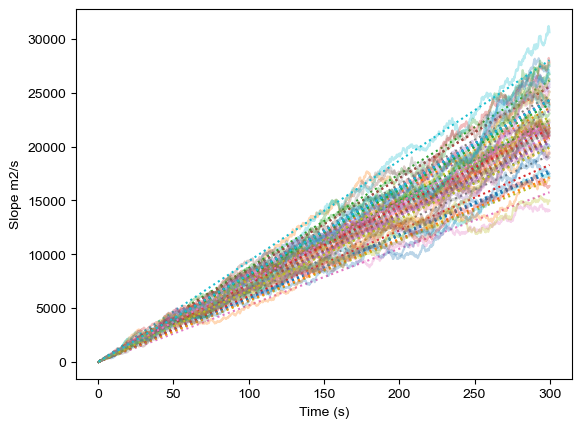

In [41]:
# Calculate the slopes of some tau data using bootstraping

# construct ensembles for one case tau=1ms
x2_ens = construct_ensembles(data_trials_msq_dev['1ms'], ensemble_size = 100, N_ensembles = 40)

# calculate slopes
slopes = calculate_slopes(t_snaps, x2_ens)

# plot results for one case tau=1ms
for i,x2 in enumerate(x2_ens):
    plt.plot(t_snaps, x2, c=f'C{i}', alpha=0.3)
    plt.plot(t_snaps,t_snaps*slopes[i],linestyle=':',c=f'C{i}')
plt.xlabel('Time (s)')
plt.ylabel('Slope m2/s')

In [42]:
slopes

array([80.67774123, 74.86855454, 87.14646149, 85.18718559, 77.69411412,
       85.42055742, 52.54704452, 63.96134726, 56.29844608, 58.69802857,
       58.57603547, 78.61408127, 73.58712528, 73.27007381, 81.38765028,
       71.48732563, 67.82585238, 82.46660028, 73.40431247, 93.44713797,
       59.31949485, 57.08111875, 74.83767958, 61.00823211, 72.63168937,
       68.44788497, 70.07876952, 71.10078939, 75.90179856, 79.8158744 ,
       81.09774312, 69.40659087, 79.79790353, 72.18136933, 68.06983761,
       68.86978229, 74.07210924, 66.65327423, 66.29337565, 81.03350583])

Text(0, 0.5, 'Diffusion coef. m2/s')

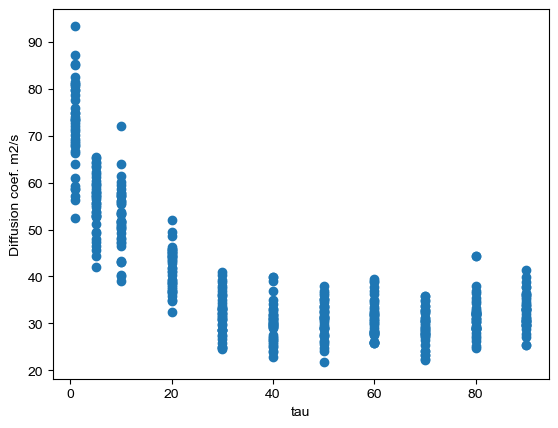

In [43]:
# Calculate slopes for all taus
slopes = {}
list2plot = [] 
for k in data_trials_abs_dev.keys():
    x2_ens = construct_ensembles(data_trials_msq_dev[k], ensemble_size = 100, N_ensembles = 40)
    slopes[k] = calculate_slopes(t_snaps, x2_ens)
    for slope in slopes[k]:
        list2plot.append([float(k.replace('ms', '')),slope])
plt.scatter(*np.array(list2plot).T)
slopes
plt.xlabel('tau')
plt.ylabel('Diffusion coef. m2/s')

Text(0, 0.5, '1 / Diffusion coef. s/m2')

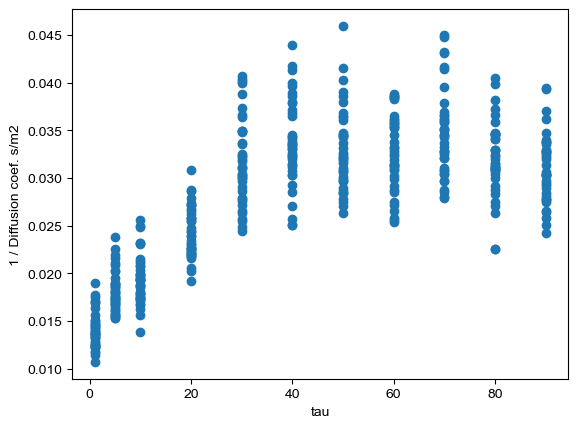

In [44]:
plt.scatter(np.array(list2plot).T[0], 1/np.array(list2plot).T[1])
slopes
plt.xlabel('tau')
plt.ylabel('1 / Diffusion coef. s/m2')


## Try to fit a line to D~1/tau^2 and calculate confidence intervals. This uses the slopes dict that were calculated using bootstrapping.

Optimal parameters
a*x + b, [a, b] = [-0.21388699  1.87431718]
R^2 = 0.7791639646527646


Text(0.5, 1.0, '4')

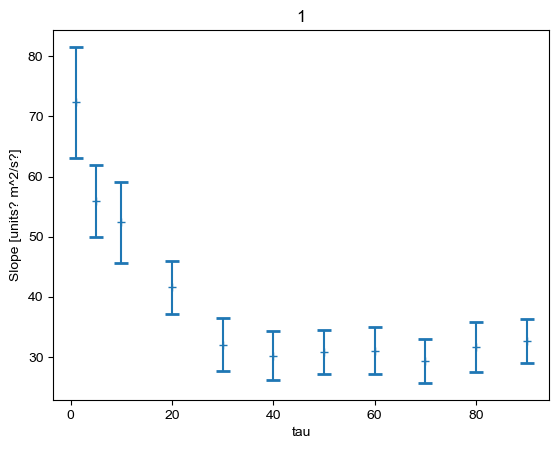

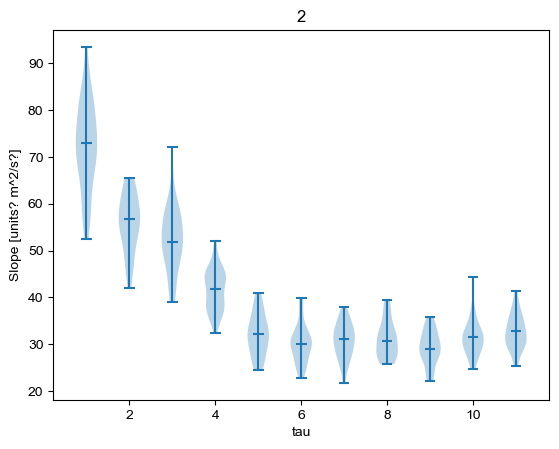

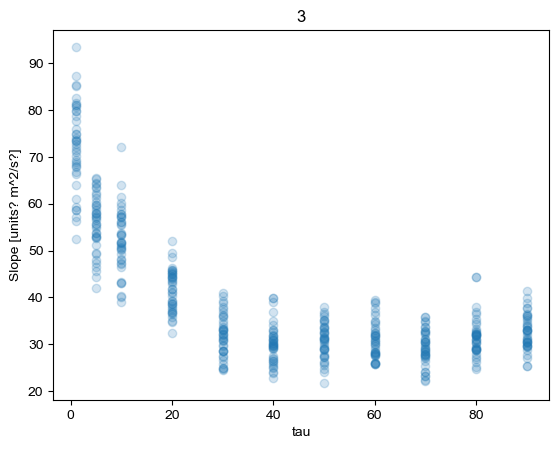

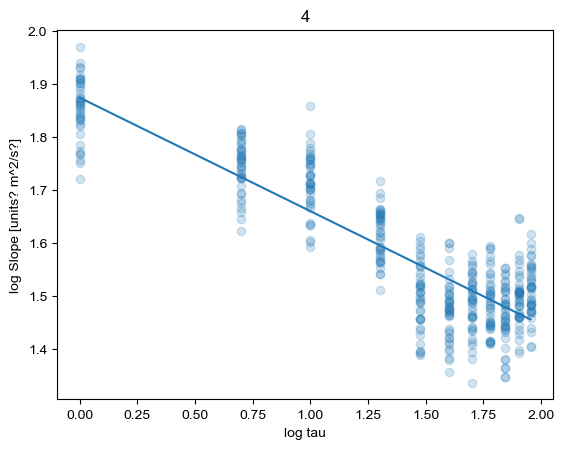

In [45]:
# Plot errorbars plot
slopes_keys, slopes_median, slopes_mean, slopes_std = [], [], [], []
for k in slopes.keys():
    slopes_keys.append(float(k.replace('ms', '')))
    slopes_median.append(np.median(slopes[k]))
    slopes_mean.append(np.mean(slopes[k]))
    slopes_std.append(np.std(slopes[k]))

plt.figure()
plt.errorbar(slopes_keys, slopes_mean, yerr=slopes_std, fmt='+', capsize=5, capthick=2)
plt.xlabel('tau')
plt.ylabel('Slope [units? m^2/s?]')
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim([None, 1])
plt.title('1')

# Repack the data to plot violin plot
plt.figure()
slopes_array = np.empty((len(slopes.keys()), len(slopes['1ms'])))
for i,k in enumerate(slopes.keys()):
    slopes_array[i] = slopes[k]
plt.violinplot(slopes_array.T, showmedians=True)
#plt.violinplot(slopes_array.T, positions = list(slopes.keys()), showmedians=True)
plt.xlabel('tau')
plt.ylabel('Slope [units? m^2/s?]')
#plt.xscale('log')
#plt.yscale('log')
#plt.xticks(range(1, len(slopes.keys())+1), list(slopes.keys()))
#plt.ylim([None, 1])
plt.title('2')

# Repack the data, keys (number of nuerons N) and values (diffusion rates D) 
# into a 2D array.
# 'slopes' is a dictionary with numeric keys and values 1D numpy arrays. 
# The key values are the x value of the data points and the values in each numpy 
# array are the y values recorded for the same x value. 
tau_s = []      # Holds the N value corresponding to each Diffusion value
slopes_s = [] # Holds the corresponding Diffusion values
for k in slopes.keys():
    tau_s = tau_s + [float(k.replace('ms', ''))]*len(slopes[k]) # Append to the list of N values
    slopes_s = np.append(slopes_s, slopes[k]) # Append the Diffusion values
tau_s = np.array(tau_s)    # Convert the list of tau values to an array
one_over_tau_s = 1 / tau_s # Convert 1/tau values
# The result of this section is the x values in the array tau_s and the corresponding
# y values in the array slopes_s. 

# Plot a data histogram
plt.figure()
plt.scatter(tau_s, slopes_s, alpha=0.2)
plt.xlabel('tau')
plt.ylabel('Slope [units? m^2/s?]')
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim([None, 1])
plt.title('3')

# Regress a line to the data points and plot it
# The relation of log(slopes_s) vs log(tau_s) is linear therefore we 
# convert both x and y values to log_10()
log_tau_s = np.log(tau_s) / np.log(10)
log_slopes_s = np.log(slopes_s) / np.log(10)
# and then fit a line to the data points
tau_prime, slopes_prime, params, r2 = regress(log_tau_s, log_slopes_s, func_lin_1, params0=[1, 0], func_str = 'a*x + b, [a, b] = {}', x_range_min=None, x_range_max=None)
plt.figure()
plt.scatter(log_tau_s, log_slopes_s, alpha=0.2)
plt.plot(tau_prime, slopes_prime)
plt.xlabel('log tau')
plt.ylabel('log Slope [units? m^2/s?]')
#plt.xscale('log')
#plt.yscale('log')
#plt.ylim([None, 1])
plt.title('4')



Max tolerable drift rate 0.343$m^2/h$ (9.527777777777779e-05$m^2/s$)
Optimal parameters
D=a*1/(tau+b)^2, [a,b] = [3.22771898e+05 6.85856595e+01]
R^2 = 0.806431584343045
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 58135s
Optimal parameters
D=a*1/(tau+b)^2, [a,b] = [2.44620952e+05 5.80431864e+01]
R^2 = 0.8592949579998432
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 50612s
Optimal parameters
D=a*1/(tau+b)^2, [a,b] = [3.59129926e+05 7.36141235e+01]
R^2 = 0.829771608567494
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 61321s
Optimal parameters
D=a*1/(tau+b)^2, [a,b] = [3.19934227e+05 6.74835252e+01]
R^2 = 0.8437069608806574
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 57880s
Optimal parameters
D=a*1/(tau+b)^2, [a,b] = [2.75657451e+05 6.19131458e+01]
R^2 = 0.8213440029009073
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-0

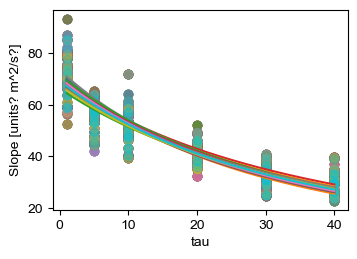

In [46]:
# Fit N~1/D*a to data

# This fits the straightened MAD curves from above so it fits to the calculations 
# of slope that used the MAD^2 data which seems more appropriate. So it fits the 
# the N = a * 1/D where D is in m^2/s.

# Using the above fitted slopes that now are correct as plotted above.
# Now the required numebr of neurons is 700 million instead of 500 milliion.

# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD instead or variance, the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus we have D_{MAD} ~ D_{SD} = \sqrt{D_{VAR}} = \sqrt{\frac{1}{N}a} [m/s] => N = \reac{1}{(D_{SD})^2}a [unitless]
# Thus fit N=(1/D^2)*a=y=((1/x^2)*a) to the ant data points.
# Drift rate MAD/s in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
# condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
# if condition == 1:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.01 # 1% => 1m/100m
# if condition == 2:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

# drift_max = drift_max_percent * range_max_new
drift_max = 0.343 # m2/hour
drift_rate_max = drift_max / t_req # m2/s
x_req = drift_rate_max
print('Max tolerable drift rate {}$m^2/h$ ({}$m^2/s$)'.format(drift_max, drift_rate_max))

# # Not a good fit at all
# func_D_invprop_tau_sq0_str = 'D=a*1/(tau)^2, [a] = {}'
# def func_D_invprop_tau_sq0(x, a):
#   return a*1/(x)**2 

# OKish fit the only reason to use it is if we don't want the +c
func_D_invprop_tau_sq1_str = 'D=a*1/(tau+b)^2, [a,b] = {}'
def func_D_invprop_tau_sq1(tau, a, b):
    D = a*1/(tau+b)**2
    return D

## Good fit
# func_D_invprop_tau_sq2_str = 'D=a*1/(tau+b)^2 + c, [a,b,c] = {}'
# def func_D_invprop_tau_sq2(tau, a, b, c):
#   D = a*1/(tau+b)**2+c
#   return D

func_str = func_D_invprop_tau_sq1_str
func_fit = func_D_invprop_tau_sq1
func_params0 = [1, 0]
# func_params0 = [1, 0, 0]

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

fig = plt.figure(figsize=figsize)

#x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD

# Regress a curve to the data points using bootstrapping and plot
# tau_s    # Neuronal tau
# slopes_s # Dispertion MAD2/s

subsample_size=int(tau_s.shape[0]*0.3)

# Create subsamples of data points
mask = tau_s < 50 # mask nonsaturated simulations
data_x_subsamples, data_y_subsamples = select_rand_subsample(tau_s[mask], 
                                                             slopes_s[mask], 
                                                             subsample_size=subsample_size, 
                                                             N_subsamples=40)

# Use the inverse function for predicting required tau
# That is the inverse of D=a*1/(tau+b)^2
func_tau_sqrtinvprop_D_str = 'tau=sqrt(a*(1/D)) - b, [a,b] = {}'
# The inverse of the better fitting D=a*1/(tau+b)^2+c is not trivial to derive

def func_tau_sqrtinvprop_D(D, a, b):
    # print(D-c)
    tau = np.sqrt(a * 1/D) - b
    return tau

y_reqs, params_cv, Ds = [], [], []

for i in range(len(data_x_subsamples)):
    tau_prime, slope_prime, params, r2 = regress(data_x_subsamples[i], 
                                                 data_y_subsamples[i], 
                                                 func_fit, 
                                                 params0=func_params0, 
                                                 func_str = func_str, 
                                                 x_range_min=None, 
                                                 x_range_max=None,
                                                 bounds=(0,inf))
    # Plot a scatter plot of this subsample
    plt.scatter(data_x_subsamples[i], data_y_subsamples[i], c=f'C{i}', alpha=0.3)
    # Plot the curve fitted to this subsample
    plt.plot(tau_prime, slope_prime, c=f'C{i}')

    # NOTE: here we use the inverse of the fitted function
    # Calculate required tau of neurons
    y_req = func_tau_sqrtinvprop_D(x_req, *params)
    print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need tau {}s'.format(drift_max, x_req, int(np.round(y_req))))

    y_reqs.append(y_req)
    params_cv.append(params)
    # Ds.append(slope_prime)

plt.xlabel('tau')
plt.ylabel('Slope [units? m^2/s?]')

y_reqs = np.array(y_reqs)
print()
print('For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau mean+/-std = {}s+/-{}s or {}h+/-std={}h'.format(np.median(y_reqs), np.std(y_reqs)*np.sqrt(subsample_size), np.median(y_reqs)/60/60, np.std(y_reqs)*np.sqrt(subsample_size)/60/60))


In [54]:
a_mean, b_mean = np.array(params_cv).mean(0)
a_std,  b_std   = np.array(params_cv).std(0)
print('Regressed the function', func_str.format(''), 'with parameters:')
print('  a mean+/-std = {}+/-{} m^2*ms^2'.format(a_mean, a_std))
print('  a mean+/-std = {}+/-{} m^2*s'.format(a_mean*10**-6, a_std*10**-6))
print('  b mean+/-std = {}+/-{} ms'.format(b_mean, b_std))

print('  R^2 = ', r2_score(slopes_s[mask], [func_D_invprop_tau_sq1(tau, a_mean, b_mean) for tau in tau_s[mask]]))

Regressed the function D=a*1/(tau+b)^2 + c, [a,b,c] =  with parameters:
  a mean+/-std = 305425.92746020743+/-27213.848870288744 m^2*ms^2
  a mean+/-std = 0.3054259274602074+/-0.027213848870288743 m^2*s
  b mean+/-std = 65.89228078782902+/-3.561574832692969 ms
  R^2 =  0.8187287583788436


(-1.0, 49.0)

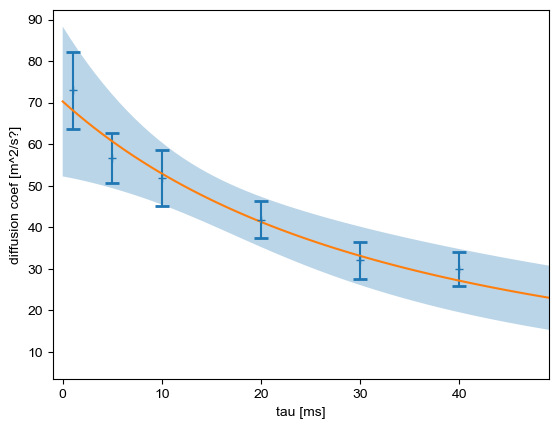

In [48]:
plt.figure()
plt.errorbar(slopes_keys, slopes_median, yerr=slopes_std, fmt='+', capsize=5, capthick=2)
plt.xlabel('tau [ms]')
plt.ylabel('diffusion coef [m^2/s?]')

taus = np.linspace(0,80,100)
a,b = np.array(params_cv).mean(0)
#print(a,b)
#print('mean of a and b =',np.array(params_cv).mean(0))  # right? 
#print('std  of a and b = ', np.array(params_cv).std(0)) # right?
Ds = [func_fit(taus,a,b) for (a,b) in params_cv]
# plt.plot(func_fit(taus,a,b))
plt.plot(taus,np.array(Ds).mean(0))
plt.fill_between(taus,np.array(Ds).mean(0) - np.array(Ds).std(0)*np.sqrt(subsample_size),
                      np.array(Ds).mean(0) + np.array(Ds).std(0)*np.sqrt(subsample_size),alpha=0.3)
plt.xlim([-1,49])

#print('R^2 = ', r2_score(slope_prime, [func_D_invprop_tau_sq1(tau, a, b) for tau in tau_prime]))

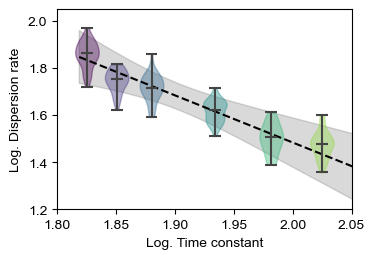

In [49]:
# Plot with CI shade
# ==================
fig = plt.figure(figsize=figsize)

# plt.scatter(np.log(np.array(slopes_keys)+b), 
            #  np.log(slopes_median))
# errorbars are estimates d(log y) = dy / y 
base = np.log(10)
#plt.errorbar(np.log(np.array(slopes_keys)+b)/base, 
#             np.log(slopes_median)/base, 
#             yerr=np.array(slopes_std)/np.array(slopes_median)/base, fmt='+', capsize=5, capthick=2)
plt.xlabel('log (tau + <b>)')
plt.ylabel('log (diffusion coef)')

logDs = [np.log(D)/base for D in Ds]
plt.plot(np.log(taus+b)/base,np.array(logDs).mean(0), linestyle='--', color='black')
plt.fill_between(np.log(taus + b)/base,
                 np.array(logDs).mean(0) - np.array(logDs).std(0)*np.sqrt(subsample_size),
                 np.array(logDs).mean(0) + np.array(logDs).std(0)*np.sqrt(subsample_size),
                 color='#444444', 
                 alpha=0.2)
plt.xlim([4.15/base,4.73/base])
plt.xlim([1.8,2.05])
plt.ylim([1.2,2.05])

# Yannis: Added the violin plots
slopes_array = np.empty((len(slopes.keys()), len(slopes['1ms'])))
for i,k in enumerate(slopes.keys()):
    slopes_array[i] = np.log(slopes[k])/base
violin_parts = plt.violinplot(slopes_array.T, positions=np.log(np.array(slopes_keys)+b)/base, widths=0.02, showmedians=True)

# Make the violin body grey with a grey border:
for vp in violin_parts['bodies']:
    vp.set_facecolor('#444444')
    #vp.set_edgecolor('#444444')
    #vp.set_linewidth(1)
    vp.set_alpha(0.3)

# Make all the violin statistics marks grey:
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    vp.set_edgecolor('#444444')
    #vp.set_linewidth(1)

if colourscheme == 'viridis':
    # Make the violin bodies coloured:
    for indx_j,vp in enumerate(violin_parts['bodies']):
        colour = viridis(indx_j/6)
        vp.set_facecolor(colour)
        vp.set_edgecolor(colour)
        vp.set_alpha(0.4)

# Plot a scatter plot
plt.xlabel('Log. Time constant')
plt.ylabel('Log. Dispersion rate')
#plt.ylabel('Log. Diffusion coef. (log($m^2/s$))')

if SAVE_PLOT:
    fig.savefig(os.path.join(figs_path, 'pub_' + model + '_dispersion_rate_vs_time_constant_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300, transparent=True)


Max tolerable drift rate 0.343$m^2/h$ (9.527777777777779e-05$m^2/s$)
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [19693.11393192    21.19728515    27.338802  ]
R^2 = 0.8152766888992564
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [8715.48392055   12.92685027   28.99836566]
R^2 = 0.8539390607043773
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [19778.03128216    20.68981697    28.17028396]
R^2 = 0.8407220292472231
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [14812.61368887    16.84210079    28.65246392]
R^2 = 0.8589494330623004
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [14398.10724204    16.95477499    28.60194917]
R^2 = 0.8335747120099625
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [18722.49985726    20.04371798    27.85469143]
R^2 = 0.8711321847850735
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [2.01287895e+04 2.00138604e+01 2.79546455e+01]
R^2 = 0.8626147266017077
Optimal parameters
D=a*1/(tau+b)^2 + c, [a,b,c] = [16158.88124174    18.41688869

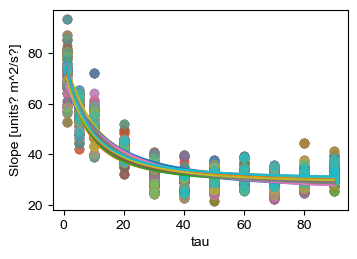

In [50]:
# Fit N~1/D*a to data

# This fits the straightened MAD curves from above so it fits to the calculations 
# of slope that used the MAD^2 data which seems more appropriate. So it fits the 
# the N = a * 1/D where D is in m^2/s.

# Using the above fitted slopes that now are correct as plotted above.
# Now the required numebr of neurons is 700 million instead of 500 milliion.

# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD instead or variance, the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus we have D_{MAD} ~ D_{SD} = \sqrt{D_{VAR}} = \sqrt{\frac{1}{N}a} [m/s] => N = \reac{1}{(D_{SD})^2}a [unitless]
# Thus fit N=(1/D^2)*a=y=((1/x^2)*a) to the ant data points.
# Drift rate MAD/s in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
# condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
# if condition == 1:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.01 # 1% => 1m/100m
# if condition == 2:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

# drift_max = drift_max_percent * range_max_new
drift_max = 0.343 # m2/hour
drift_rate_max = drift_max / t_req # m2/s
x_req = drift_rate_max
print('Max tolerable drift rate {}$m^2/h$ ({}$m^2/s$)'.format(drift_max, drift_rate_max))

# Not a good fit at all
func_invprop_sq0_str = 'D=a*1/(tau)^2 + b, [a,b] = {}'
def func_invprop_sq0(x, a, b):
    return a*1/(x)**2 + b

# OKish fit the only reason to use it is if we don't want the +c
func_D_invprop_tau_sq1_str = 'D=a*1/(tau+b)^2, [a,b] = {}'
def func_D_invprop_tau_sq1(tau, a, b):
    D = a*1/(tau+b)**2
    return D

## Good fit
func_D_invprop_tau_sq2_str = 'D=a*1/(tau+b)^2 + c, [a,b,c] = {}'
def func_D_invprop_tau_sq2(tau, a, b, c):
    D = a*1/(tau+b)**2+c
    return D

func_str = func_D_invprop_tau_sq2_str
func_fit = func_D_invprop_tau_sq2
func_params0 = [1, 0]
func_params0 = [1, 0, 0]

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

fig = plt.figure(figsize=figsize)

#x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD

# Regress a curve to the data points using bootstrapping and plot
# tau_s    # Neuronal tau
# slopes_s # Dispertion MAD2/s

subsample_size=int(tau_s.shape[0]*0.3)

# Create subsamples of data points
data_x_subsamples, data_y_subsamples = select_rand_subsample(tau_s, 
                                                             slopes_s, 
                                                             subsample_size=subsample_size, 
                                                             N_subsamples=40)

# Use the inverse function for predicting required tau
# The inverse of D=a*1/(tau+b)^2+c follows BUT  
# BUT it requires that D > 1 because otherwise it is a sqrt of 
# a negative number which gives NaN in numpy. Practically, 
# this function is not what we want because D << 1.
func_tau_sqrtinvprop_D_str = 'tau=sqrt(a*(1/(c*(D-1)))) - b, [a,b,c] = {}'
def func_tau_sqrtinvprop_D(D, a, b, c):
    tau = np.sqrt(a * 1/((D-c))) - b
    return tau

y_reqs = []

for i in range(len(data_x_subsamples)):
    tau_prime, slope_prime, params, r2 = regress(data_x_subsamples[i], 
                                                 data_y_subsamples[i], 
                                                 func_fit, 
                                                 params0=func_params0, 
                                                 func_str = func_str, 
                                                 x_range_min=None, 
                                                 x_range_max=None,
                                                 bounds=(0,inf))
    # Plot a scatter plot of this subsample
    plt.scatter(data_x_subsamples[i], data_y_subsamples[i], c=f'C{i}', alpha=0.3)
    # Plot the curve fitted to this subsample
    plt.plot(tau_prime, slope_prime, c=f'C{i}')

    # NOTE: here we need to use the inverse of the fitted function
    # Calculate required tau of neurons
    # That is the one inverse function I derived, contains sqrt(...(D-1)...) but D-1 is <0.
    #y_req = func_tau_sqrtinvprop_D(x_req, *params)
    # Another attempt to use an alternative derivation of the inverse gave that. It requires a<0 but that gives not good fits. This requires changing bounds above to bounds=(0,inf)) # The alternative attempt needs replacing with bounds=([-inf,0,-inf], [0,inf,inf]
    #y_req = np.sqrt(params[0] * (x_req - params[2]) - params[1])

    #print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need tau {}s'.format(drift_max, x_req, int(np.round(y_req))))

    #y_reqs.append(y_req)

plt.xlabel('tau')
plt.ylabel('Slope [units? m^2/s?]')

#y_reqs = np.array(y_reqs)
print()
#print('Neuronal tau required median={}s, std={}'.format(np.median(y_reqs), np.std(y_reqs)*np.sqrt(subsample_size)))
print('We cannot estimate required tau because the inverse of the fitted function requires D>1.')


Max tolerable drift rate 0.343$m^2/h$ (9.527777777777779e-05$m^2/s$)
Optimal parameters
tau=sqrt(a*(1/D)) - b, [a,b] = [6.77600363e+05 9.64142800e+01]
R^2 = 0.49595158923651483
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 84235s
Optimal parameters
tau=sqrt(a*(1/D)) - b, [a,b] = [5.84095801e+05 8.81053388e+01]
R^2 = 0.42784348436983
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 78209s
Optimal parameters
tau=sqrt(a*(1/D)) - b, [a,b] = [7.80002154e+05 1.03163834e+02]
R^2 = 0.48203207481695143
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 90377s
Optimal parameters
tau=sqrt(a*(1/D)) - b, [a,b] = [8.46150706e+05 1.10441924e+02]
R^2 = 0.5950053056832538
For ensuring drift of less than 0.343m^2/h (9.527777777777779e-05m^2/s) we need tau 94128s
Optimal parameters
tau=sqrt(a*(1/D)) - b, [a,b] = [6.86840776e+05 9.59729518e+01]
R^2 = 0.49048692298645835
For ensuring drift of less than

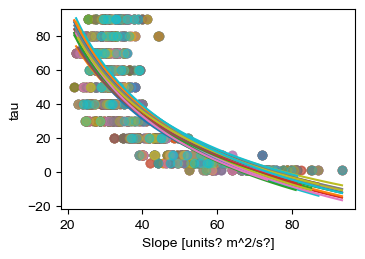

In [61]:
# Fit N~1/D*a to data

# This fits the straightened MAD curves from above so it fits to the calculations 
# of slope that used the MAD^2 data which seems more appropriate. So it fits the 
# the N = a * 1/D where D is in m^2/s.

# Using the above fitted slopes that now are correct as plotted above.
# Now the required numebr of neurons is 700 million instead of 500 milliion.

# The relation theretically should be drift_coefficient(measured as variance/s)~1/N, N being the number of neurons.
# This means that when measuring dispertion using MAD instead or variance, the relation will be drift_coefficient(measured as MAD/s)~sqrt(1/N), N being the number of neurons.
# Thus we have D_{MAD} ~ D_{SD} = \sqrt{D_{VAR}} = \sqrt{\frac{1}{N}a} [m/s] => N = \reac{1}{(D_{SD})^2}a [unitless]
# Thus fit N=(1/D^2)*a=y=((1/x^2)*a) to the ant data points.
# Drift rate MAD/s in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
# condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
# if condition == 1:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.01 # 1% => 1m/100m
# if condition == 2:
#     t_req = 60 * 60 # t_req = 1h
#     drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

# drift_max = drift_max_percent * range_max_new
drift_max = 0.343 # m2/hour
drift_rate_max = drift_max / t_req # m2/s
x_req = drift_rate_max
print('Max tolerable drift rate {}$m^2/h$ ({}$m^2/s$)'.format(drift_max, drift_rate_max))

# First approximation to fitting function
func_tau_sqrtinvprop_D_str = 'tau=sqrt(a*(1/D)) - b, [a,b] = {}'

def func_tau_sqrtinvprop_D(D, a, b):
    tau = np.sqrt(a * 1/D) - b
    return tau

func_str = func_tau_sqrtinvprop_D_str
func_fit = func_tau_sqrtinvprop_D
func_params0 = [1, 0]

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005

fig = plt.figure(figsize=figsize)

#x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)]) # Dispertion MAD

# Regress a curve to the data points using bootstrapping and plot
# tau_s    # Neuronal tau
# slopes_s # Dispertion MAD2/s

subsample_size = int(tau_s.shape[0]*0.3)

# Create subsamples of data points
data_x_subsamples, data_y_subsamples = select_rand_subsample(slopes_s, 
                                                             tau_s, 
                                                             subsample_size=subsample_size, 
                                                             N_subsamples=40)

y_reqs = []

for i in range(len(data_x_subsamples)):
    slope_prime, tau_prime, params, r2 = regress(data_x_subsamples[i], 
                                                 data_y_subsamples[i], 
                                                 func_fit, 
                                                 params0=func_params0, 
                                                 func_str = func_str, 
                                                 x_range_min=None, 
                                                 x_range_max=None)
    # Plot a scatter plot of this subsample
    plt.scatter(data_x_subsamples[i], data_y_subsamples[i], c=f'C{i}', alpha=0.3)
    # Plot the curve fitted to this subsample
    plt.plot(slope_prime, tau_prime, c=f'C{i}')

    # Calculate required number of neurons
    y_req = func_fit(x_req, *params)
    print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need tau {}s'.format(drift_max, x_req, int(np.round(y_req))))

    y_reqs.append(y_req)

plt.xlabel('Slope [units? m^2/s?]')
plt.ylabel('tau')

y_reqs = np.array(y_reqs)
print()
print('Neuronal tau required median={}s, std={}'.format(np.median(y_reqs), np.std(y_reqs)*np.sqrt(subsample_size)))



### The following are copied from the boxes that follow them and these immediatelly following new runs include  the additional trials collected on 16-17 September 2021 to see if the drifts would be better clarified which they are not. 


Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
1ms     56.82783959781106
5ms     38.51453153822763
10ms    30.64207760949056
20ms    32.76907861764021
30ms    23.305763951455425
40ms    22.062992361113245
50ms    21.13559021215964
60ms    20.352842059038103
80ms    21.29868014745088
90ms    22.985114310456595
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
1ms     15.78551099939196
5ms     10.698480982841009
10ms    8.511688224858489
20ms    9.102521838233391
30ms    6.473823319848729
40ms    6.128608989198124
50ms    5.870997281155456
60ms    5.6535672386216955
80ms    5.916300040958578
90ms    6.384753975126832
Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y=(1/sqrt(sqrt(sqrt(x*256))))*a, [a] = [24.09827931]
R^2 = 0.7195951020547391


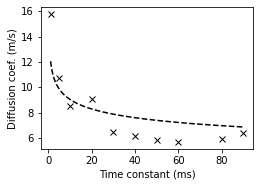

In [ ]:
# That cell was added more recently from the below ones and uses the improved fitting function, 
# now the data are raised to ^2 before calculating the rate of change, it uses reversed x and y.

# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits a curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. 

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s
# Use option=10 or try option=0 which is a new one now that the rate calculation is more robust
#option = 0 #

if option == 0:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]    
if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

if option == 0: # 
    start_time=20
    end_time=280
    percentage=0.10
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms


# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage, exponent=2)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
y_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_inv(x, a):
    """ Exponential function """
    y = (1/x)*a                           # Worse match match          option=10: R^2=-8.709075565568623 with a=0.12043992     , option=14: R^2=-40.70707522210285 with a=0.03548746
    #y = (1/x**2)*a                           # Worse match match          option=10: R^2=-8.709075565568623 with a=0.12043992     , option=14: R^2=-40.70707522210285 with a=0.03548746
    #y = (1/x**3)*a                         # 
    #y = (1/x**4)*a                         # 
    y = (1/(x/1000))*a                      # 
    y = (1/(x/1000)**2)*a                   # 
    y = (1/np.sqrt(x))*a                    # 
    y = (1/np.sqrt(np.sqrt(x)))*a           # 
    y = (1/np.sqrt(np.sqrt(np.sqrt(x))))*a  # 
    y = (1/np.sqrt(np.sqrt(np.sqrt(np.sqrt(x)))))*a  # 
    y = (1/np.sqrt(x/1000))*a               # 
    y = (1/np.sqrt(np.sqrt(x/1000)))*a      # 
    y = (1/np.sqrt(np.sqrt(np.sqrt(x/1000))))*a # 
    y = (1/np.sqrt(np.sqrt(x*256)))*a       # 
    y = (1/np.sqrt(np.sqrt(np.sqrt(x*256))))*a # 
    #y = np.sqrt((1/(x**2))*a)             # As bad as the above match  option=10: R^2=-8.709075565568625 with a=0.01450578     , option=14: R^2=
    #y = np.sqrt((1/x)*a)                   # Better match than above    option=10: R^2=-3.0322176811319093 with a=0.01924918    , option=14: R^2=-21.086390053983102 with a=0.00228764
    #y = np.sqrt(np.sqrt((1/x)*a))          # Better match than above    option=10: R^2=0.4966919105854041 with a=0.00016649     , option=14: R^2=-3.003016657039499 with a=3.21558384e-06
    #y = np.sqrt(np.sqrt((1/(x/1000))*a))  # Same match as above        option=10: R^2=0.4966919105854042 with a=1.66486035e-07 so being in ms is not the issue , option=14: R^2=-3.003016657039497 with a=3.21558391e-09
    #y = np.sqrt(np.sqrt(np.sqrt((1/x)*a))) # Better match than above    option=10: R^2=0.8028734780604101 with a=3.19932263e-09 , option=14: R^2=0.766058050603421 with a=1.16492867e-12
    #y = np.sqrt(np.sqrt(np.sqrt(np.sqrt((1/x)*a)))) # Worse than above option=10: R^2=0.5106716868419569 with a=5.94346857e-19 , option=14: R^2=0.8168608596406958 with a=6.9937717e-26
    return y
func_inv_str = 'y=sqrt(sqrt(sqrt((1/x)*a))), [a] = {}'
func_inv_str = 'y=(1/sqrt(sqrt(sqrt(x*256))))*a, [a] = {}'


#def func_inv(x, a, b, c):
#    """ Exponential function """
#    y = (1/np.sqrt(np.sqrt((x*b)**c)))*a           # 
#    return y
#func_inv_str = 'y=(1/sqrt(sqrt((x*b)^c)))*a, [a] = {}'

# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    y = np.array(results_data[poisson_neuron_noise][model]['y'])
    x = np.array(results_data[poisson_neuron_noise][model]['x'])
    x = x.astype(np.float) # Convert the array of strings to array of numbers
    y = scale_circ_to_line(y, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.ylabel('Diffusion rate (m/s)')
    plt.xlabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_inv, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        #print('y=a*(1/x), [a] = {}'.format(params))
        print(func_inv_str.format(params))
        # Calculate fitted curve prediction
        y_prime = func_inv(x, params[0])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        #x_req = func_inv(y_req, params[0])
        #print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        min_lim = np.min(x)
        x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_inv(x_prime, params[0])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_inv, params0, func_str = func_inv_str)
        #x_req = func_inv(xy_req, *params)
        #print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.ylabel('Drift rate (m/s)')
    plt.ylabel('Diffusion coef. (m/s)')
    plt.xlabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        


Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
1ms     56.82783959781106
5ms     38.51453153822763
10ms    30.64207760949056
20ms    32.76907861764021
30ms    23.305763951455425
40ms    22.062992361113245
50ms    21.13559021215964
60ms    20.352842059038103
80ms    21.29868014745088
90ms    22.985114310456595
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
1ms     15.78551099939196
5ms     10.698480982841009
10ms    8.511688224858489
20ms    9.102521838233391
30ms    6.473823319848729
40ms    6.128608989198124
50ms    5.870997281155456
60ms    5.6535672386216955
80ms    5.916300040958578
90ms    6.384753975126832
Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y = (1/x)*a, [a] = [305.23116898]
R^2 = 0.45459626430287237
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time constant of 32318.5

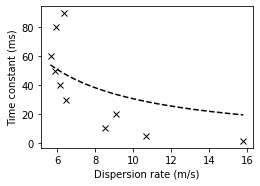

In [ ]:
# That cell was added more recently from the below ones and uses the improved fitting function, 
# now the data are raised to ^2 before calculating the rate of change. This one uses the same 
# x and y order as the older cells below to extrapolate the needed time constant.

# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits a curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. 

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage, exponent=2)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_inv(x, a):
    """ Exponential function """
    y = (1/x)*a                                #     option=10: R^2=0.31 with a=
    #y = ((1/(x))*a)**2                         #     option=10: R^2=0.497 with a=
    #y = (1/(x**2))*a                           #     option=10: R^2=0.497 with a=

    #y = (1/(x**2 * 256))*a**2                  #     option=10: R^2= with a=
    #y = (1/(x**4 * 256))*a**4                  #     option=10: R^2= with a=
    #y = (1/(x**8 * 256))*a**8                  #     option=10: R^2= with a=
    
    #y = (1/(x**2))*a**2                        #     option=10: R^2= with a=
    #y = (1/(x**4))*a**4                        #     option=10: R^2= with a=
    #y = (1/(x**8))*a**8                        #     option=10: R^2= with a=
    
    #y = (1/((x*256)**2))*a                    #     option=10: R^2=0.4975325673759411 with a= 2759949.642567136s
    #y = (1/((x*256**2)**2))*a                 #     option=10: R^2=0.4975325673759411 with a= 2759949.6453054957s
    #y = (1/((x/256)**2))*a                    #     option=10: R^2=0.4975325673759411 with a= 2759949.6474032043s
    #y = (1/((x/256**2)**2))*a                 #     option=10: R^2=0.4975325673759411 with a= 2759949.645394417s
    #y = (1/(x**4))*a                           #     option=10: R^2=0.67 with a=
    #y = (1/(x**6))*a                           #     option=10: R^2=0.74 with a=
    #y = (1/(x**7))*a                           #     option=10: R^2=0.7475146082509978 with a=
    ###y = (1/(x**8))*a                           #     option=10: R^2=0.7529741637477689 with a=
    #y = (1/(x**9))*a                           #     option=10: R^2=0.7533763558607385 with a=
    #y = (1/(x**10))*a                           #     option=10: R^2=0.75 with a=
    #y = (1/(x**12))*a                          #     option=10: R^2=0.73 with a=
    #y = (1/(x**14))*a                           #     option=10: R^2=0. with a=
    #y = (1/(x**16))*a                          #     option=10: R^2=0.68 with a=
    #y = ((1/(x))*a)**2                         #     option=10: R^2=0.497 with a=
    #y = ((1/(x))*a)**4                         #     option=10: R^2=0.67 with a=
    #y = ((1/(x))*a)**6                         #     option=10: R^2=0.73 with a=
    #y = ((1/(x))*a)**7                         #     option=10: R^2=0.75 with a=
    #y = ((1/(x))*a)**8                         #     option=10: R^2=0.75 with a=
    #y = ((1/(x))*a)**9                         #     option=10: R^2=0.753 with a=
    #y = ((1/(x))*a)**10                         #     option=10: R^2=0.75 with a=
    #y = ((1/(x))*a)**12                         #     option=10: R^2=0.73 with a=
    
    #y = np.sqrt((1/(x**2))*a)                 #     option=10: R^2= with a=
    ##y = np.sqrt((1/x)*a)                     #     option=10: R^2= with a=
    ##y = np.sqrt(np.sqrt((1/x)*a))            #     option=10: R^2= with a=
    #y = np.sqrt(np.sqrt((1/(x/1000))*a))      #     option=10: R^2= with a=
    ##y = np.sqrt(np.sqrt(np.sqrt((1/x)*a)))   #     option=10: R^2= with a=
    #y = np.sqrt(np.sqrt(np.sqrt(np.sqrt((1/x)*a)))) #  option=10: R^2= with a=
    y = (1/(x+a+0.0000000000001))                                #     option=10: R^2=0.31 with a=
    y = (1/x)+a                                #     option=10: R^2=0.31 with a=
    y = (1/x)*a                                #     option=10: R^2=0.31 with a=
    
    return y

func_inv_str = 'y=(1/(x^2))*a, [a] = {}'
func_inv_str = 'y = (1/x)*a, [a] = {}'
func_inv_str = 'y = (1/(x+a)), [a] = {}'
func_inv_str = 'y = (1/x)+a, [a] = {}'
func_inv_str = 'y = (1/x)*a, [a] = {}'

# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = True
    if Method1:
        params, conv  = curve_fit(func_inv, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        #print('y=a*(1/x), [a] = {}'.format(params))
        print(func_inv_str.format(params))
        # Calculate fitted curve prediction
        y_prime = func_inv(x, params[0])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_inv(x_req, params[0])
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        min_lim = np.min(x) - 0.004
        #min_lim = 0 # TEMP
        x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_inv(x_prime, params[0])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = False
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_inv, params0, func_str = func_inv_str)
        y_req = func_inv(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        


Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
1ms     56.82783959781106
5ms     38.51453153822763
10ms    30.64207760949056
20ms    32.76907861764021
30ms    23.305763951455425
40ms    22.062992361113245
50ms    21.13559021215964
60ms    20.352842059038103
80ms    21.29868014745088
90ms    22.985114310456595
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
1ms     15.78551099939196
5ms     10.698480982841009
10ms    8.511688224858489
20ms    9.102521838233391
30ms    6.473823319848729
40ms    6.128608989198124
50ms    5.870997281155456
60ms    5.6535672386216955
80ms    5.916300040958578
90ms    6.384753975126832
Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
y = (1/x)*a+b, [a, b] = [646.33890166 -50.24955606]
R^2 = 0.6480116705593773
For ensuring drift of less than 0.034m/h (9.444444444444445e-06m/s) we need a time co

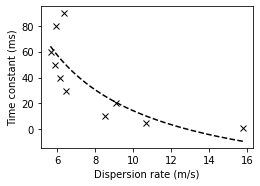

In [ ]:
# That cell was added more recently from the below ones and uses the improved fitting function, 
# now the data are raised to ^2 before calculating the rate of change. This one uses the same 
# x and y order as the older cells below to extrapolate the needed time constant.

# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits a curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. 

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage, exponent=2)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y


def func_inv(x, a, b):
    y = (1/x)*a+b                                #     option=10: R^2=0.31 with a=
    return y

func_inv_str = 'y=(1/(x^2))*a, [a] = {}'
func_inv_str = 'y = (1/x)*a, [a] = {}'
func_inv_str = 'y = (1/(x+a)), [a] = {}'
func_inv_str = 'y = (1/x)+a, [a] = {}'
func_inv_str = 'y = (1/x)*a+b, [a, b] = {}'

# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [1,1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [1,1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0,1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0,1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0,1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [1,1] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = True
    if Method1:
        params, conv  = curve_fit(func_inv, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        #print('y=a*(1/x), [a] = {}'.format(params))
        print(func_inv_str.format(params))
        # Calculate fitted curve prediction
        y_prime = func_inv(x, params[0], params[1])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_inv(x_req, params[0], params[1])
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        min_lim = np.min(x) - 0.004
        #min_lim = 0 # TEMP
        x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_inv(x_prime, params[0], params[1])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = False
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_inv, params0, func_str = func_inv_str)
        y_req = func_inv(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        


Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
1ms     0.46786642465066647
5ms     0.3875806519597856
10ms    0.3471942979209212
20ms    0.35542157845753847
30ms    0.29995403618158195
40ms    0.29225145223443927
50ms    0.28626497671217277
60ms    0.2818447705239732
80ms    0.28886439418749643
90ms    0.29835617577463774
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
1ms     0.12996289573629624
5ms     0.10766129221105156
10ms    0.09644286053358922
20ms    0.09872821623820513
30ms    0.08332056560599499
40ms    0.08118095895401091
50ms    0.07951804908671466
60ms    0.078290214034437
80ms    0.08024010949652678
90ms    0.08287671549295493
Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [5883.943428     55.98488277   -6.49609392]
R^2 = 0.6632502756042038
For ensuring drift of less than 0.034

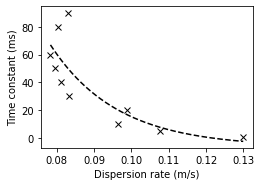

In [ ]:
# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits an exponential curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. (This was used in the original version of the paper)

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        


Noise = 1.4

NMDA-TAU neuron model
---------------------
Scaled output
---------------------
Neurons Drift rate
number    (°/s)   
5ms     3.007135617523402
10ms    2.495580766179817
20ms    2.4843488675919776
30ms    1.7140710910302777
40ms    1.663968407761725
50ms    1.686458950119637
60ms    1.5894994895481411
80ms    1.6177605967497675
90ms    1.7632343430579247
Max tolerable drift rate 0.539m^2/h (0.00014972222222222223m^2/s)
Optimal parameters
y=(1/(x^2))*a, [a] = [91.31691878]
R^2 = -10.121957930223392
For ensuring drift of less than 0.539m^2/h (0.00014972222222222223m^2/s) we need 4073603173 excitatory neurons
Optimal parameters
y=(1/(x^2))*a, [a] = [91.31691878]
R^2 = -10.121957930223392
For ensuring drift of less than 0.539^2m/h (0.00014972222222222223m^2/s) we need a time constant of 4073603.17305186s


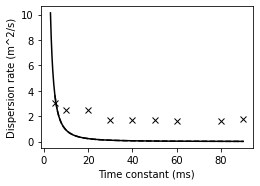

In [ ]:
# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits an exponential curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. (This was used in the original version of the paper)

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms
    
    start_time=0
    end_time=299
    percentage=0.0
    taus = [       '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms and 1ms and 5ms

# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            
            scale=[(0, 360), (0, 100)] # None or a mapping
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage, exponent=2, scale=scale)
            if scale is None: 
                print('---------------------')
                print('Not scaled output')
                print('---------------------')
            else: 
                print('---------------------')
                print('Scaled output')
                print('---------------------')
                
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            #print('---------------------')
            #print('Scaled output')
            #print('---------------------')
            #print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    #drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
    drift_max_percent = 0.539 # m^2/hour (alt)

range_max = 360
range_max_new = 100

#drift_max = drift_max_percent * range_max_new
drift_max = drift_max_percent #  (alt)

drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m^2/h ({}m^2/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_x2_inv(x, a):
    """ Exponential function """
    y = (1/x**2)*a                                #     option=10: R^2= with a=
    return y

def func_sqrtx_inv(x, a):
    """ Exponential function """
    y = (1/np.sqrt(x))*a                                #     option=10: R^2= with a=
    return y

func_fit = func_x2_inv

func_fit_str = 'y=(1/(x^2))*a, [a] = {}'
#func_fit_str = 'y=(1/sqrt(x))*a, [a] = {}'


# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    y = np.array(results_data[poisson_neuron_noise][model]['y'])
    x = np.array(results_data[poisson_neuron_noise][model]['x'])
    x = x.astype(np.float) # Convert the array of strings to array of numbers
    #y = scale_circ_to_line(y, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.ylabel('Dispersion rate (m/s)')
    plt.xlabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
        #params0 = [4946.138,     69.046,   -4.955]
        
    # Method 1
    Method1 = True
    if Method1:
        params, conv  = curve_fit(func_fit, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print(func_fit_str.format(params))
        # Calculate fitted curve prediction
        y_prime = func_fit(x, *params)
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_fit(x_req, *params)
        print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        min_lim = np.min(x) - 2
        x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_fit(x_prime, *params)
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_fit, params0, func_str = func_fit_str)
        y_req = func_fit(x_req, *params)
        print('For ensuring drift of less than {}^2m/h ({}m^2/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.ylabel('Dispersion rate (m^2/s)')
    plt.xlabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        

Removed 1ms and 20ms because 1ms<refactory period and 20ms oddly resulted in higher error

Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
5ms     0.3875806519597856
10ms    0.3471942979209212
30ms    0.29995403618158195
40ms    0.29225145223443927
50ms    0.28626497671217277
60ms    0.2818447705239732
80ms    0.28886439418749643
90ms    0.29835617577463774
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
5ms     0.10766129221105156
10ms    0.09644286053358922
30ms    0.08332056560599499
40ms    0.08118095895401091
50ms    0.07951804908671466
60ms    0.078290214034437
80ms    0.08024010949652678
90ms    0.08287671549295493
Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [1278.71563036   31.7181415   -40.93480856]
R^2 = 0.5648340324260848
For ensuring drift of less than 0.034m/h (9.444444444444445

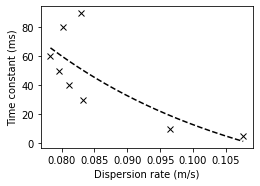

In [ ]:
# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits an exponential curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. (This was used in the original version of the paper)

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms
    taus = [       '5ms', '10ms',         '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms Removed 1ms and 20ms
    print('Removed 1ms and 20ms because 1ms<refactory period and 20ms oddly resulted in higher error')

# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        


Noise = 1.4

NMDA-TAU neuron model
---------------------
Not scaled output
---------------------
Neurons Drift rate
number    (°/s)   
1ms     0.46786642465066647
5ms     0.3875806519597856
10ms    0.3471942979209212
20ms    0.35542157845753847
30ms    0.29995403618158195
40ms    0.29225145223443927
50ms    0.28626497671217277
60ms    0.2818447705239732
80ms    0.28886439418749643
90ms    0.29835617577463774
---------------------
Scaled output
---------------------
Neurons Drift rate
number  (units/s) 
1ms     0.12996289573629624
5ms     0.10766129221105156
10ms    0.09644286053358922
20ms    0.09872821623820513
30ms    0.08332056560599499
40ms    0.08118095895401091
50ms    0.07951804908671466
60ms    0.078290214034437
80ms    0.08024010949652678
90ms    0.08287671549295493
Max tolerable drift rate 0.034m/h (9.444444444444445e-06m/s)
Optimal parameters
a*exp(-b*x)+c, [a, b, c] = [13749.95649558    67.85918064]
R^2 = 0.6599209475836897
For ensuring drift of less than 0.034m/h (9.44444

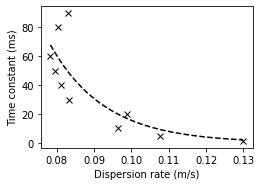

In [ ]:
# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits an exponential curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. (This was used in the original version of the paper)

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_2(x, a, b):
    """ Exponential function """
    y = a * np.exp(-b*x)
    return y

# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [1, 1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [1, 1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [1, 1] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_2, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x), [a, b] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_2(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_2(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_2(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_2, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_2(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Dispersion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        

In [ ]:
# Explores parameters for calculating drift rates from the curves 
# that results in best meaurements for fitting the curve to the data points.
# We want to select the parameters that result to a large "required tau" and "R2 score" 
# because we know the tau must be really large to achieve the stability required 
# so anything else must be just an artifact of our simulations and estimation. 

import contextlib

optimise_option = 1 # Explore with poisson_neuron_noise=1.4 and neurons_nums=256
optimise_option = 2 # Explore with poisson_neuron_noise=0.15 and neurons_nums=512
optimise_option = 3 # Explore with poisson_neuron_noise=0.05 and neurons_nums=512

#taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
#for start_time in [0]:
#    for end_time in [257, 258, 259, 260]:
#        for percentage in np.linspace(0.1, 0.2, 11).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:

# These were used to explore with poisson_neuron_noise=1.4 and neurons_nums=256
if optimise_option == 1:
    poisson_neuron_noises = [1.4]
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms']

# These were used to explore with poisson_neuron_noise=0.15 and neurons_nums=512
if optimise_option == 2:
    poisson_neuron_noises = [0.15]
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# These were used to explore with poisson_neuron_noise=0.05 and neurons_nums=512
if optimise_option == 3:
    poisson_neuron_noises = [0.05]
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 

    
poisson_neuron_noise = poisson_neuron_noises[0]
# neurons_nums is not used in this code so we do not set it

results_data_struc = []
for start_time in [100, 110, 120, 130, 140, 150]:
    for end_time in [240, 250, 260, 270, 280, 290, 299]:
        for percentage in np.linspace(0.05, 0.5, 101).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:
            with contextlib.redirect_stdout(None):
                print('start_time={:6}, end_time={:6}, percentage={:6}'.format(start_time, end_time, percentage))
                results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            x = np.array(results_data[poisson_neuron_noise][model]['y'])
            y = np.array(results_data[poisson_neuron_noise][model]['x'])
            y = y.astype(np.float) # Convert the array of strings to array of numbers
            x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
            try:
                with contextlib.redirect_stdout(None):
                    x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
                    y_req = func_exp_1(x_req, *params)
                #print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))
                results_data_struc.append([start_time, end_time, percentage, y_req/1000, r2])
            except:
                pass

print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('start',    'end',      'percent', 'required', 'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('time (s)', 'time (s)', '(%)',        'tau (s)',  'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format(*(['-'*8]*5)))
for item in results_data_struc:
    print('{:8} {:8} {:8.2f} {:8.3f} {:8.3f}'.format(*item))


TypeError: ignored

### That was run on 15-16 September 2021 before introducing the extra trials used in the runs above

In [ ]:
# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
option = 7
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2:
    # Option 2
    # Option 2 : 5510.134952119207s
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3:
    start_time=0
    end_time=250
    percentage=0.1
if option == 4:
    start_time=0
    end_time=250
    percentage=0.2
if option == 5:
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6:
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7:
    start_time=0
    end_time=235
    percentage=0.32
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            print('---------------------')
            print('Not scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            print('---------------------')
            print('Scaled output')
            print('---------------------')
            print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)


In [ ]:
# Explore parameters for calculating drift rate that results in best meaurements for fitting the curve to the data points

import contextlib

#taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
#for start_time in [0]:
#    for end_time in [257, 258, 259, 260]:
#        for percentage in np.linspace(0.1, 0.2, 11).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:
taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

results_data_struc = []
for start_time in [0]:
    for end_time in [235]:
        for percentage in np.linspace(0.3, 0.34, 101).tolist(): #[0.1, 0.15, 0.2, 0.25, 0.3]:
            with contextlib.redirect_stdout(None):
                print('start_time={:6}, end_time={:6}, percentage={:6}'.format(start_time, end_time, percentage))
                results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)
            x = np.array(results_data[poisson_neuron_noise][model]['y'])
            y = np.array(results_data[poisson_neuron_noise][model]['x'])
            y = y.astype(np.float) # Convert the array of strings to array of numbers
            x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
            try:
                with contextlib.redirect_stdout(None):
                    x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
                    y_req = func_exp_1(x_req, *params)
                #print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))
                results_data_struc.append([start_time, end_time, percentage, y_req/1000, r2])
            except:
                pass

print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('start',    'end',      'percent', 'required', 'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format('time (s)', 'time (s)', '(%)',        'tau (s)',  'R2 score'))
print('{:^8} {:^8} {:^8} {:^8} {:^8}'.format(*(['-'*8]*5)))
for item in results_data_struc:
    print('{:8} {:8} {:8.2f} {:8.3f} {:8.3f}'.format(*item))


In [ ]:
# Option 7
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

In [ ]:
# Option 6
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

In [ ]:
# Option 4
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [4946.138,     69.046,   -4.955]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

In [ ]:
# Option 3
# Plotted with trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=0, end_time=200, percentage=0.1) above
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
        params0 = [8015.316, 103.743, 1.9]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

In [ ]:
# This includes only a subset of the data points without the extremes
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
#taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]

In [ ]:
# Option 2
# Plotted with trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=10, end_time=200, percentage=0.1) above
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)

In [ ]:
# The following includes all data points
# taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]

In [ ]:
# Option 1
# Plotted with trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=0, end_time=200, percentage=0.1) above
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)

range_max = 360
range_max_new = 100

drift_max = drift_max_percent * range_max_new
drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m/h ({}m/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

# Plot only for 0.005 synaptic noise
poisson_neuron_noise = 0.005
poisson_neuron_noise = 0.0001
poisson_neuron_noise = 1.0
poisson_neuron_noise = 1.4

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    x = np.array(results_data[poisson_neuron_noise][model]['y'])
    y = np.array(results_data[poisson_neuron_noise][model]['x'])
    y = y.astype(np.float) # Convert the array of strings to array of numbers
    x = scale_circ_to_line(x, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.xlabel('Diffusion rate (m/s)')
    plt.ylabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [10000, 10, 10] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0, 0, 0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [20, 20, -2] # Initial guess of parameter values to optimize [a, b, c]
    
    
    # Method 1
    Method1 = False
    if Method1:
        params, conv  = curve_fit(func_exp_1, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print('y=a*exp(-b*x)+c, [a, b, c] = {}'.format(params))
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x, params[0], params[1], params[2])
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_exp_1(x_req, params[0], params[1], params[2])
        print('For ensuring drift of less than {}m/h ({}m/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        x_prime = np.linspace(0, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_exp_1(x_prime, params[0], params[1], params[2])
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_exp_1, params0, func_str = 'a*exp(-b*x)+c, [a, b, c] = {}')
        y_req = func_exp_1(x_req, *params)
        print('For ensuring drift of less than {}m/h ({}m/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')

    # 
    #plt.legend(loc='best')
    plt.xlabel('Drift rate (m/s)')
    plt.ylabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + figs_extension), bbox_inches='tight', dpi=300)